In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_targets_t1_normalized_k5_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 1380)
(4629816, 8)
validation
(621056, 1380)
(621056, 8)
test
(624904, 1380)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1380)]            0         


 dense (Dense)               (None, 1024)              1414144   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 2104200 (8.03 MB)


Trainable params: 2104200 (8.03 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 13:14 - loss: 2.1217 - STD: 0.0417 - MAE: 0.2181

  3/463 [..............................] - ETA: 14s - loss: 2.0844 - STD: 0.0428 - MAE: 0.2169  

  5/463 [..............................] - ETA: 14s - loss: 2.0805 - STD: 0.0424 - MAE: 0.2168

  7/463 [..............................] - ETA: 14s - loss: 2.0739 - STD: 0.0409 - MAE: 0.2167

  9/463 [..............................] - ETA: 14s - loss: 2.0692 - STD: 0.0391 - MAE: 0.2167

 11/463 [..............................] - ETA: 14s - loss: 2.0678 - STD: 0.0381 - MAE: 0.2168

 13/463 [..............................] - ETA: 14s - loss: 2.0663 - STD: 0.0373 - MAE: 0.2168

 15/463 [..............................] - ETA: 14s - loss: 2.0641 - STD: 0.0368 - MAE: 0.2167

 17/463 [>.............................] - ETA: 14s - loss: 2.0628 - STD: 0.0364 - MAE: 0.2167

 19/463 [>.............................] - ETA: 14s - loss: 2.0617 - STD: 0.0361 - MAE: 0.2167

 21/463 [>.............................] - ETA: 14s - loss: 2.0609 - STD: 0.0360 - MAE: 0.2167

 23/463 [>.............................] - ETA: 14s - loss: 2.0602 - STD: 0.0359 - MAE: 0.2167

 25/463 [>.............................] - ETA: 13s - loss: 2.0593 - STD: 0.0356 - MAE: 0.2167

 27/463 [>.............................] - ETA: 13s - loss: 2.0587 - STD: 0.0352 - MAE: 0.2167

 29/463 [>.............................] - ETA: 13s - loss: 2.0582 - STD: 0.0350 - MAE: 0.2167

 31/463 [=>............................] - ETA: 13s - loss: 2.0577 - STD: 0.0348 - MAE: 0.2167

 33/463 [=>............................] - ETA: 13s - loss: 2.0572 - STD: 0.0346 - MAE: 0.2167

 35/463 [=>............................] - ETA: 13s - loss: 2.0566 - STD: 0.0345 - MAE: 0.2167

 37/463 [=>............................] - ETA: 13s - loss: 2.0561 - STD: 0.0345 - MAE: 0.2167

 39/463 [=>............................] - ETA: 13s - loss: 2.0554 - STD: 0.0344 - MAE: 0.2167

 41/463 [=>............................] - ETA: 13s - loss: 2.0549 - STD: 0.0344 - MAE: 0.2166

 43/463 [=>............................] - ETA: 13s - loss: 2.0543 - STD: 0.0343 - MAE: 0.2166

 45/463 [=>............................] - ETA: 13s - loss: 2.0538 - STD: 0.0341 - MAE: 0.2166

 47/463 [==>...........................] - ETA: 13s - loss: 2.0529 - STD: 0.0340 - MAE: 0.2166

 49/463 [==>...........................] - ETA: 13s - loss: 2.0518 - STD: 0.0339 - MAE: 0.2166

 51/463 [==>...........................] - ETA: 13s - loss: 2.0506 - STD: 0.0340 - MAE: 0.2165

 53/463 [==>...........................] - ETA: 13s - loss: 2.0490 - STD: 0.0341 - MAE: 0.2165

 55/463 [==>...........................] - ETA: 12s - loss: 2.0471 - STD: 0.0343 - MAE: 0.2164

 57/463 [==>...........................] - ETA: 12s - loss: 2.0453 - STD: 0.0347 - MAE: 0.2163

 59/463 [==>...........................] - ETA: 12s - loss: 2.0430 - STD: 0.0351 - MAE: 0.2162

 61/463 [==>...........................] - ETA: 12s - loss: 2.0407 - STD: 0.0354 - MAE: 0.2161

 63/463 [===>..........................] - ETA: 12s - loss: 2.0384 - STD: 0.0360 - MAE: 0.2160

 65/463 [===>..........................] - ETA: 12s - loss: 2.0362 - STD: 0.0367 - MAE: 0.2159

 67/463 [===>..........................] - ETA: 12s - loss: 2.0338 - STD: 0.0373 - MAE: 0.2158

 69/463 [===>..........................] - ETA: 12s - loss: 2.0315 - STD: 0.0381 - MAE: 0.2157

 71/463 [===>..........................] - ETA: 12s - loss: 2.0292 - STD: 0.0387 - MAE: 0.2155

 73/463 [===>..........................] - ETA: 12s - loss: 2.0270 - STD: 0.0394 - MAE: 0.2154

 75/463 [===>..........................] - ETA: 12s - loss: 2.0248 - STD: 0.0401 - MAE: 0.2153

 77/463 [===>..........................] - ETA: 12s - loss: 2.0227 - STD: 0.0407 - MAE: 0.2152

 79/463 [====>.........................] - ETA: 12s - loss: 2.0206 - STD: 0.0412 - MAE: 0.2151

 81/463 [====>.........................] - ETA: 12s - loss: 2.0185 - STD: 0.0418 - MAE: 0.2149

 83/463 [====>.........................] - ETA: 12s - loss: 2.0166 - STD: 0.0423 - MAE: 0.2148

 85/463 [====>.........................] - ETA: 12s - loss: 2.0147 - STD: 0.0428 - MAE: 0.2147

 87/463 [====>.........................] - ETA: 11s - loss: 2.0129 - STD: 0.0433 - MAE: 0.2146

 89/463 [====>.........................] - ETA: 11s - loss: 2.0113 - STD: 0.0437 - MAE: 0.2146

 91/463 [====>.........................] - ETA: 11s - loss: 2.0096 - STD: 0.0442 - MAE: 0.2145

 93/463 [=====>........................] - ETA: 11s - loss: 2.0079 - STD: 0.0446 - MAE: 0.2144

 95/463 [=====>........................] - ETA: 11s - loss: 2.0062 - STD: 0.0450 - MAE: 0.2143

 97/463 [=====>........................] - ETA: 11s - loss: 2.0047 - STD: 0.0454 - MAE: 0.2142

 99/463 [=====>........................] - ETA: 11s - loss: 2.0031 - STD: 0.0458 - MAE: 0.2141

101/463 [=====>........................] - ETA: 11s - loss: 2.0016 - STD: 0.0461 - MAE: 0.2140

103/463 [=====>........................] - ETA: 11s - loss: 2.0002 - STD: 0.0465 - MAE: 0.2140

105/463 [=====>........................] - ETA: 11s - loss: 1.9986 - STD: 0.0468 - MAE: 0.2139

107/463 [=====>........................] - ETA: 11s - loss: 1.9972 - STD: 0.0472 - MAE: 0.2138

109/463 [======>.......................] - ETA: 11s - loss: 1.9959 - STD: 0.0475 - MAE: 0.2137

111/463 [======>.......................] - ETA: 11s - loss: 1.9944 - STD: 0.0479 - MAE: 0.2136

113/463 [======>.......................] - ETA: 11s - loss: 1.9930 - STD: 0.0482 - MAE: 0.2136

115/463 [======>.......................] - ETA: 11s - loss: 1.9918 - STD: 0.0485 - MAE: 0.2135

117/463 [======>.......................] - ETA: 11s - loss: 1.9905 - STD: 0.0488 - MAE: 0.2134

119/463 [======>.......................] - ETA: 10s - loss: 1.9891 - STD: 0.0491 - MAE: 0.2134

121/463 [======>.......................] - ETA: 10s - loss: 1.9878 - STD: 0.0495 - MAE: 0.2133

123/463 [======>.......................] - ETA: 10s - loss: 1.9865 - STD: 0.0498 - MAE: 0.2132

125/463 [=======>......................] - ETA: 10s - loss: 1.9852 - STD: 0.0500 - MAE: 0.2131

127/463 [=======>......................] - ETA: 10s - loss: 1.9840 - STD: 0.0504 - MAE: 0.2131

129/463 [=======>......................] - ETA: 10s - loss: 1.9826 - STD: 0.0506 - MAE: 0.2130

131/463 [=======>......................] - ETA: 10s - loss: 1.9812 - STD: 0.0510 - MAE: 0.2129

133/463 [=======>......................] - ETA: 10s - loss: 1.9799 - STD: 0.0513 - MAE: 0.2128

135/463 [=======>......................] - ETA: 10s - loss: 1.9786 - STD: 0.0515 - MAE: 0.2128

137/463 [=======>......................] - ETA: 10s - loss: 1.9773 - STD: 0.0518 - MAE: 0.2127

139/463 [========>.....................] - ETA: 10s - loss: 1.9760 - STD: 0.0521 - MAE: 0.2126

141/463 [========>.....................] - ETA: 10s - loss: 1.9747 - STD: 0.0524 - MAE: 0.2125

143/463 [========>.....................] - ETA: 10s - loss: 1.9736 - STD: 0.0527 - MAE: 0.2124

145/463 [========>.....................] - ETA: 10s - loss: 1.9724 - STD: 0.0531 - MAE: 0.2124

147/463 [========>.....................] - ETA: 10s - loss: 1.9711 - STD: 0.0533 - MAE: 0.2123

149/463 [========>.....................] - ETA: 9s - loss: 1.9697 - STD: 0.0536 - MAE: 0.2122 

151/463 [========>.....................] - ETA: 9s - loss: 1.9684 - STD: 0.0539 - MAE: 0.2121

153/463 [========>.....................] - ETA: 9s - loss: 1.9669 - STD: 0.0541 - MAE: 0.2121

154/463 [========>.....................] - ETA: 12s - loss: 1.9662 - STD: 0.0543 - MAE: 0.2120

156/463 [=========>....................] - ETA: 12s - loss: 1.9646 - STD: 0.0546 - MAE: 0.2119

158/463 [=========>....................] - ETA: 11s - loss: 1.9633 - STD: 0.0548 - MAE: 0.2119

160/463 [=========>....................] - ETA: 11s - loss: 1.9622 - STD: 0.0552 - MAE: 0.2118

162/463 [=========>....................] - ETA: 11s - loss: 1.9606 - STD: 0.0555 - MAE: 0.2117

164/463 [=========>....................] - ETA: 11s - loss: 1.9592 - STD: 0.0557 - MAE: 0.2116

166/463 [=========>....................] - ETA: 11s - loss: 1.9577 - STD: 0.0561 - MAE: 0.2115

168/463 [=========>....................] - ETA: 11s - loss: 1.9563 - STD: 0.0564 - MAE: 0.2114

170/463 [==========>...................] - ETA: 11s - loss: 1.9547 - STD: 0.0567 - MAE: 0.2113

172/463 [==========>...................] - ETA: 11s - loss: 1.9532 - STD: 0.0570 - MAE: 0.2112

174/463 [==========>...................] - ETA: 11s - loss: 1.9528 - STD: 0.0574 - MAE: 0.2112

176/463 [==========>...................] - ETA: 10s - loss: 1.9525 - STD: 0.0578 - MAE: 0.2111

178/463 [==========>...................] - ETA: 10s - loss: 1.9524 - STD: 0.0583 - MAE: 0.2110

180/463 [==========>...................] - ETA: 10s - loss: 1.9520 - STD: 0.0586 - MAE: 0.2110

182/463 [==========>...................] - ETA: 10s - loss: 1.9514 - STD: 0.0589 - MAE: 0.2109

184/463 [==========>...................] - ETA: 10s - loss: 1.9506 - STD: 0.0592 - MAE: 0.2108

186/463 [===========>..................] - ETA: 10s - loss: 1.9498 - STD: 0.0594 - MAE: 0.2108

188/463 [===========>..................] - ETA: 10s - loss: 1.9487 - STD: 0.0596 - MAE: 0.2107

190/463 [===========>..................] - ETA: 10s - loss: 1.9476 - STD: 0.0598 - MAE: 0.2107

192/463 [===========>..................] - ETA: 10s - loss: 1.9465 - STD: 0.0600 - MAE: 0.2106

194/463 [===========>..................] - ETA: 10s - loss: 1.9455 - STD: 0.0602 - MAE: 0.2105

196/463 [===========>..................] - ETA: 10s - loss: 1.9444 - STD: 0.0604 - MAE: 0.2105

198/463 [===========>..................] - ETA: 9s - loss: 1.9432 - STD: 0.0606 - MAE: 0.2104 

200/463 [===========>..................] - ETA: 9s - loss: 1.9420 - STD: 0.0607 - MAE: 0.2104

202/463 [============>.................] - ETA: 9s - loss: 1.9407 - STD: 0.0609 - MAE: 0.2103

204/463 [============>.................] - ETA: 9s - loss: 1.9394 - STD: 0.0611 - MAE: 0.2102

206/463 [============>.................] - ETA: 9s - loss: 1.9381 - STD: 0.0613 - MAE: 0.2101

208/463 [============>.................] - ETA: 9s - loss: 1.9368 - STD: 0.0616 - MAE: 0.2101

210/463 [============>.................] - ETA: 9s - loss: 1.9356 - STD: 0.0618 - MAE: 0.2100

212/463 [============>.................] - ETA: 9s - loss: 1.9343 - STD: 0.0620 - MAE: 0.2099

214/463 [============>.................] - ETA: 9s - loss: 1.9331 - STD: 0.0623 - MAE: 0.2098

216/463 [============>.................] - ETA: 9s - loss: 1.9318 - STD: 0.0625 - MAE: 0.2098

218/463 [=============>................] - ETA: 9s - loss: 1.9305 - STD: 0.0627 - MAE: 0.2097

220/463 [=============>................] - ETA: 8s - loss: 1.9293 - STD: 0.0630 - MAE: 0.2096

222/463 [=============>................] - ETA: 8s - loss: 1.9280 - STD: 0.0632 - MAE: 0.2095

224/463 [=============>................] - ETA: 8s - loss: 1.9268 - STD: 0.0635 - MAE: 0.2095

226/463 [=============>................] - ETA: 8s - loss: 1.9256 - STD: 0.0637 - MAE: 0.2094

228/463 [=============>................] - ETA: 8s - loss: 1.9244 - STD: 0.0639 - MAE: 0.2093

230/463 [=============>................] - ETA: 8s - loss: 1.9232 - STD: 0.0642 - MAE: 0.2092

232/463 [==============>...............] - ETA: 8s - loss: 1.9220 - STD: 0.0644 - MAE: 0.2092

234/463 [==============>...............] - ETA: 8s - loss: 1.9208 - STD: 0.0647 - MAE: 0.2091

236/463 [==============>...............] - ETA: 8s - loss: 1.9195 - STD: 0.0649 - MAE: 0.2090

238/463 [==============>...............] - ETA: 8s - loss: 1.9184 - STD: 0.0652 - MAE: 0.2089

240/463 [==============>...............] - ETA: 8s - loss: 1.9172 - STD: 0.0654 - MAE: 0.2088

242/463 [==============>...............] - ETA: 8s - loss: 1.9161 - STD: 0.0657 - MAE: 0.2088

244/463 [==============>...............] - ETA: 7s - loss: 1.9150 - STD: 0.0659 - MAE: 0.2087

246/463 [==============>...............] - ETA: 7s - loss: 1.9138 - STD: 0.0662 - MAE: 0.2086

248/463 [===============>..............] - ETA: 7s - loss: 1.9128 - STD: 0.0664 - MAE: 0.2085

250/463 [===============>..............] - ETA: 7s - loss: 1.9117 - STD: 0.0667 - MAE: 0.2085

252/463 [===============>..............] - ETA: 7s - loss: 1.9106 - STD: 0.0669 - MAE: 0.2084

254/463 [===============>..............] - ETA: 7s - loss: 1.9095 - STD: 0.0671 - MAE: 0.2083

256/463 [===============>..............] - ETA: 7s - loss: 1.9084 - STD: 0.0673 - MAE: 0.2083

258/463 [===============>..............] - ETA: 7s - loss: 1.9072 - STD: 0.0676 - MAE: 0.2082

260/463 [===============>..............] - ETA: 7s - loss: 1.9062 - STD: 0.0678 - MAE: 0.2081

262/463 [===============>..............] - ETA: 7s - loss: 1.9052 - STD: 0.0680 - MAE: 0.2080

264/463 [================>.............] - ETA: 7s - loss: 1.9045 - STD: 0.0683 - MAE: 0.2080

266/463 [================>.............] - ETA: 7s - loss: 1.9035 - STD: 0.0685 - MAE: 0.2079

268/463 [================>.............] - ETA: 7s - loss: 1.9025 - STD: 0.0687 - MAE: 0.2078

270/463 [================>.............] - ETA: 6s - loss: 1.9016 - STD: 0.0689 - MAE: 0.2078

272/463 [================>.............] - ETA: 6s - loss: 1.9006 - STD: 0.0691 - MAE: 0.2077

274/463 [================>.............] - ETA: 6s - loss: 1.8996 - STD: 0.0693 - MAE: 0.2077

276/463 [================>.............] - ETA: 6s - loss: 1.8986 - STD: 0.0695 - MAE: 0.2076

278/463 [=================>............] - ETA: 6s - loss: 1.8977 - STD: 0.0697 - MAE: 0.2075

280/463 [=================>............] - ETA: 6s - loss: 1.8968 - STD: 0.0699 - MAE: 0.2075

282/463 [=================>............] - ETA: 6s - loss: 1.8959 - STD: 0.0701 - MAE: 0.2074

284/463 [=================>............] - ETA: 6s - loss: 1.8950 - STD: 0.0703 - MAE: 0.2073

286/463 [=================>............] - ETA: 6s - loss: 1.8940 - STD: 0.0705 - MAE: 0.2073

288/463 [=================>............] - ETA: 6s - loss: 1.8931 - STD: 0.0707 - MAE: 0.2072

290/463 [=================>............] - ETA: 6s - loss: 1.8921 - STD: 0.0709 - MAE: 0.2072

292/463 [=================>............] - ETA: 6s - loss: 1.8912 - STD: 0.0711 - MAE: 0.2071

294/463 [==================>...........] - ETA: 6s - loss: 1.8902 - STD: 0.0713 - MAE: 0.2070

296/463 [==================>...........] - ETA: 5s - loss: 1.8893 - STD: 0.0715 - MAE: 0.2070

298/463 [==================>...........] - ETA: 5s - loss: 1.8885 - STD: 0.0717 - MAE: 0.2069

300/463 [==================>...........] - ETA: 5s - loss: 1.8879 - STD: 0.0719 - MAE: 0.2069

302/463 [==================>...........] - ETA: 5s - loss: 1.8870 - STD: 0.0721 - MAE: 0.2068

304/463 [==================>...........] - ETA: 5s - loss: 1.8861 - STD: 0.0723 - MAE: 0.2067

306/463 [==================>...........] - ETA: 5s - loss: 1.8853 - STD: 0.0725 - MAE: 0.2067

308/463 [==================>...........] - ETA: 5s - loss: 1.8843 - STD: 0.0727 - MAE: 0.2066

310/463 [===================>..........] - ETA: 5s - loss: 1.8834 - STD: 0.0728 - MAE: 0.2066

312/463 [===================>..........] - ETA: 5s - loss: 1.8826 - STD: 0.0730 - MAE: 0.2065

314/463 [===================>..........] - ETA: 5s - loss: 1.8817 - STD: 0.0732 - MAE: 0.2065

316/463 [===================>..........] - ETA: 5s - loss: 1.8809 - STD: 0.0733 - MAE: 0.2064

318/463 [===================>..........] - ETA: 5s - loss: 1.8801 - STD: 0.0735 - MAE: 0.2063

320/463 [===================>..........] - ETA: 5s - loss: 1.8793 - STD: 0.0737 - MAE: 0.2063

322/463 [===================>..........] - ETA: 4s - loss: 1.8785 - STD: 0.0739 - MAE: 0.2062

324/463 [===================>..........] - ETA: 4s - loss: 1.8778 - STD: 0.0740 - MAE: 0.2062

326/463 [====================>.........] - ETA: 4s - loss: 1.8771 - STD: 0.0742 - MAE: 0.2061

328/463 [====================>.........] - ETA: 4s - loss: 1.8763 - STD: 0.0744 - MAE: 0.2061

330/463 [====================>.........] - ETA: 4s - loss: 1.8754 - STD: 0.0745 - MAE: 0.2060

332/463 [====================>.........] - ETA: 4s - loss: 1.8746 - STD: 0.0747 - MAE: 0.2060

334/463 [====================>.........] - ETA: 4s - loss: 1.8738 - STD: 0.0748 - MAE: 0.2059

336/463 [====================>.........] - ETA: 4s - loss: 1.8730 - STD: 0.0750 - MAE: 0.2059

338/463 [====================>.........] - ETA: 4s - loss: 1.8723 - STD: 0.0752 - MAE: 0.2058

340/463 [=====================>........] - ETA: 4s - loss: 1.8715 - STD: 0.0753 - MAE: 0.2058

342/463 [=====================>........] - ETA: 4s - loss: 1.8707 - STD: 0.0755 - MAE: 0.2057

344/463 [=====================>........] - ETA: 4s - loss: 1.8700 - STD: 0.0756 - MAE: 0.2057

346/463 [=====================>........] - ETA: 4s - loss: 1.8694 - STD: 0.0758 - MAE: 0.2056

348/463 [=====================>........] - ETA: 4s - loss: 1.8687 - STD: 0.0760 - MAE: 0.2056

350/463 [=====================>........] - ETA: 3s - loss: 1.8682 - STD: 0.0762 - MAE: 0.2055

352/463 [=====================>........] - ETA: 3s - loss: 1.8675 - STD: 0.0763 - MAE: 0.2055

354/463 [=====================>........] - ETA: 3s - loss: 1.8669 - STD: 0.0764 - MAE: 0.2054

356/463 [======================>.......] - ETA: 3s - loss: 1.8662 - STD: 0.0766 - MAE: 0.2054

358/463 [======================>.......] - ETA: 3s - loss: 1.8655 - STD: 0.0767 - MAE: 0.2053

360/463 [======================>.......] - ETA: 3s - loss: 1.8650 - STD: 0.0769 - MAE: 0.2053

362/463 [======================>.......] - ETA: 3s - loss: 1.8643 - STD: 0.0770 - MAE: 0.2053

364/463 [======================>.......] - ETA: 3s - loss: 1.8637 - STD: 0.0771 - MAE: 0.2052

366/463 [======================>.......] - ETA: 3s - loss: 1.8630 - STD: 0.0773 - MAE: 0.2052

368/463 [======================>.......] - ETA: 3s - loss: 1.8624 - STD: 0.0774 - MAE: 0.2051

370/463 [======================>.......] - ETA: 3s - loss: 1.8617 - STD: 0.0775 - MAE: 0.2051

372/463 [=======================>......] - ETA: 3s - loss: 1.8611 - STD: 0.0777 - MAE: 0.2050

374/463 [=======================>......] - ETA: 3s - loss: 1.8604 - STD: 0.0778 - MAE: 0.2050

376/463 [=======================>......] - ETA: 3s - loss: 1.8597 - STD: 0.0779 - MAE: 0.2049

378/463 [=======================>......] - ETA: 2s - loss: 1.8590 - STD: 0.0781 - MAE: 0.2049

380/463 [=======================>......] - ETA: 2s - loss: 1.8583 - STD: 0.0782 - MAE: 0.2049

382/463 [=======================>......] - ETA: 2s - loss: 1.8576 - STD: 0.0783 - MAE: 0.2048

384/463 [=======================>......] - ETA: 2s - loss: 1.8570 - STD: 0.0785 - MAE: 0.2048

386/463 [========================>.....] - ETA: 2s - loss: 1.8562 - STD: 0.0786 - MAE: 0.2047

388/463 [========================>.....] - ETA: 2s - loss: 1.8556 - STD: 0.0787 - MAE: 0.2047

390/463 [========================>.....] - ETA: 2s - loss: 1.8549 - STD: 0.0789 - MAE: 0.2046

392/463 [========================>.....] - ETA: 2s - loss: 1.8543 - STD: 0.0790 - MAE: 0.2046

394/463 [========================>.....] - ETA: 2s - loss: 1.8536 - STD: 0.0791 - MAE: 0.2045

396/463 [========================>.....] - ETA: 2s - loss: 1.8530 - STD: 0.0793 - MAE: 0.2045

398/463 [========================>.....] - ETA: 2s - loss: 1.8524 - STD: 0.0794 - MAE: 0.2045

400/463 [========================>.....] - ETA: 2s - loss: 1.8518 - STD: 0.0795 - MAE: 0.2044

402/463 [=========================>....] - ETA: 2s - loss: 1.8511 - STD: 0.0797 - MAE: 0.2044

404/463 [=========================>....] - ETA: 2s - loss: 1.8505 - STD: 0.0798 - MAE: 0.2043

406/463 [=========================>....] - ETA: 1s - loss: 1.8499 - STD: 0.0799 - MAE: 0.2043

408/463 [=========================>....] - ETA: 1s - loss: 1.8493 - STD: 0.0800 - MAE: 0.2042

410/463 [=========================>....] - ETA: 1s - loss: 1.8489 - STD: 0.0802 - MAE: 0.2042

412/463 [=========================>....] - ETA: 1s - loss: 1.8484 - STD: 0.0803 - MAE: 0.2042

414/463 [=========================>....] - ETA: 1s - loss: 1.8478 - STD: 0.0804 - MAE: 0.2041

415/463 [=========================>....] - ETA: 1s - loss: 1.8475 - STD: 0.0805 - MAE: 0.2041

417/463 [==========================>...] - ETA: 1s - loss: 1.8469 - STD: 0.0806 - MAE: 0.2041

419/463 [==========================>...] - ETA: 1s - loss: 1.8463 - STD: 0.0807 - MAE: 0.2040

421/463 [==========================>...] - ETA: 1s - loss: 1.8457 - STD: 0.0808 - MAE: 0.2040

423/463 [==========================>...] - ETA: 1s - loss: 1.8451 - STD: 0.0810 - MAE: 0.2039

425/463 [==========================>...] - ETA: 1s - loss: 1.8444 - STD: 0.0811 - MAE: 0.2039

427/463 [==========================>...] - ETA: 1s - loss: 1.8438 - STD: 0.0812 - MAE: 0.2039

429/463 [==========================>...] - ETA: 1s - loss: 1.8432 - STD: 0.0813 - MAE: 0.2038

431/463 [==========================>...] - ETA: 1s - loss: 1.8426 - STD: 0.0814 - MAE: 0.2038

433/463 [===========================>..] - ETA: 1s - loss: 1.8421 - STD: 0.0815 - MAE: 0.2037

435/463 [===========================>..] - ETA: 0s - loss: 1.8414 - STD: 0.0817 - MAE: 0.2037

437/463 [===========================>..] - ETA: 0s - loss: 1.8408 - STD: 0.0818 - MAE: 0.2037

439/463 [===========================>..] - ETA: 0s - loss: 1.8404 - STD: 0.0819 - MAE: 0.2036

441/463 [===========================>..] - ETA: 0s - loss: 1.8401 - STD: 0.0820 - MAE: 0.2036

443/463 [===========================>..] - ETA: 0s - loss: 1.8396 - STD: 0.0821 - MAE: 0.2036

445/463 [===========================>..] - ETA: 0s - loss: 1.8391 - STD: 0.0822 - MAE: 0.2035

447/463 [===========================>..] - ETA: 0s - loss: 1.8386 - STD: 0.0823 - MAE: 0.2035

449/463 [============================>.] - ETA: 0s - loss: 1.8381 - STD: 0.0824 - MAE: 0.2035

451/463 [============================>.] - ETA: 0s - loss: 1.8377 - STD: 0.0826 - MAE: 0.2034

453/463 [============================>.] - ETA: 0s - loss: 1.8371 - STD: 0.0827 - MAE: 0.2034

455/463 [============================>.] - ETA: 0s - loss: 1.8366 - STD: 0.0828 - MAE: 0.2034

457/463 [============================>.] - ETA: 0s - loss: 1.8361 - STD: 0.0829 - MAE: 0.2033

459/463 [============================>.] - ETA: 0s - loss: 1.8356 - STD: 0.0830 - MAE: 0.2033

461/463 [============================>.] - ETA: 0s - loss: 1.8351 - STD: 0.0831 - MAE: 0.2032

463/463 [==============================] - ETA: 0s - loss: 1.8346 - STD: 0.0832 - MAE: 0.2032

463/463 [==============================] - 20s 39ms/step - loss: 1.8346 - STD: 0.0832 - MAE: 0.2032 - val_loss: 1.8176 - val_STD: 0.1062 - val_MAE: 0.1991


Epoch 2/10000


  1/463 [..............................] - ETA: 33s - loss: 1.7084 - STD: 0.1061 - MAE: 0.1951

  3/463 [..............................] - ETA: 14s - loss: 1.7388 - STD: 0.1074 - MAE: 0.1960

  5/463 [..............................] - ETA: 14s - loss: 1.7312 - STD: 0.1076 - MAE: 0.1956

  7/463 [..............................] - ETA: 14s - loss: 1.7357 - STD: 0.1071 - MAE: 0.1959

  9/463 [..............................] - ETA: 14s - loss: 1.7341 - STD: 0.1068 - MAE: 0.1959

 11/463 [..............................] - ETA: 14s - loss: 1.7323 - STD: 0.1070 - MAE: 0.1958

 13/463 [..............................] - ETA: 14s - loss: 1.7312 - STD: 0.1071 - MAE: 0.1957

 15/463 [..............................] - ETA: 14s - loss: 1.7287 - STD: 0.1067 - MAE: 0.1957

 17/463 [>.............................] - ETA: 14s - loss: 1.7289 - STD: 0.1067 - MAE: 0.1957

 19/463 [>.............................] - ETA: 14s - loss: 1.7275 - STD: 0.1067 - MAE: 0.1957

 21/463 [>.............................] - ETA: 14s - loss: 1.7265 - STD: 0.1065 - MAE: 0.1957

 23/463 [>.............................] - ETA: 14s - loss: 1.7257 - STD: 0.1065 - MAE: 0.1956

 25/463 [>.............................] - ETA: 14s - loss: 1.7248 - STD: 0.1066 - MAE: 0.1956

 27/463 [>.............................] - ETA: 13s - loss: 1.7242 - STD: 0.1066 - MAE: 0.1955

 29/463 [>.............................] - ETA: 13s - loss: 1.7232 - STD: 0.1066 - MAE: 0.1955

 31/463 [=>............................] - ETA: 13s - loss: 1.7219 - STD: 0.1068 - MAE: 0.1954

 33/463 [=>............................] - ETA: 13s - loss: 1.7217 - STD: 0.1069 - MAE: 0.1954

 35/463 [=>............................] - ETA: 13s - loss: 1.7209 - STD: 0.1069 - MAE: 0.1954

 37/463 [=>............................] - ETA: 13s - loss: 1.7204 - STD: 0.1069 - MAE: 0.1953

 39/463 [=>............................] - ETA: 13s - loss: 1.7195 - STD: 0.1070 - MAE: 0.1953

 41/463 [=>............................] - ETA: 13s - loss: 1.7195 - STD: 0.1071 - MAE: 0.1953

 43/463 [=>............................] - ETA: 13s - loss: 1.7188 - STD: 0.1072 - MAE: 0.1952

 45/463 [=>............................] - ETA: 13s - loss: 1.7182 - STD: 0.1073 - MAE: 0.1952

 47/463 [==>...........................] - ETA: 13s - loss: 1.7188 - STD: 0.1074 - MAE: 0.1952

 49/463 [==>...........................] - ETA: 13s - loss: 1.7185 - STD: 0.1073 - MAE: 0.1952

 51/463 [==>...........................] - ETA: 13s - loss: 1.7187 - STD: 0.1073 - MAE: 0.1952

 53/463 [==>...........................] - ETA: 13s - loss: 1.7182 - STD: 0.1073 - MAE: 0.1952

 55/463 [==>...........................] - ETA: 13s - loss: 1.7178 - STD: 0.1073 - MAE: 0.1952

 57/463 [==>...........................] - ETA: 12s - loss: 1.7174 - STD: 0.1073 - MAE: 0.1951

 59/463 [==>...........................] - ETA: 12s - loss: 1.7170 - STD: 0.1073 - MAE: 0.1951

 61/463 [==>...........................] - ETA: 12s - loss: 1.7160 - STD: 0.1073 - MAE: 0.1951

 63/463 [===>..........................] - ETA: 12s - loss: 1.7156 - STD: 0.1074 - MAE: 0.1950

 65/463 [===>..........................] - ETA: 12s - loss: 1.7148 - STD: 0.1074 - MAE: 0.1950

 67/463 [===>..........................] - ETA: 12s - loss: 1.7142 - STD: 0.1075 - MAE: 0.1950

 69/463 [===>..........................] - ETA: 12s - loss: 1.7137 - STD: 0.1075 - MAE: 0.1949

 71/463 [===>..........................] - ETA: 12s - loss: 1.7133 - STD: 0.1076 - MAE: 0.1949

 73/463 [===>..........................] - ETA: 12s - loss: 1.7130 - STD: 0.1077 - MAE: 0.1949

 75/463 [===>..........................] - ETA: 12s - loss: 1.7129 - STD: 0.1077 - MAE: 0.1949

 77/463 [===>..........................] - ETA: 12s - loss: 1.7123 - STD: 0.1078 - MAE: 0.1948

 79/463 [====>.........................] - ETA: 12s - loss: 1.7122 - STD: 0.1078 - MAE: 0.1948

 81/463 [====>.........................] - ETA: 12s - loss: 1.7119 - STD: 0.1078 - MAE: 0.1948

 83/463 [====>.........................] - ETA: 12s - loss: 1.7114 - STD: 0.1079 - MAE: 0.1948

 85/463 [====>.........................] - ETA: 12s - loss: 1.7110 - STD: 0.1080 - MAE: 0.1947

 87/463 [====>.........................] - ETA: 12s - loss: 1.7106 - STD: 0.1080 - MAE: 0.1947

 89/463 [====>.........................] - ETA: 11s - loss: 1.7101 - STD: 0.1080 - MAE: 0.1947

 91/463 [====>.........................] - ETA: 11s - loss: 1.7096 - STD: 0.1081 - MAE: 0.1947

 93/463 [=====>........................] - ETA: 11s - loss: 1.7091 - STD: 0.1081 - MAE: 0.1946

 95/463 [=====>........................] - ETA: 11s - loss: 1.7088 - STD: 0.1082 - MAE: 0.1946

 97/463 [=====>........................] - ETA: 11s - loss: 1.7086 - STD: 0.1082 - MAE: 0.1946

 99/463 [=====>........................] - ETA: 11s - loss: 1.7095 - STD: 0.1084 - MAE: 0.1946

101/463 [=====>........................] - ETA: 11s - loss: 1.7100 - STD: 0.1084 - MAE: 0.1946

103/463 [=====>........................] - ETA: 11s - loss: 1.7103 - STD: 0.1084 - MAE: 0.1946

105/463 [=====>........................] - ETA: 11s - loss: 1.7101 - STD: 0.1085 - MAE: 0.1946

107/463 [=====>........................] - ETA: 11s - loss: 1.7100 - STD: 0.1085 - MAE: 0.1946

109/463 [======>.......................] - ETA: 11s - loss: 1.7097 - STD: 0.1084 - MAE: 0.1946

111/463 [======>.......................] - ETA: 11s - loss: 1.7097 - STD: 0.1084 - MAE: 0.1946

113/463 [======>.......................] - ETA: 11s - loss: 1.7094 - STD: 0.1084 - MAE: 0.1946

115/463 [======>.......................] - ETA: 11s - loss: 1.7092 - STD: 0.1084 - MAE: 0.1946

117/463 [======>.......................] - ETA: 11s - loss: 1.7090 - STD: 0.1085 - MAE: 0.1946

119/463 [======>.......................] - ETA: 10s - loss: 1.7086 - STD: 0.1085 - MAE: 0.1945

121/463 [======>.......................] - ETA: 10s - loss: 1.7082 - STD: 0.1086 - MAE: 0.1945

123/463 [======>.......................] - ETA: 10s - loss: 1.7079 - STD: 0.1086 - MAE: 0.1945

125/463 [=======>......................] - ETA: 10s - loss: 1.7076 - STD: 0.1086 - MAE: 0.1945

127/463 [=======>......................] - ETA: 10s - loss: 1.7072 - STD: 0.1087 - MAE: 0.1945

129/463 [=======>......................] - ETA: 10s - loss: 1.7070 - STD: 0.1087 - MAE: 0.1945

131/463 [=======>......................] - ETA: 10s - loss: 1.7069 - STD: 0.1088 - MAE: 0.1944

133/463 [=======>......................] - ETA: 10s - loss: 1.7066 - STD: 0.1088 - MAE: 0.1944

135/463 [=======>......................] - ETA: 10s - loss: 1.7065 - STD: 0.1088 - MAE: 0.1944

137/463 [=======>......................] - ETA: 10s - loss: 1.7061 - STD: 0.1088 - MAE: 0.1944

139/463 [========>.....................] - ETA: 10s - loss: 1.7060 - STD: 0.1089 - MAE: 0.1944

141/463 [========>.....................] - ETA: 10s - loss: 1.7056 - STD: 0.1089 - MAE: 0.1944

143/463 [========>.....................] - ETA: 10s - loss: 1.7058 - STD: 0.1089 - MAE: 0.1944

145/463 [========>.....................] - ETA: 10s - loss: 1.7055 - STD: 0.1090 - MAE: 0.1943

147/463 [========>.....................] - ETA: 10s - loss: 1.7055 - STD: 0.1090 - MAE: 0.1943

149/463 [========>.....................] - ETA: 10s - loss: 1.7051 - STD: 0.1090 - MAE: 0.1943

151/463 [========>.....................] - ETA: 9s - loss: 1.7052 - STD: 0.1090 - MAE: 0.1943 

153/463 [========>.....................] - ETA: 9s - loss: 1.7049 - STD: 0.1091 - MAE: 0.1943

155/463 [=========>....................] - ETA: 9s - loss: 1.7051 - STD: 0.1092 - MAE: 0.1943

157/463 [=========>....................] - ETA: 9s - loss: 1.7051 - STD: 0.1092 - MAE: 0.1943

159/463 [=========>....................] - ETA: 9s - loss: 1.7053 - STD: 0.1092 - MAE: 0.1943

161/463 [=========>....................] - ETA: 9s - loss: 1.7054 - STD: 0.1093 - MAE: 0.1943

163/463 [=========>....................] - ETA: 9s - loss: 1.7055 - STD: 0.1092 - MAE: 0.1943

165/463 [=========>....................] - ETA: 9s - loss: 1.7061 - STD: 0.1093 - MAE: 0.1943

167/463 [=========>....................] - ETA: 9s - loss: 1.7065 - STD: 0.1093 - MAE: 0.1943

169/463 [=========>....................] - ETA: 9s - loss: 1.7066 - STD: 0.1093 - MAE: 0.1943

171/463 [==========>...................] - ETA: 9s - loss: 1.7065 - STD: 0.1093 - MAE: 0.1943

173/463 [==========>...................] - ETA: 9s - loss: 1.7063 - STD: 0.1092 - MAE: 0.1943

175/463 [==========>...................] - ETA: 9s - loss: 1.7062 - STD: 0.1092 - MAE: 0.1943

177/463 [==========>...................] - ETA: 9s - loss: 1.7059 - STD: 0.1092 - MAE: 0.1943

179/463 [==========>...................] - ETA: 9s - loss: 1.7055 - STD: 0.1092 - MAE: 0.1943

181/463 [==========>...................] - ETA: 8s - loss: 1.7051 - STD: 0.1093 - MAE: 0.1943

183/463 [==========>...................] - ETA: 8s - loss: 1.7048 - STD: 0.1093 - MAE: 0.1943

185/463 [==========>...................] - ETA: 8s - loss: 1.7044 - STD: 0.1093 - MAE: 0.1943

187/463 [===========>..................] - ETA: 8s - loss: 1.7041 - STD: 0.1093 - MAE: 0.1942

189/463 [===========>..................] - ETA: 8s - loss: 1.7037 - STD: 0.1094 - MAE: 0.1942

191/463 [===========>..................] - ETA: 8s - loss: 1.7033 - STD: 0.1094 - MAE: 0.1942

193/463 [===========>..................] - ETA: 8s - loss: 1.7029 - STD: 0.1095 - MAE: 0.1942

195/463 [===========>..................] - ETA: 8s - loss: 1.7025 - STD: 0.1095 - MAE: 0.1941

197/463 [===========>..................] - ETA: 8s - loss: 1.7022 - STD: 0.1096 - MAE: 0.1941

199/463 [===========>..................] - ETA: 8s - loss: 1.7017 - STD: 0.1096 - MAE: 0.1941

201/463 [============>.................] - ETA: 8s - loss: 1.7014 - STD: 0.1096 - MAE: 0.1941

203/463 [============>.................] - ETA: 8s - loss: 1.7010 - STD: 0.1097 - MAE: 0.1941

205/463 [============>.................] - ETA: 8s - loss: 1.7007 - STD: 0.1097 - MAE: 0.1940

207/463 [============>.................] - ETA: 8s - loss: 1.7004 - STD: 0.1098 - MAE: 0.1940

209/463 [============>.................] - ETA: 8s - loss: 1.7001 - STD: 0.1098 - MAE: 0.1940

211/463 [============>.................] - ETA: 8s - loss: 1.6999 - STD: 0.1098 - MAE: 0.1940

213/463 [============>.................] - ETA: 7s - loss: 1.6998 - STD: 0.1099 - MAE: 0.1940

215/463 [============>.................] - ETA: 7s - loss: 1.6996 - STD: 0.1099 - MAE: 0.1939

217/463 [=============>................] - ETA: 7s - loss: 1.6993 - STD: 0.1100 - MAE: 0.1939

219/463 [=============>................] - ETA: 7s - loss: 1.6990 - STD: 0.1100 - MAE: 0.1939

221/463 [=============>................] - ETA: 7s - loss: 1.6987 - STD: 0.1100 - MAE: 0.1939

223/463 [=============>................] - ETA: 7s - loss: 1.6984 - STD: 0.1101 - MAE: 0.1939

225/463 [=============>................] - ETA: 7s - loss: 1.6981 - STD: 0.1101 - MAE: 0.1939

227/463 [=============>................] - ETA: 7s - loss: 1.6978 - STD: 0.1102 - MAE: 0.1938

229/463 [=============>................] - ETA: 7s - loss: 1.6975 - STD: 0.1102 - MAE: 0.1938

231/463 [=============>................] - ETA: 7s - loss: 1.6972 - STD: 0.1102 - MAE: 0.1938

233/463 [==============>...............] - ETA: 7s - loss: 1.6968 - STD: 0.1103 - MAE: 0.1938

235/463 [==============>...............] - ETA: 7s - loss: 1.6964 - STD: 0.1103 - MAE: 0.1937

237/463 [==============>...............] - ETA: 7s - loss: 1.6961 - STD: 0.1104 - MAE: 0.1937

239/463 [==============>...............] - ETA: 7s - loss: 1.6958 - STD: 0.1104 - MAE: 0.1937

241/463 [==============>...............] - ETA: 7s - loss: 1.6956 - STD: 0.1104 - MAE: 0.1937

243/463 [==============>...............] - ETA: 7s - loss: 1.6954 - STD: 0.1105 - MAE: 0.1937

245/463 [==============>...............] - ETA: 6s - loss: 1.6952 - STD: 0.1105 - MAE: 0.1937

247/463 [===============>..............] - ETA: 6s - loss: 1.6950 - STD: 0.1106 - MAE: 0.1936

249/463 [===============>..............] - ETA: 6s - loss: 1.6947 - STD: 0.1106 - MAE: 0.1936

251/463 [===============>..............] - ETA: 6s - loss: 1.6946 - STD: 0.1106 - MAE: 0.1936

253/463 [===============>..............] - ETA: 6s - loss: 1.6942 - STD: 0.1107 - MAE: 0.1936

255/463 [===============>..............] - ETA: 6s - loss: 1.6941 - STD: 0.1107 - MAE: 0.1936

257/463 [===============>..............] - ETA: 6s - loss: 1.6938 - STD: 0.1108 - MAE: 0.1936

259/463 [===============>..............] - ETA: 6s - loss: 1.6934 - STD: 0.1108 - MAE: 0.1935

261/463 [===============>..............] - ETA: 6s - loss: 1.6931 - STD: 0.1108 - MAE: 0.1935

263/463 [================>.............] - ETA: 6s - loss: 1.6929 - STD: 0.1109 - MAE: 0.1935

265/463 [================>.............] - ETA: 6s - loss: 1.6926 - STD: 0.1109 - MAE: 0.1935

267/463 [================>.............] - ETA: 6s - loss: 1.6923 - STD: 0.1110 - MAE: 0.1935

269/463 [================>.............] - ETA: 6s - loss: 1.6920 - STD: 0.1110 - MAE: 0.1934

271/463 [================>.............] - ETA: 6s - loss: 1.6918 - STD: 0.1110 - MAE: 0.1934

273/463 [================>.............] - ETA: 6s - loss: 1.6916 - STD: 0.1111 - MAE: 0.1934

275/463 [================>.............] - ETA: 5s - loss: 1.6914 - STD: 0.1111 - MAE: 0.1934

277/463 [================>.............] - ETA: 5s - loss: 1.6912 - STD: 0.1112 - MAE: 0.1934

279/463 [=================>............] - ETA: 5s - loss: 1.6910 - STD: 0.1112 - MAE: 0.1934

281/463 [=================>............] - ETA: 5s - loss: 1.6911 - STD: 0.1112 - MAE: 0.1934

283/463 [=================>............] - ETA: 5s - loss: 1.6909 - STD: 0.1113 - MAE: 0.1933

285/463 [=================>............] - ETA: 5s - loss: 1.6909 - STD: 0.1113 - MAE: 0.1933

287/463 [=================>............] - ETA: 5s - loss: 1.6907 - STD: 0.1113 - MAE: 0.1933

289/463 [=================>............] - ETA: 5s - loss: 1.6904 - STD: 0.1114 - MAE: 0.1933

291/463 [=================>............] - ETA: 5s - loss: 1.6902 - STD: 0.1114 - MAE: 0.1933

293/463 [=================>............] - ETA: 5s - loss: 1.6900 - STD: 0.1115 - MAE: 0.1933

295/463 [==================>...........] - ETA: 5s - loss: 1.6898 - STD: 0.1115 - MAE: 0.1933

297/463 [==================>...........] - ETA: 5s - loss: 1.6895 - STD: 0.1115 - MAE: 0.1932

299/463 [==================>...........] - ETA: 5s - loss: 1.6892 - STD: 0.1115 - MAE: 0.1932

301/463 [==================>...........] - ETA: 5s - loss: 1.6890 - STD: 0.1116 - MAE: 0.1932

303/463 [==================>...........] - ETA: 5s - loss: 1.6887 - STD: 0.1116 - MAE: 0.1932

305/463 [==================>...........] - ETA: 5s - loss: 1.6885 - STD: 0.1117 - MAE: 0.1932

307/463 [==================>...........] - ETA: 4s - loss: 1.6882 - STD: 0.1117 - MAE: 0.1932

309/463 [===================>..........] - ETA: 4s - loss: 1.6880 - STD: 0.1117 - MAE: 0.1931

311/463 [===================>..........] - ETA: 4s - loss: 1.6878 - STD: 0.1117 - MAE: 0.1931

313/463 [===================>..........] - ETA: 4s - loss: 1.6876 - STD: 0.1117 - MAE: 0.1931

315/463 [===================>..........] - ETA: 4s - loss: 1.6873 - STD: 0.1118 - MAE: 0.1931

317/463 [===================>..........] - ETA: 4s - loss: 1.6873 - STD: 0.1118 - MAE: 0.1931

319/463 [===================>..........] - ETA: 4s - loss: 1.6871 - STD: 0.1119 - MAE: 0.1931

321/463 [===================>..........] - ETA: 4s - loss: 1.6870 - STD: 0.1119 - MAE: 0.1931

323/463 [===================>..........] - ETA: 4s - loss: 1.6870 - STD: 0.1119 - MAE: 0.1931

325/463 [====================>.........] - ETA: 4s - loss: 1.6868 - STD: 0.1119 - MAE: 0.1930

327/463 [====================>.........] - ETA: 4s - loss: 1.6865 - STD: 0.1120 - MAE: 0.1930

329/463 [====================>.........] - ETA: 4s - loss: 1.6863 - STD: 0.1120 - MAE: 0.1930

331/463 [====================>.........] - ETA: 4s - loss: 1.6861 - STD: 0.1120 - MAE: 0.1930

333/463 [====================>.........] - ETA: 4s - loss: 1.6859 - STD: 0.1121 - MAE: 0.1930

335/463 [====================>.........] - ETA: 4s - loss: 1.6856 - STD: 0.1121 - MAE: 0.1930

337/463 [====================>.........] - ETA: 4s - loss: 1.6854 - STD: 0.1121 - MAE: 0.1930

339/463 [====================>.........] - ETA: 3s - loss: 1.6852 - STD: 0.1121 - MAE: 0.1929

341/463 [=====================>........] - ETA: 3s - loss: 1.6850 - STD: 0.1122 - MAE: 0.1929

343/463 [=====================>........] - ETA: 3s - loss: 1.6847 - STD: 0.1122 - MAE: 0.1929

345/463 [=====================>........] - ETA: 3s - loss: 1.6846 - STD: 0.1123 - MAE: 0.1929

347/463 [=====================>........] - ETA: 3s - loss: 1.6845 - STD: 0.1123 - MAE: 0.1929

349/463 [=====================>........] - ETA: 3s - loss: 1.6844 - STD: 0.1123 - MAE: 0.1929

351/463 [=====================>........] - ETA: 3s - loss: 1.6843 - STD: 0.1123 - MAE: 0.1929

353/463 [=====================>........] - ETA: 3s - loss: 1.6842 - STD: 0.1124 - MAE: 0.1929

355/463 [======================>.......] - ETA: 3s - loss: 1.6840 - STD: 0.1124 - MAE: 0.1929

357/463 [======================>.......] - ETA: 3s - loss: 1.6839 - STD: 0.1124 - MAE: 0.1928

359/463 [======================>.......] - ETA: 3s - loss: 1.6837 - STD: 0.1124 - MAE: 0.1928

361/463 [======================>.......] - ETA: 3s - loss: 1.6836 - STD: 0.1124 - MAE: 0.1928

363/463 [======================>.......] - ETA: 3s - loss: 1.6834 - STD: 0.1125 - MAE: 0.1928

365/463 [======================>.......] - ETA: 3s - loss: 1.6832 - STD: 0.1125 - MAE: 0.1928

367/463 [======================>.......] - ETA: 3s - loss: 1.6830 - STD: 0.1125 - MAE: 0.1928

369/463 [======================>.......] - ETA: 2s - loss: 1.6827 - STD: 0.1125 - MAE: 0.1928

371/463 [=======================>......] - ETA: 2s - loss: 1.6825 - STD: 0.1126 - MAE: 0.1928

373/463 [=======================>......] - ETA: 2s - loss: 1.6823 - STD: 0.1126 - MAE: 0.1927

375/463 [=======================>......] - ETA: 2s - loss: 1.6820 - STD: 0.1126 - MAE: 0.1927

377/463 [=======================>......] - ETA: 2s - loss: 1.6818 - STD: 0.1127 - MAE: 0.1927

379/463 [=======================>......] - ETA: 2s - loss: 1.6815 - STD: 0.1127 - MAE: 0.1927

381/463 [=======================>......] - ETA: 2s - loss: 1.6814 - STD: 0.1127 - MAE: 0.1927

383/463 [=======================>......] - ETA: 2s - loss: 1.6813 - STD: 0.1127 - MAE: 0.1927

385/463 [=======================>......] - ETA: 2s - loss: 1.6811 - STD: 0.1128 - MAE: 0.1927

387/463 [========================>.....] - ETA: 2s - loss: 1.6809 - STD: 0.1128 - MAE: 0.1926

389/463 [========================>.....] - ETA: 2s - loss: 1.6808 - STD: 0.1128 - MAE: 0.1926

391/463 [========================>.....] - ETA: 2s - loss: 1.6806 - STD: 0.1129 - MAE: 0.1926

393/463 [========================>.....] - ETA: 2s - loss: 1.6806 - STD: 0.1129 - MAE: 0.1926

395/463 [========================>.....] - ETA: 2s - loss: 1.6804 - STD: 0.1129 - MAE: 0.1926

397/463 [========================>.....] - ETA: 2s - loss: 1.6803 - STD: 0.1129 - MAE: 0.1926

399/463 [========================>.....] - ETA: 2s - loss: 1.6804 - STD: 0.1130 - MAE: 0.1926

401/463 [========================>.....] - ETA: 1s - loss: 1.6803 - STD: 0.1130 - MAE: 0.1926

403/463 [=========================>....] - ETA: 1s - loss: 1.6807 - STD: 0.1130 - MAE: 0.1926

405/463 [=========================>....] - ETA: 1s - loss: 1.6820 - STD: 0.1131 - MAE: 0.1926

407/463 [=========================>....] - ETA: 1s - loss: 1.6825 - STD: 0.1131 - MAE: 0.1926

409/463 [=========================>....] - ETA: 1s - loss: 1.6836 - STD: 0.1131 - MAE: 0.1927

411/463 [=========================>....] - ETA: 1s - loss: 1.6845 - STD: 0.1130 - MAE: 0.1927

413/463 [=========================>....] - ETA: 1s - loss: 1.6849 - STD: 0.1130 - MAE: 0.1927

415/463 [=========================>....] - ETA: 1s - loss: 1.6855 - STD: 0.1130 - MAE: 0.1928

417/463 [==========================>...] - ETA: 1s - loss: 1.6858 - STD: 0.1129 - MAE: 0.1928

419/463 [==========================>...] - ETA: 1s - loss: 1.6861 - STD: 0.1128 - MAE: 0.1928

421/463 [==========================>...] - ETA: 1s - loss: 1.6863 - STD: 0.1127 - MAE: 0.1929

423/463 [==========================>...] - ETA: 1s - loss: 1.6865 - STD: 0.1127 - MAE: 0.1929

425/463 [==========================>...] - ETA: 1s - loss: 1.6866 - STD: 0.1126 - MAE: 0.1929

427/463 [==========================>...] - ETA: 1s - loss: 1.6867 - STD: 0.1126 - MAE: 0.1929

429/463 [==========================>...] - ETA: 1s - loss: 1.6866 - STD: 0.1126 - MAE: 0.1929

431/463 [==========================>...] - ETA: 1s - loss: 1.6865 - STD: 0.1126 - MAE: 0.1929

433/463 [===========================>..] - ETA: 0s - loss: 1.6864 - STD: 0.1126 - MAE: 0.1929

435/463 [===========================>..] - ETA: 0s - loss: 1.6863 - STD: 0.1127 - MAE: 0.1929

437/463 [===========================>..] - ETA: 0s - loss: 1.6861 - STD: 0.1127 - MAE: 0.1929

439/463 [===========================>..] - ETA: 0s - loss: 1.6860 - STD: 0.1127 - MAE: 0.1928

441/463 [===========================>..] - ETA: 0s - loss: 1.6858 - STD: 0.1127 - MAE: 0.1928

443/463 [===========================>..] - ETA: 0s - loss: 1.6856 - STD: 0.1127 - MAE: 0.1928

445/463 [===========================>..] - ETA: 0s - loss: 1.6854 - STD: 0.1128 - MAE: 0.1928

447/463 [===========================>..] - ETA: 0s - loss: 1.6852 - STD: 0.1128 - MAE: 0.1928

449/463 [============================>.] - ETA: 0s - loss: 1.6850 - STD: 0.1128 - MAE: 0.1928

451/463 [============================>.] - ETA: 0s - loss: 1.6849 - STD: 0.1128 - MAE: 0.1928

453/463 [============================>.] - ETA: 0s - loss: 1.6847 - STD: 0.1128 - MAE: 0.1928

455/463 [============================>.] - ETA: 0s - loss: 1.6845 - STD: 0.1128 - MAE: 0.1928

457/463 [============================>.] - ETA: 0s - loss: 1.6842 - STD: 0.1129 - MAE: 0.1927

459/463 [============================>.] - ETA: 0s - loss: 1.6840 - STD: 0.1129 - MAE: 0.1927

461/463 [============================>.] - ETA: 0s - loss: 1.6839 - STD: 0.1129 - MAE: 0.1927

463/463 [==============================] - ETA: 0s - loss: 1.6836 - STD: 0.1129 - MAE: 0.1927

463/463 [==============================] - 17s 36ms/step - loss: 1.6836 - STD: 0.1129 - MAE: 0.1927 - val_loss: 1.8536 - val_STD: 0.1251 - val_MAE: 0.1958


Epoch 3/10000


  1/463 [..............................] - ETA: 33s - loss: 1.6346 - STD: 0.1202 - MAE: 0.1893

  3/463 [..............................] - ETA: 14s - loss: 1.6329 - STD: 0.1189 - MAE: 0.1895

  5/463 [..............................] - ETA: 14s - loss: 1.6341 - STD: 0.1185 - MAE: 0.1896

  7/463 [..............................] - ETA: 14s - loss: 1.6323 - STD: 0.1186 - MAE: 0.1896

  9/463 [..............................] - ETA: 14s - loss: 1.6309 - STD: 0.1186 - MAE: 0.1895

 11/463 [..............................] - ETA: 14s - loss: 1.6314 - STD: 0.1188 - MAE: 0.1895

 13/463 [..............................] - ETA: 14s - loss: 1.6309 - STD: 0.1189 - MAE: 0.1894

 15/463 [..............................] - ETA: 14s - loss: 1.6310 - STD: 0.1190 - MAE: 0.1894

 17/463 [>.............................] - ETA: 14s - loss: 1.6305 - STD: 0.1192 - MAE: 0.1894

 19/463 [>.............................] - ETA: 14s - loss: 1.6297 - STD: 0.1191 - MAE: 0.1893

 21/463 [>.............................] - ETA: 14s - loss: 1.6297 - STD: 0.1193 - MAE: 0.1893

 23/463 [>.............................] - ETA: 14s - loss: 1.6299 - STD: 0.1194 - MAE: 0.1893

 25/463 [>.............................] - ETA: 14s - loss: 1.6302 - STD: 0.1194 - MAE: 0.1893

 27/463 [>.............................] - ETA: 14s - loss: 1.6303 - STD: 0.1196 - MAE: 0.1892

 29/463 [>.............................] - ETA: 13s - loss: 1.6314 - STD: 0.1197 - MAE: 0.1893

 31/463 [=>............................] - ETA: 13s - loss: 1.6312 - STD: 0.1196 - MAE: 0.1893

 33/463 [=>............................] - ETA: 13s - loss: 1.6314 - STD: 0.1196 - MAE: 0.1893

 35/463 [=>............................] - ETA: 13s - loss: 1.6316 - STD: 0.1197 - MAE: 0.1893

 37/463 [=>............................] - ETA: 13s - loss: 1.6319 - STD: 0.1197 - MAE: 0.1893

 39/463 [=>............................] - ETA: 13s - loss: 1.6315 - STD: 0.1197 - MAE: 0.1893

 41/463 [=>............................] - ETA: 13s - loss: 1.6312 - STD: 0.1198 - MAE: 0.1892

 43/463 [=>............................] - ETA: 13s - loss: 1.6311 - STD: 0.1197 - MAE: 0.1892

 45/463 [=>............................] - ETA: 13s - loss: 1.6310 - STD: 0.1197 - MAE: 0.1892

 47/463 [==>...........................] - ETA: 13s - loss: 1.6307 - STD: 0.1198 - MAE: 0.1892

 49/463 [==>...........................] - ETA: 13s - loss: 1.6307 - STD: 0.1198 - MAE: 0.1892

 51/463 [==>...........................] - ETA: 13s - loss: 1.6305 - STD: 0.1197 - MAE: 0.1892

 53/463 [==>...........................] - ETA: 13s - loss: 1.6305 - STD: 0.1198 - MAE: 0.1892

 55/463 [==>...........................] - ETA: 13s - loss: 1.6303 - STD: 0.1199 - MAE: 0.1892

 57/463 [==>...........................] - ETA: 12s - loss: 1.6299 - STD: 0.1199 - MAE: 0.1891

 59/463 [==>...........................] - ETA: 12s - loss: 1.6297 - STD: 0.1199 - MAE: 0.1891

 61/463 [==>...........................] - ETA: 12s - loss: 1.6298 - STD: 0.1199 - MAE: 0.1891

 63/463 [===>..........................] - ETA: 12s - loss: 1.6297 - STD: 0.1200 - MAE: 0.1891

 65/463 [===>..........................] - ETA: 12s - loss: 1.6296 - STD: 0.1200 - MAE: 0.1891

 67/463 [===>..........................] - ETA: 12s - loss: 1.6294 - STD: 0.1200 - MAE: 0.1891

 69/463 [===>..........................] - ETA: 12s - loss: 1.6294 - STD: 0.1200 - MAE: 0.1891

 71/463 [===>..........................] - ETA: 12s - loss: 1.6297 - STD: 0.1200 - MAE: 0.1891

 73/463 [===>..........................] - ETA: 12s - loss: 1.6296 - STD: 0.1201 - MAE: 0.1891

 75/463 [===>..........................] - ETA: 12s - loss: 1.6297 - STD: 0.1201 - MAE: 0.1891

 77/463 [===>..........................] - ETA: 12s - loss: 1.6299 - STD: 0.1201 - MAE: 0.1891

 79/463 [====>.........................] - ETA: 12s - loss: 1.6302 - STD: 0.1201 - MAE: 0.1891

 81/463 [====>.........................] - ETA: 12s - loss: 1.6303 - STD: 0.1202 - MAE: 0.1891

 83/463 [====>.........................] - ETA: 12s - loss: 1.6304 - STD: 0.1201 - MAE: 0.1891

 85/463 [====>.........................] - ETA: 12s - loss: 1.6303 - STD: 0.1202 - MAE: 0.1891

 87/463 [====>.........................] - ETA: 11s - loss: 1.6299 - STD: 0.1202 - MAE: 0.1891

 89/463 [====>.........................] - ETA: 11s - loss: 1.6299 - STD: 0.1202 - MAE: 0.1891

 91/463 [====>.........................] - ETA: 11s - loss: 1.6297 - STD: 0.1202 - MAE: 0.1891

 93/463 [=====>........................] - ETA: 11s - loss: 1.6296 - STD: 0.1202 - MAE: 0.1891

 95/463 [=====>........................] - ETA: 11s - loss: 1.6297 - STD: 0.1202 - MAE: 0.1891

 97/463 [=====>........................] - ETA: 11s - loss: 1.6297 - STD: 0.1203 - MAE: 0.1891

 99/463 [=====>........................] - ETA: 11s - loss: 1.6298 - STD: 0.1203 - MAE: 0.1891

101/463 [=====>........................] - ETA: 11s - loss: 1.6297 - STD: 0.1203 - MAE: 0.1891

103/463 [=====>........................] - ETA: 11s - loss: 1.6295 - STD: 0.1203 - MAE: 0.1891

105/463 [=====>........................] - ETA: 11s - loss: 1.6293 - STD: 0.1203 - MAE: 0.1890

107/463 [=====>........................] - ETA: 11s - loss: 1.6293 - STD: 0.1204 - MAE: 0.1890

109/463 [======>.......................] - ETA: 11s - loss: 1.6293 - STD: 0.1204 - MAE: 0.1890

111/463 [======>.......................] - ETA: 11s - loss: 1.6292 - STD: 0.1204 - MAE: 0.1890

113/463 [======>.......................] - ETA: 11s - loss: 1.6291 - STD: 0.1204 - MAE: 0.1890

115/463 [======>.......................] - ETA: 11s - loss: 1.6292 - STD: 0.1204 - MAE: 0.1890

117/463 [======>.......................] - ETA: 11s - loss: 1.6290 - STD: 0.1205 - MAE: 0.1890

119/463 [======>.......................] - ETA: 10s - loss: 1.6289 - STD: 0.1205 - MAE: 0.1890

121/463 [======>.......................] - ETA: 10s - loss: 1.6288 - STD: 0.1205 - MAE: 0.1890

123/463 [======>.......................] - ETA: 10s - loss: 1.6288 - STD: 0.1205 - MAE: 0.1890

125/463 [=======>......................] - ETA: 10s - loss: 1.6285 - STD: 0.1205 - MAE: 0.1890

127/463 [=======>......................] - ETA: 10s - loss: 1.6285 - STD: 0.1205 - MAE: 0.1890

129/463 [=======>......................] - ETA: 10s - loss: 1.6283 - STD: 0.1205 - MAE: 0.1890

131/463 [=======>......................] - ETA: 10s - loss: 1.6282 - STD: 0.1206 - MAE: 0.1889

133/463 [=======>......................] - ETA: 10s - loss: 1.6281 - STD: 0.1206 - MAE: 0.1889

135/463 [=======>......................] - ETA: 10s - loss: 1.6280 - STD: 0.1206 - MAE: 0.1889

137/463 [=======>......................] - ETA: 10s - loss: 1.6279 - STD: 0.1206 - MAE: 0.1889

139/463 [========>.....................] - ETA: 10s - loss: 1.6278 - STD: 0.1207 - MAE: 0.1889

141/463 [========>.....................] - ETA: 10s - loss: 1.6278 - STD: 0.1207 - MAE: 0.1889

143/463 [========>.....................] - ETA: 10s - loss: 1.6278 - STD: 0.1207 - MAE: 0.1889

145/463 [========>.....................] - ETA: 10s - loss: 1.6279 - STD: 0.1207 - MAE: 0.1889

147/463 [========>.....................] - ETA: 10s - loss: 1.6280 - STD: 0.1207 - MAE: 0.1889

149/463 [========>.....................] - ETA: 10s - loss: 1.6279 - STD: 0.1207 - MAE: 0.1889

151/463 [========>.....................] - ETA: 9s - loss: 1.6278 - STD: 0.1208 - MAE: 0.1889 

153/463 [========>.....................] - ETA: 9s - loss: 1.6277 - STD: 0.1208 - MAE: 0.1889

155/463 [=========>....................] - ETA: 9s - loss: 1.6278 - STD: 0.1208 - MAE: 0.1889

157/463 [=========>....................] - ETA: 9s - loss: 1.6277 - STD: 0.1208 - MAE: 0.1889

159/463 [=========>....................] - ETA: 9s - loss: 1.6277 - STD: 0.1208 - MAE: 0.1889

161/463 [=========>....................] - ETA: 9s - loss: 1.6275 - STD: 0.1208 - MAE: 0.1889

163/463 [=========>....................] - ETA: 9s - loss: 1.6274 - STD: 0.1208 - MAE: 0.1888

165/463 [=========>....................] - ETA: 9s - loss: 1.6273 - STD: 0.1209 - MAE: 0.1888

167/463 [=========>....................] - ETA: 9s - loss: 1.6271 - STD: 0.1209 - MAE: 0.1888

169/463 [=========>....................] - ETA: 9s - loss: 1.6269 - STD: 0.1209 - MAE: 0.1888

171/463 [==========>...................] - ETA: 9s - loss: 1.6267 - STD: 0.1209 - MAE: 0.1888

173/463 [==========>...................] - ETA: 9s - loss: 1.6267 - STD: 0.1209 - MAE: 0.1888

175/463 [==========>...................] - ETA: 9s - loss: 1.6267 - STD: 0.1209 - MAE: 0.1888

177/463 [==========>...................] - ETA: 9s - loss: 1.6268 - STD: 0.1210 - MAE: 0.1888

179/463 [==========>...................] - ETA: 9s - loss: 1.6269 - STD: 0.1210 - MAE: 0.1888

181/463 [==========>...................] - ETA: 8s - loss: 1.6268 - STD: 0.1210 - MAE: 0.1888

183/463 [==========>...................] - ETA: 8s - loss: 1.6268 - STD: 0.1210 - MAE: 0.1888

185/463 [==========>...................] - ETA: 8s - loss: 1.6268 - STD: 0.1210 - MAE: 0.1888

187/463 [===========>..................] - ETA: 8s - loss: 1.6267 - STD: 0.1210 - MAE: 0.1888

189/463 [===========>..................] - ETA: 8s - loss: 1.6267 - STD: 0.1210 - MAE: 0.1888

191/463 [===========>..................] - ETA: 8s - loss: 1.6266 - STD: 0.1210 - MAE: 0.1888

193/463 [===========>..................] - ETA: 8s - loss: 1.6266 - STD: 0.1210 - MAE: 0.1888

195/463 [===========>..................] - ETA: 8s - loss: 1.6266 - STD: 0.1210 - MAE: 0.1888

197/463 [===========>..................] - ETA: 8s - loss: 1.6265 - STD: 0.1211 - MAE: 0.1888

199/463 [===========>..................] - ETA: 8s - loss: 1.6265 - STD: 0.1211 - MAE: 0.1888

201/463 [============>.................] - ETA: 8s - loss: 1.6266 - STD: 0.1211 - MAE: 0.1888

203/463 [============>.................] - ETA: 8s - loss: 1.6265 - STD: 0.1211 - MAE: 0.1887

205/463 [============>.................] - ETA: 8s - loss: 1.6265 - STD: 0.1211 - MAE: 0.1887

207/463 [============>.................] - ETA: 8s - loss: 1.6267 - STD: 0.1211 - MAE: 0.1887

209/463 [============>.................] - ETA: 8s - loss: 1.6266 - STD: 0.1211 - MAE: 0.1887

211/463 [============>.................] - ETA: 8s - loss: 1.6267 - STD: 0.1211 - MAE: 0.1888

213/463 [============>.................] - ETA: 7s - loss: 1.6266 - STD: 0.1211 - MAE: 0.1887

215/463 [============>.................] - ETA: 7s - loss: 1.6266 - STD: 0.1212 - MAE: 0.1887

217/463 [=============>................] - ETA: 7s - loss: 1.6265 - STD: 0.1211 - MAE: 0.1887

219/463 [=============>................] - ETA: 7s - loss: 1.6264 - STD: 0.1211 - MAE: 0.1887

221/463 [=============>................] - ETA: 7s - loss: 1.6262 - STD: 0.1212 - MAE: 0.1887

223/463 [=============>................] - ETA: 7s - loss: 1.6262 - STD: 0.1212 - MAE: 0.1887

225/463 [=============>................] - ETA: 7s - loss: 1.6263 - STD: 0.1212 - MAE: 0.1887

227/463 [=============>................] - ETA: 7s - loss: 1.6262 - STD: 0.1212 - MAE: 0.1887

229/463 [=============>................] - ETA: 7s - loss: 1.6265 - STD: 0.1212 - MAE: 0.1887

231/463 [=============>................] - ETA: 7s - loss: 1.6266 - STD: 0.1212 - MAE: 0.1887

233/463 [==============>...............] - ETA: 7s - loss: 1.6270 - STD: 0.1212 - MAE: 0.1887

235/463 [==============>...............] - ETA: 7s - loss: 1.6273 - STD: 0.1213 - MAE: 0.1887

237/463 [==============>...............] - ETA: 7s - loss: 1.6283 - STD: 0.1212 - MAE: 0.1888

239/463 [==============>...............] - ETA: 7s - loss: 1.6307 - STD: 0.1213 - MAE: 0.1889

241/463 [==============>...............] - ETA: 7s - loss: 1.6324 - STD: 0.1212 - MAE: 0.1889

243/463 [==============>...............] - ETA: 7s - loss: 1.6340 - STD: 0.1212 - MAE: 0.1890

245/463 [==============>...............] - ETA: 6s - loss: 1.6353 - STD: 0.1211 - MAE: 0.1891

247/463 [===============>..............] - ETA: 6s - loss: 1.6361 - STD: 0.1210 - MAE: 0.1891

249/463 [===============>..............] - ETA: 6s - loss: 1.6367 - STD: 0.1209 - MAE: 0.1892

251/463 [===============>..............] - ETA: 6s - loss: 1.6373 - STD: 0.1207 - MAE: 0.1892

253/463 [===============>..............] - ETA: 6s - loss: 1.6377 - STD: 0.1205 - MAE: 0.1893

255/463 [===============>..............] - ETA: 6s - loss: 1.6381 - STD: 0.1205 - MAE: 0.1893

257/463 [===============>..............] - ETA: 6s - loss: 1.6384 - STD: 0.1204 - MAE: 0.1893

259/463 [===============>..............] - ETA: 6s - loss: 1.6386 - STD: 0.1203 - MAE: 0.1894

261/463 [===============>..............] - ETA: 6s - loss: 1.6386 - STD: 0.1203 - MAE: 0.1894

263/463 [================>.............] - ETA: 6s - loss: 1.6387 - STD: 0.1203 - MAE: 0.1894

265/463 [================>.............] - ETA: 6s - loss: 1.6387 - STD: 0.1203 - MAE: 0.1894

267/463 [================>.............] - ETA: 6s - loss: 1.6386 - STD: 0.1203 - MAE: 0.1894

269/463 [================>.............] - ETA: 6s - loss: 1.6385 - STD: 0.1203 - MAE: 0.1894

271/463 [================>.............] - ETA: 6s - loss: 1.6384 - STD: 0.1203 - MAE: 0.1894

273/463 [================>.............] - ETA: 6s - loss: 1.6382 - STD: 0.1203 - MAE: 0.1893

275/463 [================>.............] - ETA: 5s - loss: 1.6381 - STD: 0.1203 - MAE: 0.1893

277/463 [================>.............] - ETA: 5s - loss: 1.6379 - STD: 0.1203 - MAE: 0.1893

279/463 [=================>............] - ETA: 5s - loss: 1.6378 - STD: 0.1203 - MAE: 0.1893

281/463 [=================>............] - ETA: 5s - loss: 1.6376 - STD: 0.1203 - MAE: 0.1893

283/463 [=================>............] - ETA: 5s - loss: 1.6374 - STD: 0.1203 - MAE: 0.1893

285/463 [=================>............] - ETA: 5s - loss: 1.6372 - STD: 0.1203 - MAE: 0.1893

287/463 [=================>............] - ETA: 5s - loss: 1.6370 - STD: 0.1203 - MAE: 0.1893

289/463 [=================>............] - ETA: 5s - loss: 1.6369 - STD: 0.1203 - MAE: 0.1893

291/463 [=================>............] - ETA: 5s - loss: 1.6367 - STD: 0.1204 - MAE: 0.1893

293/463 [=================>............] - ETA: 5s - loss: 1.6365 - STD: 0.1204 - MAE: 0.1893

295/463 [==================>...........] - ETA: 5s - loss: 1.6364 - STD: 0.1204 - MAE: 0.1893

297/463 [==================>...........] - ETA: 5s - loss: 1.6362 - STD: 0.1204 - MAE: 0.1892

299/463 [==================>...........] - ETA: 5s - loss: 1.6361 - STD: 0.1204 - MAE: 0.1892

301/463 [==================>...........] - ETA: 5s - loss: 1.6359 - STD: 0.1205 - MAE: 0.1892

303/463 [==================>...........] - ETA: 5s - loss: 1.6358 - STD: 0.1205 - MAE: 0.1892

305/463 [==================>...........] - ETA: 5s - loss: 1.6357 - STD: 0.1205 - MAE: 0.1892

307/463 [==================>...........] - ETA: 4s - loss: 1.6356 - STD: 0.1205 - MAE: 0.1892

309/463 [===================>..........] - ETA: 4s - loss: 1.6354 - STD: 0.1205 - MAE: 0.1892

311/463 [===================>..........] - ETA: 4s - loss: 1.6353 - STD: 0.1205 - MAE: 0.1892

313/463 [===================>..........] - ETA: 4s - loss: 1.6352 - STD: 0.1206 - MAE: 0.1892

315/463 [===================>..........] - ETA: 4s - loss: 1.6350 - STD: 0.1206 - MAE: 0.1892

317/463 [===================>..........] - ETA: 4s - loss: 1.6349 - STD: 0.1206 - MAE: 0.1891

319/463 [===================>..........] - ETA: 4s - loss: 1.6347 - STD: 0.1206 - MAE: 0.1891

321/463 [===================>..........] - ETA: 4s - loss: 1.6345 - STD: 0.1206 - MAE: 0.1891

323/463 [===================>..........] - ETA: 4s - loss: 1.6344 - STD: 0.1206 - MAE: 0.1891

325/463 [====================>.........] - ETA: 4s - loss: 1.6343 - STD: 0.1207 - MAE: 0.1891

327/463 [====================>.........] - ETA: 4s - loss: 1.6342 - STD: 0.1207 - MAE: 0.1891

329/463 [====================>.........] - ETA: 4s - loss: 1.6340 - STD: 0.1207 - MAE: 0.1891

331/463 [====================>.........] - ETA: 4s - loss: 1.6339 - STD: 0.1207 - MAE: 0.1891

333/463 [====================>.........] - ETA: 4s - loss: 1.6336 - STD: 0.1207 - MAE: 0.1891

335/463 [====================>.........] - ETA: 4s - loss: 1.6334 - STD: 0.1207 - MAE: 0.1891

337/463 [====================>.........] - ETA: 4s - loss: 1.6333 - STD: 0.1207 - MAE: 0.1891

339/463 [====================>.........] - ETA: 3s - loss: 1.6331 - STD: 0.1208 - MAE: 0.1890

341/463 [=====================>........] - ETA: 3s - loss: 1.6329 - STD: 0.1208 - MAE: 0.1890

343/463 [=====================>........] - ETA: 3s - loss: 1.6328 - STD: 0.1208 - MAE: 0.1890

345/463 [=====================>........] - ETA: 3s - loss: 1.6327 - STD: 0.1208 - MAE: 0.1890

347/463 [=====================>........] - ETA: 3s - loss: 1.6325 - STD: 0.1208 - MAE: 0.1890

349/463 [=====================>........] - ETA: 3s - loss: 1.6324 - STD: 0.1209 - MAE: 0.1890

351/463 [=====================>........] - ETA: 3s - loss: 1.6323 - STD: 0.1209 - MAE: 0.1890

353/463 [=====================>........] - ETA: 3s - loss: 1.6321 - STD: 0.1209 - MAE: 0.1890

355/463 [======================>.......] - ETA: 3s - loss: 1.6319 - STD: 0.1209 - MAE: 0.1890

357/463 [======================>.......] - ETA: 3s - loss: 1.6318 - STD: 0.1209 - MAE: 0.1890

359/463 [======================>.......] - ETA: 3s - loss: 1.6318 - STD: 0.1209 - MAE: 0.1890

361/463 [======================>.......] - ETA: 3s - loss: 1.6316 - STD: 0.1210 - MAE: 0.1889

363/463 [======================>.......] - ETA: 3s - loss: 1.6315 - STD: 0.1210 - MAE: 0.1889

365/463 [======================>.......] - ETA: 3s - loss: 1.6313 - STD: 0.1210 - MAE: 0.1889

367/463 [======================>.......] - ETA: 3s - loss: 1.6312 - STD: 0.1210 - MAE: 0.1889

369/463 [======================>.......] - ETA: 2s - loss: 1.6310 - STD: 0.1210 - MAE: 0.1889

371/463 [=======================>......] - ETA: 2s - loss: 1.6309 - STD: 0.1210 - MAE: 0.1889

373/463 [=======================>......] - ETA: 2s - loss: 1.6308 - STD: 0.1211 - MAE: 0.1889

375/463 [=======================>......] - ETA: 2s - loss: 1.6307 - STD: 0.1211 - MAE: 0.1889

377/463 [=======================>......] - ETA: 2s - loss: 1.6306 - STD: 0.1211 - MAE: 0.1889

379/463 [=======================>......] - ETA: 2s - loss: 1.6305 - STD: 0.1211 - MAE: 0.1889

381/463 [=======================>......] - ETA: 2s - loss: 1.6305 - STD: 0.1211 - MAE: 0.1889

383/463 [=======================>......] - ETA: 2s - loss: 1.6305 - STD: 0.1211 - MAE: 0.1889

385/463 [=======================>......] - ETA: 2s - loss: 1.6304 - STD: 0.1212 - MAE: 0.1888

387/463 [========================>.....] - ETA: 2s - loss: 1.6304 - STD: 0.1212 - MAE: 0.1888

389/463 [========================>.....] - ETA: 2s - loss: 1.6304 - STD: 0.1212 - MAE: 0.1888

391/463 [========================>.....] - ETA: 2s - loss: 1.6303 - STD: 0.1212 - MAE: 0.1888

393/463 [========================>.....] - ETA: 2s - loss: 1.6304 - STD: 0.1212 - MAE: 0.1888

395/463 [========================>.....] - ETA: 2s - loss: 1.6304 - STD: 0.1212 - MAE: 0.1888

397/463 [========================>.....] - ETA: 2s - loss: 1.6305 - STD: 0.1212 - MAE: 0.1888

399/463 [========================>.....] - ETA: 2s - loss: 1.6305 - STD: 0.1213 - MAE: 0.1888

401/463 [========================>.....] - ETA: 1s - loss: 1.6304 - STD: 0.1212 - MAE: 0.1888

403/463 [=========================>....] - ETA: 1s - loss: 1.6303 - STD: 0.1213 - MAE: 0.1888

405/463 [=========================>....] - ETA: 1s - loss: 1.6303 - STD: 0.1213 - MAE: 0.1888

407/463 [=========================>....] - ETA: 1s - loss: 1.6302 - STD: 0.1213 - MAE: 0.1888

409/463 [=========================>....] - ETA: 1s - loss: 1.6300 - STD: 0.1213 - MAE: 0.1888

411/463 [=========================>....] - ETA: 1s - loss: 1.6300 - STD: 0.1213 - MAE: 0.1888

413/463 [=========================>....] - ETA: 1s - loss: 1.6298 - STD: 0.1213 - MAE: 0.1888

415/463 [=========================>....] - ETA: 1s - loss: 1.6297 - STD: 0.1213 - MAE: 0.1888

417/463 [==========================>...] - ETA: 1s - loss: 1.6296 - STD: 0.1213 - MAE: 0.1888

419/463 [==========================>...] - ETA: 1s - loss: 1.6294 - STD: 0.1213 - MAE: 0.1888

421/463 [==========================>...] - ETA: 1s - loss: 1.6293 - STD: 0.1213 - MAE: 0.1888

423/463 [==========================>...] - ETA: 1s - loss: 1.6291 - STD: 0.1213 - MAE: 0.1888

425/463 [==========================>...] - ETA: 1s - loss: 1.6290 - STD: 0.1214 - MAE: 0.1887

427/463 [==========================>...] - ETA: 1s - loss: 1.6289 - STD: 0.1214 - MAE: 0.1887

429/463 [==========================>...] - ETA: 1s - loss: 1.6288 - STD: 0.1214 - MAE: 0.1887

431/463 [==========================>...] - ETA: 1s - loss: 1.6286 - STD: 0.1214 - MAE: 0.1887

433/463 [===========================>..] - ETA: 0s - loss: 1.6286 - STD: 0.1214 - MAE: 0.1887

435/463 [===========================>..] - ETA: 0s - loss: 1.6285 - STD: 0.1214 - MAE: 0.1887

437/463 [===========================>..] - ETA: 0s - loss: 1.6283 - STD: 0.1214 - MAE: 0.1887

439/463 [===========================>..] - ETA: 0s - loss: 1.6282 - STD: 0.1215 - MAE: 0.1887

441/463 [===========================>..] - ETA: 0s - loss: 1.6280 - STD: 0.1215 - MAE: 0.1887

443/463 [===========================>..] - ETA: 0s - loss: 1.6280 - STD: 0.1215 - MAE: 0.1887

445/463 [===========================>..] - ETA: 0s - loss: 1.6280 - STD: 0.1215 - MAE: 0.1887

447/463 [===========================>..] - ETA: 0s - loss: 1.6280 - STD: 0.1215 - MAE: 0.1887

449/463 [============================>.] - ETA: 0s - loss: 1.6282 - STD: 0.1215 - MAE: 0.1887

451/463 [============================>.] - ETA: 0s - loss: 1.6285 - STD: 0.1216 - MAE: 0.1887

453/463 [============================>.] - ETA: 0s - loss: 1.6292 - STD: 0.1216 - MAE: 0.1887

455/463 [============================>.] - ETA: 0s - loss: 1.6296 - STD: 0.1216 - MAE: 0.1887

457/463 [============================>.] - ETA: 0s - loss: 1.6298 - STD: 0.1216 - MAE: 0.1887

459/463 [============================>.] - ETA: 0s - loss: 1.6299 - STD: 0.1216 - MAE: 0.1887

461/463 [============================>.] - ETA: 0s - loss: 1.6300 - STD: 0.1216 - MAE: 0.1887

463/463 [==============================] - ETA: 0s - loss: 1.6300 - STD: 0.1215 - MAE: 0.1887

463/463 [==============================] - 17s 36ms/step - loss: 1.6300 - STD: 0.1215 - MAE: 0.1887 - val_loss: 1.8030 - val_STD: 0.1181 - val_MAE: 0.1961


Epoch 4/10000


  1/463 [..............................] - ETA: 32s - loss: 1.6287 - STD: 0.1131 - MAE: 0.1908

  3/463 [..............................] - ETA: 14s - loss: 1.6335 - STD: 0.1152 - MAE: 0.1906

  5/463 [..............................] - ETA: 14s - loss: 1.6255 - STD: 0.1167 - MAE: 0.1898

  7/463 [..............................] - ETA: 14s - loss: 1.6247 - STD: 0.1174 - MAE: 0.1897

  9/463 [..............................] - ETA: 14s - loss: 1.6231 - STD: 0.1182 - MAE: 0.1894

 11/463 [..............................] - ETA: 14s - loss: 1.6213 - STD: 0.1189 - MAE: 0.1892

 13/463 [..............................] - ETA: 14s - loss: 1.6190 - STD: 0.1192 - MAE: 0.1890

 15/463 [..............................] - ETA: 14s - loss: 1.6181 - STD: 0.1196 - MAE: 0.1888

 17/463 [>.............................] - ETA: 14s - loss: 1.6171 - STD: 0.1199 - MAE: 0.1887

 19/463 [>.............................] - ETA: 14s - loss: 1.6163 - STD: 0.1203 - MAE: 0.1886

 21/463 [>.............................] - ETA: 14s - loss: 1.6153 - STD: 0.1206 - MAE: 0.1885

 23/463 [>.............................] - ETA: 14s - loss: 1.6138 - STD: 0.1209 - MAE: 0.1883

 25/463 [>.............................] - ETA: 14s - loss: 1.6124 - STD: 0.1211 - MAE: 0.1882

 27/463 [>.............................] - ETA: 13s - loss: 1.6120 - STD: 0.1214 - MAE: 0.1881

 29/463 [>.............................] - ETA: 13s - loss: 1.6119 - STD: 0.1216 - MAE: 0.1881

 31/463 [=>............................] - ETA: 13s - loss: 1.6108 - STD: 0.1217 - MAE: 0.1880

 33/463 [=>............................] - ETA: 13s - loss: 1.6106 - STD: 0.1218 - MAE: 0.1880

 35/463 [=>............................] - ETA: 13s - loss: 1.6101 - STD: 0.1220 - MAE: 0.1879

 37/463 [=>............................] - ETA: 13s - loss: 1.6097 - STD: 0.1220 - MAE: 0.1879

 39/463 [=>............................] - ETA: 13s - loss: 1.6097 - STD: 0.1222 - MAE: 0.1878

 41/463 [=>............................] - ETA: 13s - loss: 1.6091 - STD: 0.1224 - MAE: 0.1878

 43/463 [=>............................] - ETA: 13s - loss: 1.6083 - STD: 0.1225 - MAE: 0.1877

 45/463 [=>............................] - ETA: 13s - loss: 1.6075 - STD: 0.1226 - MAE: 0.1877

 47/463 [==>...........................] - ETA: 13s - loss: 1.6070 - STD: 0.1227 - MAE: 0.1876

 49/463 [==>...........................] - ETA: 13s - loss: 1.6070 - STD: 0.1228 - MAE: 0.1876

 51/463 [==>...........................] - ETA: 13s - loss: 1.6067 - STD: 0.1229 - MAE: 0.1875

 53/463 [==>...........................] - ETA: 13s - loss: 1.6061 - STD: 0.1231 - MAE: 0.1875

 55/463 [==>...........................] - ETA: 13s - loss: 1.6056 - STD: 0.1231 - MAE: 0.1875

 57/463 [==>...........................] - ETA: 12s - loss: 1.6056 - STD: 0.1231 - MAE: 0.1874

 59/463 [==>...........................] - ETA: 12s - loss: 1.6053 - STD: 0.1232 - MAE: 0.1874

 61/463 [==>...........................] - ETA: 12s - loss: 1.6047 - STD: 0.1233 - MAE: 0.1874

 63/463 [===>..........................] - ETA: 12s - loss: 1.6047 - STD: 0.1233 - MAE: 0.1874

 65/463 [===>..........................] - ETA: 12s - loss: 1.6049 - STD: 0.1234 - MAE: 0.1874

 67/463 [===>..........................] - ETA: 12s - loss: 1.6051 - STD: 0.1234 - MAE: 0.1874

 69/463 [===>..........................] - ETA: 12s - loss: 1.6053 - STD: 0.1235 - MAE: 0.1873

 71/463 [===>..........................] - ETA: 12s - loss: 1.6054 - STD: 0.1236 - MAE: 0.1873

 73/463 [===>..........................] - ETA: 12s - loss: 1.6055 - STD: 0.1235 - MAE: 0.1873

 75/463 [===>..........................] - ETA: 12s - loss: 1.6064 - STD: 0.1236 - MAE: 0.1874

 77/463 [===>..........................] - ETA: 12s - loss: 1.6068 - STD: 0.1237 - MAE: 0.1874

 79/463 [====>.........................] - ETA: 12s - loss: 1.6068 - STD: 0.1236 - MAE: 0.1874

 81/463 [====>.........................] - ETA: 12s - loss: 1.6073 - STD: 0.1237 - MAE: 0.1874

 83/463 [====>.........................] - ETA: 12s - loss: 1.6075 - STD: 0.1237 - MAE: 0.1874

 85/463 [====>.........................] - ETA: 12s - loss: 1.6074 - STD: 0.1236 - MAE: 0.1874

 87/463 [====>.........................] - ETA: 11s - loss: 1.6071 - STD: 0.1237 - MAE: 0.1874

 89/463 [====>.........................] - ETA: 11s - loss: 1.6072 - STD: 0.1237 - MAE: 0.1874

 91/463 [====>.........................] - ETA: 11s - loss: 1.6069 - STD: 0.1237 - MAE: 0.1874

 93/463 [=====>........................] - ETA: 11s - loss: 1.6068 - STD: 0.1237 - MAE: 0.1873

 95/463 [=====>........................] - ETA: 11s - loss: 1.6067 - STD: 0.1238 - MAE: 0.1873

 97/463 [=====>........................] - ETA: 11s - loss: 1.6066 - STD: 0.1238 - MAE: 0.1873

 99/463 [=====>........................] - ETA: 11s - loss: 1.6066 - STD: 0.1238 - MAE: 0.1873

101/463 [=====>........................] - ETA: 11s - loss: 1.6064 - STD: 0.1238 - MAE: 0.1873

103/463 [=====>........................] - ETA: 11s - loss: 1.6061 - STD: 0.1238 - MAE: 0.1873

105/463 [=====>........................] - ETA: 11s - loss: 1.6060 - STD: 0.1239 - MAE: 0.1873

107/463 [=====>........................] - ETA: 11s - loss: 1.6057 - STD: 0.1239 - MAE: 0.1873

109/463 [======>.......................] - ETA: 11s - loss: 1.6055 - STD: 0.1239 - MAE: 0.1873

111/463 [======>.......................] - ETA: 11s - loss: 1.6052 - STD: 0.1240 - MAE: 0.1872

113/463 [======>.......................] - ETA: 11s - loss: 1.6048 - STD: 0.1240 - MAE: 0.1872

115/463 [======>.......................] - ETA: 11s - loss: 1.6046 - STD: 0.1241 - MAE: 0.1872

117/463 [======>.......................] - ETA: 11s - loss: 1.6045 - STD: 0.1241 - MAE: 0.1872

119/463 [======>.......................] - ETA: 10s - loss: 1.6045 - STD: 0.1241 - MAE: 0.1872

121/463 [======>.......................] - ETA: 10s - loss: 1.6046 - STD: 0.1241 - MAE: 0.1872

123/463 [======>.......................] - ETA: 10s - loss: 1.6048 - STD: 0.1241 - MAE: 0.1872

125/463 [=======>......................] - ETA: 10s - loss: 1.6049 - STD: 0.1242 - MAE: 0.1872

127/463 [=======>......................] - ETA: 10s - loss: 1.6049 - STD: 0.1242 - MAE: 0.1871

129/463 [=======>......................] - ETA: 10s - loss: 1.6051 - STD: 0.1243 - MAE: 0.1871

131/463 [=======>......................] - ETA: 10s - loss: 1.6051 - STD: 0.1243 - MAE: 0.1871

133/463 [=======>......................] - ETA: 10s - loss: 1.6048 - STD: 0.1243 - MAE: 0.1871

135/463 [=======>......................] - ETA: 10s - loss: 1.6047 - STD: 0.1243 - MAE: 0.1871

137/463 [=======>......................] - ETA: 10s - loss: 1.6046 - STD: 0.1243 - MAE: 0.1871

139/463 [========>.....................] - ETA: 10s - loss: 1.6044 - STD: 0.1243 - MAE: 0.1871

141/463 [========>.....................] - ETA: 10s - loss: 1.6042 - STD: 0.1243 - MAE: 0.1871

143/463 [========>.....................] - ETA: 10s - loss: 1.6043 - STD: 0.1244 - MAE: 0.1871

145/463 [========>.....................] - ETA: 10s - loss: 1.6041 - STD: 0.1244 - MAE: 0.1871

147/463 [========>.....................] - ETA: 10s - loss: 1.6040 - STD: 0.1244 - MAE: 0.1871

149/463 [========>.....................] - ETA: 9s - loss: 1.6039 - STD: 0.1244 - MAE: 0.1871 

151/463 [========>.....................] - ETA: 9s - loss: 1.6038 - STD: 0.1244 - MAE: 0.1871

153/463 [========>.....................] - ETA: 9s - loss: 1.6038 - STD: 0.1245 - MAE: 0.1871

155/463 [=========>....................] - ETA: 9s - loss: 1.6037 - STD: 0.1244 - MAE: 0.1871

157/463 [=========>....................] - ETA: 9s - loss: 1.6039 - STD: 0.1245 - MAE: 0.1871

159/463 [=========>....................] - ETA: 9s - loss: 1.6038 - STD: 0.1245 - MAE: 0.1870

161/463 [=========>....................] - ETA: 9s - loss: 1.6036 - STD: 0.1245 - MAE: 0.1870

163/463 [=========>....................] - ETA: 9s - loss: 1.6036 - STD: 0.1245 - MAE: 0.1870

165/463 [=========>....................] - ETA: 9s - loss: 1.6036 - STD: 0.1245 - MAE: 0.1870

167/463 [=========>....................] - ETA: 9s - loss: 1.6037 - STD: 0.1245 - MAE: 0.1870

169/463 [=========>....................] - ETA: 9s - loss: 1.6042 - STD: 0.1245 - MAE: 0.1870

171/463 [==========>...................] - ETA: 9s - loss: 1.6046 - STD: 0.1246 - MAE: 0.1871

173/463 [==========>...................] - ETA: 9s - loss: 1.6051 - STD: 0.1246 - MAE: 0.1871

175/463 [==========>...................] - ETA: 9s - loss: 1.6056 - STD: 0.1246 - MAE: 0.1871

177/463 [==========>...................] - ETA: 9s - loss: 1.6058 - STD: 0.1246 - MAE: 0.1871

179/463 [==========>...................] - ETA: 9s - loss: 1.6057 - STD: 0.1246 - MAE: 0.1871

181/463 [==========>...................] - ETA: 8s - loss: 1.6057 - STD: 0.1246 - MAE: 0.1871

183/463 [==========>...................] - ETA: 8s - loss: 1.6057 - STD: 0.1245 - MAE: 0.1871

185/463 [==========>...................] - ETA: 8s - loss: 1.6057 - STD: 0.1245 - MAE: 0.1871

187/463 [===========>..................] - ETA: 8s - loss: 1.6055 - STD: 0.1245 - MAE: 0.1871

189/463 [===========>..................] - ETA: 8s - loss: 1.6054 - STD: 0.1245 - MAE: 0.1871

191/463 [===========>..................] - ETA: 8s - loss: 1.6052 - STD: 0.1245 - MAE: 0.1871

193/463 [===========>..................] - ETA: 8s - loss: 1.6051 - STD: 0.1245 - MAE: 0.1871

195/463 [===========>..................] - ETA: 8s - loss: 1.6050 - STD: 0.1245 - MAE: 0.1871

197/463 [===========>..................] - ETA: 8s - loss: 1.6047 - STD: 0.1245 - MAE: 0.1871

199/463 [===========>..................] - ETA: 8s - loss: 1.6046 - STD: 0.1245 - MAE: 0.1871

201/463 [============>.................] - ETA: 8s - loss: 1.6044 - STD: 0.1246 - MAE: 0.1871

203/463 [============>.................] - ETA: 8s - loss: 1.6043 - STD: 0.1246 - MAE: 0.1871

205/463 [============>.................] - ETA: 8s - loss: 1.6043 - STD: 0.1246 - MAE: 0.1871

207/463 [============>.................] - ETA: 8s - loss: 1.6043 - STD: 0.1246 - MAE: 0.1870

209/463 [============>.................] - ETA: 8s - loss: 1.6043 - STD: 0.1246 - MAE: 0.1870

211/463 [============>.................] - ETA: 8s - loss: 1.6042 - STD: 0.1246 - MAE: 0.1870

213/463 [============>.................] - ETA: 7s - loss: 1.6042 - STD: 0.1246 - MAE: 0.1870

215/463 [============>.................] - ETA: 7s - loss: 1.6041 - STD: 0.1246 - MAE: 0.1870

217/463 [=============>................] - ETA: 7s - loss: 1.6040 - STD: 0.1246 - MAE: 0.1870

219/463 [=============>................] - ETA: 7s - loss: 1.6039 - STD: 0.1247 - MAE: 0.1870

221/463 [=============>................] - ETA: 7s - loss: 1.6038 - STD: 0.1247 - MAE: 0.1870

223/463 [=============>................] - ETA: 7s - loss: 1.6038 - STD: 0.1247 - MAE: 0.1870

225/463 [=============>................] - ETA: 7s - loss: 1.6037 - STD: 0.1247 - MAE: 0.1870

227/463 [=============>................] - ETA: 7s - loss: 1.6035 - STD: 0.1247 - MAE: 0.1870

229/463 [=============>................] - ETA: 7s - loss: 1.6033 - STD: 0.1247 - MAE: 0.1870

231/463 [=============>................] - ETA: 7s - loss: 1.6032 - STD: 0.1247 - MAE: 0.1870

233/463 [==============>...............] - ETA: 7s - loss: 1.6031 - STD: 0.1248 - MAE: 0.1869

235/463 [==============>...............] - ETA: 7s - loss: 1.6029 - STD: 0.1248 - MAE: 0.1869

237/463 [==============>...............] - ETA: 7s - loss: 1.6028 - STD: 0.1248 - MAE: 0.1869

239/463 [==============>...............] - ETA: 7s - loss: 1.6027 - STD: 0.1248 - MAE: 0.1869

241/463 [==============>...............] - ETA: 7s - loss: 1.6025 - STD: 0.1248 - MAE: 0.1869

243/463 [==============>...............] - ETA: 6s - loss: 1.6023 - STD: 0.1249 - MAE: 0.1869

245/463 [==============>...............] - ETA: 6s - loss: 1.6022 - STD: 0.1249 - MAE: 0.1869

247/463 [===============>..............] - ETA: 6s - loss: 1.6021 - STD: 0.1249 - MAE: 0.1869

249/463 [===============>..............] - ETA: 6s - loss: 1.6021 - STD: 0.1249 - MAE: 0.1869

251/463 [===============>..............] - ETA: 6s - loss: 1.6019 - STD: 0.1249 - MAE: 0.1869

253/463 [===============>..............] - ETA: 6s - loss: 1.6018 - STD: 0.1249 - MAE: 0.1869

255/463 [===============>..............] - ETA: 6s - loss: 1.6018 - STD: 0.1249 - MAE: 0.1869

257/463 [===============>..............] - ETA: 6s - loss: 1.6016 - STD: 0.1250 - MAE: 0.1868

259/463 [===============>..............] - ETA: 6s - loss: 1.6014 - STD: 0.1250 - MAE: 0.1868

261/463 [===============>..............] - ETA: 6s - loss: 1.6013 - STD: 0.1250 - MAE: 0.1868

263/463 [================>.............] - ETA: 6s - loss: 1.6011 - STD: 0.1250 - MAE: 0.1868

265/463 [================>.............] - ETA: 6s - loss: 1.6011 - STD: 0.1250 - MAE: 0.1868

267/463 [================>.............] - ETA: 6s - loss: 1.6009 - STD: 0.1250 - MAE: 0.1868

269/463 [================>.............] - ETA: 6s - loss: 1.6008 - STD: 0.1251 - MAE: 0.1868

271/463 [================>.............] - ETA: 6s - loss: 1.6007 - STD: 0.1251 - MAE: 0.1868

273/463 [================>.............] - ETA: 6s - loss: 1.6006 - STD: 0.1251 - MAE: 0.1868

275/463 [================>.............] - ETA: 5s - loss: 1.6005 - STD: 0.1251 - MAE: 0.1868

277/463 [================>.............] - ETA: 5s - loss: 1.6003 - STD: 0.1251 - MAE: 0.1867

279/463 [=================>............] - ETA: 5s - loss: 1.6002 - STD: 0.1252 - MAE: 0.1867

281/463 [=================>............] - ETA: 5s - loss: 1.6000 - STD: 0.1252 - MAE: 0.1867

283/463 [=================>............] - ETA: 5s - loss: 1.5999 - STD: 0.1252 - MAE: 0.1867

285/463 [=================>............] - ETA: 5s - loss: 1.5998 - STD: 0.1252 - MAE: 0.1867

287/463 [=================>............] - ETA: 5s - loss: 1.5997 - STD: 0.1252 - MAE: 0.1867

289/463 [=================>............] - ETA: 5s - loss: 1.5996 - STD: 0.1252 - MAE: 0.1867

291/463 [=================>............] - ETA: 5s - loss: 1.5995 - STD: 0.1253 - MAE: 0.1867

293/463 [=================>............] - ETA: 5s - loss: 1.5994 - STD: 0.1253 - MAE: 0.1867

295/463 [==================>...........] - ETA: 5s - loss: 1.5992 - STD: 0.1253 - MAE: 0.1867

297/463 [==================>...........] - ETA: 5s - loss: 1.5992 - STD: 0.1253 - MAE: 0.1866

299/463 [==================>...........] - ETA: 5s - loss: 1.5991 - STD: 0.1253 - MAE: 0.1866

301/463 [==================>...........] - ETA: 5s - loss: 1.5990 - STD: 0.1253 - MAE: 0.1866

303/463 [==================>...........] - ETA: 5s - loss: 1.5989 - STD: 0.1254 - MAE: 0.1866

305/463 [==================>...........] - ETA: 5s - loss: 1.5989 - STD: 0.1254 - MAE: 0.1866

307/463 [==================>...........] - ETA: 4s - loss: 1.5987 - STD: 0.1254 - MAE: 0.1866

309/463 [===================>..........] - ETA: 4s - loss: 1.5986 - STD: 0.1254 - MAE: 0.1866

311/463 [===================>..........] - ETA: 4s - loss: 1.5984 - STD: 0.1254 - MAE: 0.1866

313/463 [===================>..........] - ETA: 4s - loss: 1.5984 - STD: 0.1254 - MAE: 0.1866

315/463 [===================>..........] - ETA: 4s - loss: 1.5983 - STD: 0.1254 - MAE: 0.1866

317/463 [===================>..........] - ETA: 4s - loss: 1.5982 - STD: 0.1254 - MAE: 0.1866

319/463 [===================>..........] - ETA: 4s - loss: 1.5981 - STD: 0.1255 - MAE: 0.1866

321/463 [===================>..........] - ETA: 4s - loss: 1.5980 - STD: 0.1255 - MAE: 0.1866

323/463 [===================>..........] - ETA: 4s - loss: 1.5979 - STD: 0.1255 - MAE: 0.1866

325/463 [====================>.........] - ETA: 4s - loss: 1.5979 - STD: 0.1255 - MAE: 0.1865

327/463 [====================>.........] - ETA: 4s - loss: 1.5978 - STD: 0.1255 - MAE: 0.1865

329/463 [====================>.........] - ETA: 4s - loss: 1.5977 - STD: 0.1255 - MAE: 0.1865

331/463 [====================>.........] - ETA: 4s - loss: 1.5976 - STD: 0.1255 - MAE: 0.1865

333/463 [====================>.........] - ETA: 4s - loss: 1.5975 - STD: 0.1255 - MAE: 0.1865

335/463 [====================>.........] - ETA: 4s - loss: 1.5974 - STD: 0.1256 - MAE: 0.1865

337/463 [====================>.........] - ETA: 4s - loss: 1.5973 - STD: 0.1256 - MAE: 0.1865

339/463 [====================>.........] - ETA: 3s - loss: 1.5972 - STD: 0.1256 - MAE: 0.1865

341/463 [=====================>........] - ETA: 3s - loss: 1.5971 - STD: 0.1256 - MAE: 0.1865

343/463 [=====================>........] - ETA: 3s - loss: 1.5970 - STD: 0.1256 - MAE: 0.1865

345/463 [=====================>........] - ETA: 3s - loss: 1.5969 - STD: 0.1256 - MAE: 0.1865

347/463 [=====================>........] - ETA: 3s - loss: 1.5967 - STD: 0.1257 - MAE: 0.1865

349/463 [=====================>........] - ETA: 3s - loss: 1.5966 - STD: 0.1257 - MAE: 0.1865

351/463 [=====================>........] - ETA: 3s - loss: 1.5966 - STD: 0.1257 - MAE: 0.1864

353/463 [=====================>........] - ETA: 3s - loss: 1.5964 - STD: 0.1257 - MAE: 0.1864

355/463 [======================>.......] - ETA: 3s - loss: 1.5963 - STD: 0.1257 - MAE: 0.1864

357/463 [======================>.......] - ETA: 3s - loss: 1.5962 - STD: 0.1257 - MAE: 0.1864

359/463 [======================>.......] - ETA: 3s - loss: 1.5961 - STD: 0.1257 - MAE: 0.1864

361/463 [======================>.......] - ETA: 3s - loss: 1.5960 - STD: 0.1257 - MAE: 0.1864

363/463 [======================>.......] - ETA: 3s - loss: 1.5960 - STD: 0.1258 - MAE: 0.1864

365/463 [======================>.......] - ETA: 3s - loss: 1.5959 - STD: 0.1258 - MAE: 0.1864

367/463 [======================>.......] - ETA: 3s - loss: 1.5958 - STD: 0.1258 - MAE: 0.1864

369/463 [======================>.......] - ETA: 2s - loss: 1.5957 - STD: 0.1258 - MAE: 0.1864

371/463 [=======================>......] - ETA: 2s - loss: 1.5956 - STD: 0.1258 - MAE: 0.1864

373/463 [=======================>......] - ETA: 2s - loss: 1.5956 - STD: 0.1258 - MAE: 0.1864

375/463 [=======================>......] - ETA: 2s - loss: 1.5955 - STD: 0.1258 - MAE: 0.1864

377/463 [=======================>......] - ETA: 2s - loss: 1.5954 - STD: 0.1259 - MAE: 0.1864

379/463 [=======================>......] - ETA: 2s - loss: 1.5954 - STD: 0.1259 - MAE: 0.1864

381/463 [=======================>......] - ETA: 2s - loss: 1.5952 - STD: 0.1259 - MAE: 0.1863

383/463 [=======================>......] - ETA: 2s - loss: 1.5951 - STD: 0.1259 - MAE: 0.1863

385/463 [=======================>......] - ETA: 2s - loss: 1.5951 - STD: 0.1259 - MAE: 0.1863

387/463 [========================>.....] - ETA: 2s - loss: 1.5950 - STD: 0.1259 - MAE: 0.1863

389/463 [========================>.....] - ETA: 2s - loss: 1.5949 - STD: 0.1259 - MAE: 0.1863

391/463 [========================>.....] - ETA: 2s - loss: 1.5949 - STD: 0.1259 - MAE: 0.1863

393/463 [========================>.....] - ETA: 2s - loss: 1.5948 - STD: 0.1259 - MAE: 0.1863

395/463 [========================>.....] - ETA: 2s - loss: 1.5946 - STD: 0.1260 - MAE: 0.1863

397/463 [========================>.....] - ETA: 2s - loss: 1.5945 - STD: 0.1260 - MAE: 0.1863

399/463 [========================>.....] - ETA: 2s - loss: 1.5945 - STD: 0.1260 - MAE: 0.1863

401/463 [========================>.....] - ETA: 1s - loss: 1.5944 - STD: 0.1260 - MAE: 0.1863

403/463 [=========================>....] - ETA: 1s - loss: 1.5943 - STD: 0.1260 - MAE: 0.1863

405/463 [=========================>....] - ETA: 1s - loss: 1.5942 - STD: 0.1260 - MAE: 0.1863

407/463 [=========================>....] - ETA: 1s - loss: 1.5941 - STD: 0.1261 - MAE: 0.1863

409/463 [=========================>....] - ETA: 1s - loss: 1.5940 - STD: 0.1261 - MAE: 0.1862

411/463 [=========================>....] - ETA: 1s - loss: 1.5939 - STD: 0.1261 - MAE: 0.1862

413/463 [=========================>....] - ETA: 1s - loss: 1.5938 - STD: 0.1261 - MAE: 0.1862

415/463 [=========================>....] - ETA: 1s - loss: 1.5937 - STD: 0.1261 - MAE: 0.1862

417/463 [==========================>...] - ETA: 1s - loss: 1.5936 - STD: 0.1261 - MAE: 0.1862

419/463 [==========================>...] - ETA: 1s - loss: 1.5936 - STD: 0.1261 - MAE: 0.1862

421/463 [==========================>...] - ETA: 1s - loss: 1.5935 - STD: 0.1262 - MAE: 0.1862

423/463 [==========================>...] - ETA: 1s - loss: 1.5934 - STD: 0.1262 - MAE: 0.1862

425/463 [==========================>...] - ETA: 1s - loss: 1.5934 - STD: 0.1262 - MAE: 0.1862

427/463 [==========================>...] - ETA: 1s - loss: 1.5933 - STD: 0.1262 - MAE: 0.1862

429/463 [==========================>...] - ETA: 1s - loss: 1.5932 - STD: 0.1262 - MAE: 0.1862

431/463 [==========================>...] - ETA: 1s - loss: 1.5931 - STD: 0.1262 - MAE: 0.1862

433/463 [===========================>..] - ETA: 0s - loss: 1.5930 - STD: 0.1262 - MAE: 0.1862

435/463 [===========================>..] - ETA: 0s - loss: 1.5930 - STD: 0.1262 - MAE: 0.1862

437/463 [===========================>..] - ETA: 0s - loss: 1.5930 - STD: 0.1263 - MAE: 0.1862

439/463 [===========================>..] - ETA: 0s - loss: 1.5930 - STD: 0.1263 - MAE: 0.1862

441/463 [===========================>..] - ETA: 0s - loss: 1.5930 - STD: 0.1263 - MAE: 0.1862

443/463 [===========================>..] - ETA: 0s - loss: 1.5929 - STD: 0.1263 - MAE: 0.1861

445/463 [===========================>..] - ETA: 0s - loss: 1.5930 - STD: 0.1263 - MAE: 0.1861

447/463 [===========================>..] - ETA: 0s - loss: 1.5930 - STD: 0.1263 - MAE: 0.1861

449/463 [============================>.] - ETA: 0s - loss: 1.5930 - STD: 0.1263 - MAE: 0.1861

451/463 [============================>.] - ETA: 0s - loss: 1.5930 - STD: 0.1263 - MAE: 0.1861

453/463 [============================>.] - ETA: 0s - loss: 1.5930 - STD: 0.1264 - MAE: 0.1861

455/463 [============================>.] - ETA: 0s - loss: 1.5931 - STD: 0.1264 - MAE: 0.1861

457/463 [============================>.] - ETA: 0s - loss: 1.5930 - STD: 0.1264 - MAE: 0.1861

459/463 [============================>.] - ETA: 0s - loss: 1.5930 - STD: 0.1264 - MAE: 0.1861

461/463 [============================>.] - ETA: 0s - loss: 1.5930 - STD: 0.1264 - MAE: 0.1861

463/463 [==============================] - ETA: 0s - loss: 1.5928 - STD: 0.1264 - MAE: 0.1861

463/463 [==============================] - 17s 36ms/step - loss: 1.5928 - STD: 0.1264 - MAE: 0.1861 - val_loss: 1.8356 - val_STD: 0.1275 - val_MAE: 0.1948


Epoch 5/10000


  1/463 [..............................] - ETA: 31s - loss: 1.5835 - STD: 0.1226 - MAE: 0.1866

  3/463 [..............................] - ETA: 15s - loss: 1.5896 - STD: 0.1283 - MAE: 0.1855

  5/463 [..............................] - ETA: 14s - loss: 1.5893 - STD: 0.1272 - MAE: 0.1857

  7/463 [..............................] - ETA: 14s - loss: 1.5950 - STD: 0.1276 - MAE: 0.1859

  9/463 [..............................] - ETA: 14s - loss: 1.5933 - STD: 0.1280 - MAE: 0.1858

 11/463 [..............................] - ETA: 14s - loss: 1.5924 - STD: 0.1278 - MAE: 0.1857

 13/463 [..............................] - ETA: 14s - loss: 1.5934 - STD: 0.1279 - MAE: 0.1858

 15/463 [..............................] - ETA: 14s - loss: 1.5903 - STD: 0.1278 - MAE: 0.1857

 17/463 [>.............................] - ETA: 14s - loss: 1.5914 - STD: 0.1278 - MAE: 0.1857

 19/463 [>.............................] - ETA: 14s - loss: 1.5888 - STD: 0.1277 - MAE: 0.1856

 21/463 [>.............................] - ETA: 14s - loss: 1.5876 - STD: 0.1276 - MAE: 0.1856

 23/463 [>.............................] - ETA: 14s - loss: 1.5876 - STD: 0.1277 - MAE: 0.1856

 25/463 [>.............................] - ETA: 14s - loss: 1.5878 - STD: 0.1276 - MAE: 0.1856

 27/463 [>.............................] - ETA: 14s - loss: 1.5878 - STD: 0.1278 - MAE: 0.1856

 29/463 [>.............................] - ETA: 13s - loss: 1.5879 - STD: 0.1279 - MAE: 0.1856

 31/463 [=>............................] - ETA: 13s - loss: 1.5879 - STD: 0.1280 - MAE: 0.1856

 33/463 [=>............................] - ETA: 13s - loss: 1.5872 - STD: 0.1280 - MAE: 0.1855

 35/463 [=>............................] - ETA: 13s - loss: 1.5891 - STD: 0.1279 - MAE: 0.1856

 37/463 [=>............................] - ETA: 13s - loss: 1.5912 - STD: 0.1281 - MAE: 0.1857

 39/463 [=>............................] - ETA: 13s - loss: 1.5949 - STD: 0.1278 - MAE: 0.1859

 41/463 [=>............................] - ETA: 13s - loss: 1.6025 - STD: 0.1281 - MAE: 0.1861

 43/463 [=>............................] - ETA: 13s - loss: 1.6072 - STD: 0.1281 - MAE: 0.1863

 45/463 [=>............................] - ETA: 13s - loss: 1.6090 - STD: 0.1277 - MAE: 0.1864

 47/463 [==>...........................] - ETA: 13s - loss: 1.6103 - STD: 0.1276 - MAE: 0.1865

 49/463 [==>...........................] - ETA: 13s - loss: 1.6118 - STD: 0.1270 - MAE: 0.1867

 51/463 [==>...........................] - ETA: 13s - loss: 1.6121 - STD: 0.1268 - MAE: 0.1868

 53/463 [==>...........................] - ETA: 13s - loss: 1.6124 - STD: 0.1265 - MAE: 0.1869

 55/463 [==>...........................] - ETA: 13s - loss: 1.6127 - STD: 0.1262 - MAE: 0.1870

 57/463 [==>...........................] - ETA: 12s - loss: 1.6125 - STD: 0.1261 - MAE: 0.1870

 59/463 [==>...........................] - ETA: 12s - loss: 1.6120 - STD: 0.1259 - MAE: 0.1870

 61/463 [==>...........................] - ETA: 12s - loss: 1.6112 - STD: 0.1259 - MAE: 0.1870

 63/463 [===>..........................] - ETA: 12s - loss: 1.6105 - STD: 0.1259 - MAE: 0.1870

 65/463 [===>..........................] - ETA: 12s - loss: 1.6094 - STD: 0.1259 - MAE: 0.1869

 67/463 [===>..........................] - ETA: 12s - loss: 1.6082 - STD: 0.1260 - MAE: 0.1868

 69/463 [===>..........................] - ETA: 12s - loss: 1.6075 - STD: 0.1260 - MAE: 0.1868

 71/463 [===>..........................] - ETA: 12s - loss: 1.6063 - STD: 0.1261 - MAE: 0.1867

 73/463 [===>..........................] - ETA: 12s - loss: 1.6051 - STD: 0.1261 - MAE: 0.1867

 75/463 [===>..........................] - ETA: 12s - loss: 1.6044 - STD: 0.1262 - MAE: 0.1866

 77/463 [===>..........................] - ETA: 12s - loss: 1.6035 - STD: 0.1262 - MAE: 0.1866

 79/463 [====>.........................] - ETA: 12s - loss: 1.6023 - STD: 0.1262 - MAE: 0.1865

 81/463 [====>.........................] - ETA: 12s - loss: 1.6013 - STD: 0.1263 - MAE: 0.1865

 83/463 [====>.........................] - ETA: 12s - loss: 1.6006 - STD: 0.1263 - MAE: 0.1864

 85/463 [====>.........................] - ETA: 12s - loss: 1.5999 - STD: 0.1264 - MAE: 0.1864

 87/463 [====>.........................] - ETA: 12s - loss: 1.5990 - STD: 0.1264 - MAE: 0.1864

 89/463 [====>.........................] - ETA: 11s - loss: 1.5983 - STD: 0.1264 - MAE: 0.1863

 91/463 [====>.........................] - ETA: 11s - loss: 1.5977 - STD: 0.1265 - MAE: 0.1863

 93/463 [=====>........................] - ETA: 11s - loss: 1.5969 - STD: 0.1266 - MAE: 0.1862

 95/463 [=====>........................] - ETA: 11s - loss: 1.5961 - STD: 0.1266 - MAE: 0.1862

 97/463 [=====>........................] - ETA: 11s - loss: 1.5956 - STD: 0.1267 - MAE: 0.1862

 99/463 [=====>........................] - ETA: 11s - loss: 1.5952 - STD: 0.1268 - MAE: 0.1861

101/463 [=====>........................] - ETA: 11s - loss: 1.5946 - STD: 0.1268 - MAE: 0.1861

103/463 [=====>........................] - ETA: 11s - loss: 1.5940 - STD: 0.1268 - MAE: 0.1861

105/463 [=====>........................] - ETA: 11s - loss: 1.5936 - STD: 0.1269 - MAE: 0.1860

107/463 [=====>........................] - ETA: 11s - loss: 1.5931 - STD: 0.1269 - MAE: 0.1860

109/463 [======>.......................] - ETA: 11s - loss: 1.5924 - STD: 0.1270 - MAE: 0.1860

111/463 [======>.......................] - ETA: 11s - loss: 1.5919 - STD: 0.1270 - MAE: 0.1859

113/463 [======>.......................] - ETA: 11s - loss: 1.5914 - STD: 0.1271 - MAE: 0.1859

115/463 [======>.......................] - ETA: 11s - loss: 1.5910 - STD: 0.1271 - MAE: 0.1859

117/463 [======>.......................] - ETA: 11s - loss: 1.5906 - STD: 0.1271 - MAE: 0.1858

119/463 [======>.......................] - ETA: 10s - loss: 1.5902 - STD: 0.1272 - MAE: 0.1858

121/463 [======>.......................] - ETA: 10s - loss: 1.5898 - STD: 0.1272 - MAE: 0.1858

123/463 [======>.......................] - ETA: 10s - loss: 1.5893 - STD: 0.1273 - MAE: 0.1858

125/463 [=======>......................] - ETA: 10s - loss: 1.5889 - STD: 0.1273 - MAE: 0.1857

127/463 [=======>......................] - ETA: 10s - loss: 1.5886 - STD: 0.1273 - MAE: 0.1857

129/463 [=======>......................] - ETA: 10s - loss: 1.5881 - STD: 0.1274 - MAE: 0.1857

131/463 [=======>......................] - ETA: 10s - loss: 1.5876 - STD: 0.1274 - MAE: 0.1857

133/463 [=======>......................] - ETA: 10s - loss: 1.5872 - STD: 0.1275 - MAE: 0.1856

135/463 [=======>......................] - ETA: 10s - loss: 1.5870 - STD: 0.1275 - MAE: 0.1856

137/463 [=======>......................] - ETA: 10s - loss: 1.5865 - STD: 0.1276 - MAE: 0.1856

139/463 [========>.....................] - ETA: 10s - loss: 1.5861 - STD: 0.1276 - MAE: 0.1855

141/463 [========>.....................] - ETA: 10s - loss: 1.5857 - STD: 0.1277 - MAE: 0.1855

143/463 [========>.....................] - ETA: 10s - loss: 1.5854 - STD: 0.1277 - MAE: 0.1855

145/463 [========>.....................] - ETA: 10s - loss: 1.5851 - STD: 0.1277 - MAE: 0.1855

147/463 [========>.....................] - ETA: 10s - loss: 1.5846 - STD: 0.1278 - MAE: 0.1854

149/463 [========>.....................] - ETA: 10s - loss: 1.5844 - STD: 0.1278 - MAE: 0.1854

151/463 [========>.....................] - ETA: 9s - loss: 1.5841 - STD: 0.1279 - MAE: 0.1854 

153/463 [========>.....................] - ETA: 9s - loss: 1.5840 - STD: 0.1279 - MAE: 0.1854

155/463 [=========>....................] - ETA: 9s - loss: 1.5840 - STD: 0.1279 - MAE: 0.1854

157/463 [=========>....................] - ETA: 9s - loss: 1.5838 - STD: 0.1280 - MAE: 0.1854

159/463 [=========>....................] - ETA: 9s - loss: 1.5838 - STD: 0.1280 - MAE: 0.1854

161/463 [=========>....................] - ETA: 9s - loss: 1.5840 - STD: 0.1280 - MAE: 0.1854

163/463 [=========>....................] - ETA: 9s - loss: 1.5844 - STD: 0.1280 - MAE: 0.1854

165/463 [=========>....................] - ETA: 9s - loss: 1.5850 - STD: 0.1281 - MAE: 0.1854

167/463 [=========>....................] - ETA: 9s - loss: 1.5861 - STD: 0.1280 - MAE: 0.1854

169/463 [=========>....................] - ETA: 9s - loss: 1.5868 - STD: 0.1281 - MAE: 0.1855

171/463 [==========>...................] - ETA: 9s - loss: 1.5872 - STD: 0.1280 - MAE: 0.1855

173/463 [==========>...................] - ETA: 9s - loss: 1.5874 - STD: 0.1280 - MAE: 0.1855

175/463 [==========>...................] - ETA: 9s - loss: 1.5876 - STD: 0.1280 - MAE: 0.1855

177/463 [==========>...................] - ETA: 9s - loss: 1.5874 - STD: 0.1279 - MAE: 0.1855

179/463 [==========>...................] - ETA: 9s - loss: 1.5873 - STD: 0.1279 - MAE: 0.1855

181/463 [==========>...................] - ETA: 9s - loss: 1.5870 - STD: 0.1279 - MAE: 0.1855

183/463 [==========>...................] - ETA: 8s - loss: 1.5869 - STD: 0.1279 - MAE: 0.1855

185/463 [==========>...................] - ETA: 8s - loss: 1.5868 - STD: 0.1279 - MAE: 0.1855

187/463 [===========>..................] - ETA: 8s - loss: 1.5865 - STD: 0.1279 - MAE: 0.1855

189/463 [===========>..................] - ETA: 8s - loss: 1.5862 - STD: 0.1279 - MAE: 0.1855

191/463 [===========>..................] - ETA: 8s - loss: 1.5859 - STD: 0.1280 - MAE: 0.1854

193/463 [===========>..................] - ETA: 8s - loss: 1.5857 - STD: 0.1280 - MAE: 0.1854

195/463 [===========>..................] - ETA: 8s - loss: 1.5854 - STD: 0.1280 - MAE: 0.1854

197/463 [===========>..................] - ETA: 8s - loss: 1.5851 - STD: 0.1280 - MAE: 0.1854

199/463 [===========>..................] - ETA: 8s - loss: 1.5848 - STD: 0.1280 - MAE: 0.1854

201/463 [============>.................] - ETA: 8s - loss: 1.5847 - STD: 0.1280 - MAE: 0.1854

203/463 [============>.................] - ETA: 8s - loss: 1.5844 - STD: 0.1280 - MAE: 0.1854

205/463 [============>.................] - ETA: 8s - loss: 1.5841 - STD: 0.1280 - MAE: 0.1854

207/463 [============>.................] - ETA: 8s - loss: 1.5838 - STD: 0.1281 - MAE: 0.1853

209/463 [============>.................] - ETA: 8s - loss: 1.5836 - STD: 0.1281 - MAE: 0.1853

211/463 [============>.................] - ETA: 8s - loss: 1.5834 - STD: 0.1281 - MAE: 0.1853

213/463 [============>.................] - ETA: 7s - loss: 1.5832 - STD: 0.1282 - MAE: 0.1853

215/463 [============>.................] - ETA: 7s - loss: 1.5829 - STD: 0.1282 - MAE: 0.1853

217/463 [=============>................] - ETA: 7s - loss: 1.5827 - STD: 0.1282 - MAE: 0.1852

219/463 [=============>................] - ETA: 7s - loss: 1.5824 - STD: 0.1283 - MAE: 0.1852

221/463 [=============>................] - ETA: 7s - loss: 1.5821 - STD: 0.1283 - MAE: 0.1852

223/463 [=============>................] - ETA: 7s - loss: 1.5820 - STD: 0.1283 - MAE: 0.1852

225/463 [=============>................] - ETA: 7s - loss: 1.5817 - STD: 0.1283 - MAE: 0.1852

227/463 [=============>................] - ETA: 7s - loss: 1.5815 - STD: 0.1283 - MAE: 0.1852

229/463 [=============>................] - ETA: 7s - loss: 1.5812 - STD: 0.1284 - MAE: 0.1852

231/463 [=============>................] - ETA: 7s - loss: 1.5810 - STD: 0.1284 - MAE: 0.1851

233/463 [==============>...............] - ETA: 7s - loss: 1.5809 - STD: 0.1284 - MAE: 0.1851

235/463 [==============>...............] - ETA: 7s - loss: 1.5807 - STD: 0.1284 - MAE: 0.1851

237/463 [==============>...............] - ETA: 7s - loss: 1.5804 - STD: 0.1285 - MAE: 0.1851

239/463 [==============>...............] - ETA: 7s - loss: 1.5803 - STD: 0.1285 - MAE: 0.1851

241/463 [==============>...............] - ETA: 7s - loss: 1.5801 - STD: 0.1285 - MAE: 0.1851

243/463 [==============>...............] - ETA: 7s - loss: 1.5799 - STD: 0.1285 - MAE: 0.1851

245/463 [==============>...............] - ETA: 6s - loss: 1.5797 - STD: 0.1286 - MAE: 0.1850

247/463 [===============>..............] - ETA: 6s - loss: 1.5794 - STD: 0.1286 - MAE: 0.1850

249/463 [===============>..............] - ETA: 6s - loss: 1.5792 - STD: 0.1286 - MAE: 0.1850

251/463 [===============>..............] - ETA: 6s - loss: 1.5790 - STD: 0.1286 - MAE: 0.1850

253/463 [===============>..............] - ETA: 6s - loss: 1.5788 - STD: 0.1286 - MAE: 0.1850

255/463 [===============>..............] - ETA: 6s - loss: 1.5786 - STD: 0.1287 - MAE: 0.1850

257/463 [===============>..............] - ETA: 6s - loss: 1.5785 - STD: 0.1287 - MAE: 0.1850

259/463 [===============>..............] - ETA: 6s - loss: 1.5785 - STD: 0.1287 - MAE: 0.1850

261/463 [===============>..............] - ETA: 6s - loss: 1.5784 - STD: 0.1287 - MAE: 0.1849

263/463 [================>.............] - ETA: 6s - loss: 1.5784 - STD: 0.1287 - MAE: 0.1849

265/463 [================>.............] - ETA: 6s - loss: 1.5784 - STD: 0.1288 - MAE: 0.1849

267/463 [================>.............] - ETA: 6s - loss: 1.5785 - STD: 0.1288 - MAE: 0.1849

269/463 [================>.............] - ETA: 6s - loss: 1.5786 - STD: 0.1288 - MAE: 0.1849

271/463 [================>.............] - ETA: 6s - loss: 1.5786 - STD: 0.1288 - MAE: 0.1849

273/463 [================>.............] - ETA: 6s - loss: 1.5787 - STD: 0.1289 - MAE: 0.1849

275/463 [================>.............] - ETA: 5s - loss: 1.5787 - STD: 0.1289 - MAE: 0.1849

277/463 [================>.............] - ETA: 5s - loss: 1.5786 - STD: 0.1289 - MAE: 0.1849

279/463 [=================>............] - ETA: 5s - loss: 1.5784 - STD: 0.1289 - MAE: 0.1849

281/463 [=================>............] - ETA: 5s - loss: 1.5783 - STD: 0.1289 - MAE: 0.1849

283/463 [=================>............] - ETA: 5s - loss: 1.5781 - STD: 0.1289 - MAE: 0.1849

285/463 [=================>............] - ETA: 5s - loss: 1.5780 - STD: 0.1289 - MAE: 0.1849

287/463 [=================>............] - ETA: 5s - loss: 1.5779 - STD: 0.1289 - MAE: 0.1849

289/463 [=================>............] - ETA: 5s - loss: 1.5777 - STD: 0.1289 - MAE: 0.1849

291/463 [=================>............] - ETA: 5s - loss: 1.5777 - STD: 0.1289 - MAE: 0.1849

293/463 [=================>............] - ETA: 5s - loss: 1.5775 - STD: 0.1289 - MAE: 0.1849

295/463 [==================>...........] - ETA: 5s - loss: 1.5774 - STD: 0.1289 - MAE: 0.1849

297/463 [==================>...........] - ETA: 5s - loss: 1.5773 - STD: 0.1289 - MAE: 0.1849

299/463 [==================>...........] - ETA: 5s - loss: 1.5771 - STD: 0.1290 - MAE: 0.1848

301/463 [==================>...........] - ETA: 5s - loss: 1.5770 - STD: 0.1290 - MAE: 0.1848

303/463 [==================>...........] - ETA: 5s - loss: 1.5770 - STD: 0.1290 - MAE: 0.1848

305/463 [==================>...........] - ETA: 5s - loss: 1.5768 - STD: 0.1290 - MAE: 0.1848

307/463 [==================>...........] - ETA: 4s - loss: 1.5766 - STD: 0.1290 - MAE: 0.1848

309/463 [===================>..........] - ETA: 4s - loss: 1.5765 - STD: 0.1290 - MAE: 0.1848

311/463 [===================>..........] - ETA: 4s - loss: 1.5763 - STD: 0.1290 - MAE: 0.1848

313/463 [===================>..........] - ETA: 4s - loss: 1.5761 - STD: 0.1290 - MAE: 0.1848

315/463 [===================>..........] - ETA: 4s - loss: 1.5760 - STD: 0.1291 - MAE: 0.1848

317/463 [===================>..........] - ETA: 4s - loss: 1.5759 - STD: 0.1291 - MAE: 0.1848

319/463 [===================>..........] - ETA: 4s - loss: 1.5759 - STD: 0.1291 - MAE: 0.1848

321/463 [===================>..........] - ETA: 4s - loss: 1.5759 - STD: 0.1291 - MAE: 0.1848

323/463 [===================>..........] - ETA: 4s - loss: 1.5757 - STD: 0.1291 - MAE: 0.1847

325/463 [====================>.........] - ETA: 4s - loss: 1.5756 - STD: 0.1291 - MAE: 0.1847

327/463 [====================>.........] - ETA: 4s - loss: 1.5754 - STD: 0.1291 - MAE: 0.1847

329/463 [====================>.........] - ETA: 4s - loss: 1.5753 - STD: 0.1292 - MAE: 0.1847

331/463 [====================>.........] - ETA: 4s - loss: 1.5752 - STD: 0.1292 - MAE: 0.1847

333/463 [====================>.........] - ETA: 4s - loss: 1.5750 - STD: 0.1292 - MAE: 0.1847

335/463 [====================>.........] - ETA: 4s - loss: 1.5748 - STD: 0.1292 - MAE: 0.1847

337/463 [====================>.........] - ETA: 4s - loss: 1.5746 - STD: 0.1292 - MAE: 0.1847

339/463 [====================>.........] - ETA: 3s - loss: 1.5744 - STD: 0.1292 - MAE: 0.1847

341/463 [=====================>........] - ETA: 3s - loss: 1.5742 - STD: 0.1293 - MAE: 0.1846

343/463 [=====================>........] - ETA: 3s - loss: 1.5740 - STD: 0.1293 - MAE: 0.1846

345/463 [=====================>........] - ETA: 3s - loss: 1.5739 - STD: 0.1293 - MAE: 0.1846

347/463 [=====================>........] - ETA: 3s - loss: 1.5738 - STD: 0.1293 - MAE: 0.1846

349/463 [=====================>........] - ETA: 3s - loss: 1.5736 - STD: 0.1293 - MAE: 0.1846

351/463 [=====================>........] - ETA: 3s - loss: 1.5735 - STD: 0.1293 - MAE: 0.1846

353/463 [=====================>........] - ETA: 3s - loss: 1.5733 - STD: 0.1294 - MAE: 0.1846

355/463 [======================>.......] - ETA: 3s - loss: 1.5733 - STD: 0.1294 - MAE: 0.1846

357/463 [======================>.......] - ETA: 3s - loss: 1.5732 - STD: 0.1294 - MAE: 0.1846

359/463 [======================>.......] - ETA: 3s - loss: 1.5732 - STD: 0.1294 - MAE: 0.1846

361/463 [======================>.......] - ETA: 3s - loss: 1.5732 - STD: 0.1294 - MAE: 0.1846

363/463 [======================>.......] - ETA: 3s - loss: 1.5731 - STD: 0.1294 - MAE: 0.1846

365/463 [======================>.......] - ETA: 3s - loss: 1.5730 - STD: 0.1295 - MAE: 0.1845

367/463 [======================>.......] - ETA: 3s - loss: 1.5729 - STD: 0.1295 - MAE: 0.1845

369/463 [======================>.......] - ETA: 2s - loss: 1.5729 - STD: 0.1295 - MAE: 0.1845

371/463 [=======================>......] - ETA: 2s - loss: 1.5729 - STD: 0.1295 - MAE: 0.1845

373/463 [=======================>......] - ETA: 2s - loss: 1.5728 - STD: 0.1295 - MAE: 0.1845

375/463 [=======================>......] - ETA: 2s - loss: 1.5727 - STD: 0.1295 - MAE: 0.1845

377/463 [=======================>......] - ETA: 2s - loss: 1.5727 - STD: 0.1295 - MAE: 0.1845

379/463 [=======================>......] - ETA: 2s - loss: 1.5726 - STD: 0.1295 - MAE: 0.1845

381/463 [=======================>......] - ETA: 2s - loss: 1.5727 - STD: 0.1295 - MAE: 0.1845

383/463 [=======================>......] - ETA: 2s - loss: 1.5727 - STD: 0.1295 - MAE: 0.1845

385/463 [=======================>......] - ETA: 2s - loss: 1.5727 - STD: 0.1296 - MAE: 0.1845

387/463 [========================>.....] - ETA: 2s - loss: 1.5730 - STD: 0.1296 - MAE: 0.1845

389/463 [========================>.....] - ETA: 2s - loss: 1.5730 - STD: 0.1296 - MAE: 0.1845

391/463 [========================>.....] - ETA: 2s - loss: 1.5730 - STD: 0.1296 - MAE: 0.1845

393/463 [========================>.....] - ETA: 2s - loss: 1.5729 - STD: 0.1296 - MAE: 0.1845

395/463 [========================>.....] - ETA: 2s - loss: 1.5729 - STD: 0.1296 - MAE: 0.1845

397/463 [========================>.....] - ETA: 2s - loss: 1.5728 - STD: 0.1296 - MAE: 0.1845

399/463 [========================>.....] - ETA: 2s - loss: 1.5727 - STD: 0.1296 - MAE: 0.1845

401/463 [========================>.....] - ETA: 1s - loss: 1.5727 - STD: 0.1296 - MAE: 0.1845

403/463 [=========================>....] - ETA: 1s - loss: 1.5725 - STD: 0.1296 - MAE: 0.1845

405/463 [=========================>....] - ETA: 1s - loss: 1.5725 - STD: 0.1296 - MAE: 0.1845

407/463 [=========================>....] - ETA: 1s - loss: 1.5723 - STD: 0.1296 - MAE: 0.1845

409/463 [=========================>....] - ETA: 1s - loss: 1.5721 - STD: 0.1296 - MAE: 0.1845

411/463 [=========================>....] - ETA: 1s - loss: 1.5719 - STD: 0.1296 - MAE: 0.1845

413/463 [=========================>....] - ETA: 1s - loss: 1.5718 - STD: 0.1297 - MAE: 0.1844

415/463 [=========================>....] - ETA: 1s - loss: 1.5716 - STD: 0.1297 - MAE: 0.1844

417/463 [==========================>...] - ETA: 1s - loss: 1.5715 - STD: 0.1297 - MAE: 0.1844

419/463 [==========================>...] - ETA: 1s - loss: 1.5713 - STD: 0.1297 - MAE: 0.1844

421/463 [==========================>...] - ETA: 1s - loss: 1.5713 - STD: 0.1297 - MAE: 0.1844

423/463 [==========================>...] - ETA: 1s - loss: 1.5712 - STD: 0.1297 - MAE: 0.1844

425/463 [==========================>...] - ETA: 1s - loss: 1.5711 - STD: 0.1297 - MAE: 0.1844

427/463 [==========================>...] - ETA: 1s - loss: 1.5709 - STD: 0.1298 - MAE: 0.1844

429/463 [==========================>...] - ETA: 1s - loss: 1.5709 - STD: 0.1298 - MAE: 0.1844

431/463 [==========================>...] - ETA: 1s - loss: 1.5707 - STD: 0.1298 - MAE: 0.1844

433/463 [===========================>..] - ETA: 0s - loss: 1.5706 - STD: 0.1298 - MAE: 0.1844

435/463 [===========================>..] - ETA: 0s - loss: 1.5704 - STD: 0.1298 - MAE: 0.1843

437/463 [===========================>..] - ETA: 0s - loss: 1.5704 - STD: 0.1298 - MAE: 0.1843

439/463 [===========================>..] - ETA: 0s - loss: 1.5703 - STD: 0.1298 - MAE: 0.1843

441/463 [===========================>..] - ETA: 0s - loss: 1.5702 - STD: 0.1298 - MAE: 0.1843

443/463 [===========================>..] - ETA: 0s - loss: 1.5701 - STD: 0.1299 - MAE: 0.1843

445/463 [===========================>..] - ETA: 0s - loss: 1.5700 - STD: 0.1299 - MAE: 0.1843

447/463 [===========================>..] - ETA: 0s - loss: 1.5699 - STD: 0.1299 - MAE: 0.1843

449/463 [============================>.] - ETA: 0s - loss: 1.5697 - STD: 0.1299 - MAE: 0.1843

451/463 [============================>.] - ETA: 0s - loss: 1.5696 - STD: 0.1299 - MAE: 0.1843

453/463 [============================>.] - ETA: 0s - loss: 1.5695 - STD: 0.1299 - MAE: 0.1843

455/463 [============================>.] - ETA: 0s - loss: 1.5694 - STD: 0.1299 - MAE: 0.1843

457/463 [============================>.] - ETA: 0s - loss: 1.5693 - STD: 0.1299 - MAE: 0.1843

459/463 [============================>.] - ETA: 0s - loss: 1.5692 - STD: 0.1300 - MAE: 0.1843

461/463 [============================>.] - ETA: 0s - loss: 1.5691 - STD: 0.1300 - MAE: 0.1843

463/463 [==============================] - ETA: 0s - loss: 1.5691 - STD: 0.1300 - MAE: 0.1843

463/463 [==============================] - 17s 36ms/step - loss: 1.5691 - STD: 0.1300 - MAE: 0.1843 - val_loss: 1.9586 - val_STD: 0.1392 - val_MAE: 0.1944


Epoch 6/10000


  1/463 [..............................] - ETA: 31s - loss: 1.5645 - STD: 0.1307 - MAE: 0.1838

  3/463 [..............................] - ETA: 14s - loss: 1.5720 - STD: 0.1327 - MAE: 0.1837

  5/463 [..............................] - ETA: 14s - loss: 1.5751 - STD: 0.1332 - MAE: 0.1836

  7/463 [..............................] - ETA: 14s - loss: 1.5770 - STD: 0.1326 - MAE: 0.1839

  9/463 [..............................] - ETA: 14s - loss: 1.5766 - STD: 0.1326 - MAE: 0.1839

 11/463 [..............................] - ETA: 14s - loss: 1.5784 - STD: 0.1331 - MAE: 0.1838

 13/463 [..............................] - ETA: 14s - loss: 1.5867 - STD: 0.1329 - MAE: 0.1842

 15/463 [..............................] - ETA: 14s - loss: 1.5929 - STD: 0.1333 - MAE: 0.1844

 17/463 [>.............................] - ETA: 14s - loss: 1.5916 - STD: 0.1330 - MAE: 0.1844

 19/463 [>.............................] - ETA: 14s - loss: 1.5926 - STD: 0.1321 - MAE: 0.1847

 21/463 [>.............................] - ETA: 14s - loss: 1.5984 - STD: 0.1315 - MAE: 0.1850

 23/463 [>.............................] - ETA: 14s - loss: 1.6023 - STD: 0.1316 - MAE: 0.1851

 25/463 [>.............................] - ETA: 13s - loss: 1.6008 - STD: 0.1311 - MAE: 0.1852

 27/463 [>.............................] - ETA: 13s - loss: 1.5986 - STD: 0.1310 - MAE: 0.1851

 29/463 [>.............................] - ETA: 13s - loss: 1.5972 - STD: 0.1306 - MAE: 0.1852

 31/463 [=>............................] - ETA: 13s - loss: 1.5957 - STD: 0.1305 - MAE: 0.1852

 33/463 [=>............................] - ETA: 13s - loss: 1.5934 - STD: 0.1306 - MAE: 0.1851

 35/463 [=>............................] - ETA: 13s - loss: 1.5912 - STD: 0.1304 - MAE: 0.1850

 37/463 [=>............................] - ETA: 13s - loss: 1.5897 - STD: 0.1305 - MAE: 0.1849

 39/463 [=>............................] - ETA: 13s - loss: 1.5879 - STD: 0.1303 - MAE: 0.1849

 41/463 [=>............................] - ETA: 13s - loss: 1.5860 - STD: 0.1303 - MAE: 0.1848

 43/463 [=>............................] - ETA: 13s - loss: 1.5840 - STD: 0.1302 - MAE: 0.1848

 45/463 [=>............................] - ETA: 13s - loss: 1.5819 - STD: 0.1304 - MAE: 0.1847

 47/463 [==>...........................] - ETA: 13s - loss: 1.5803 - STD: 0.1303 - MAE: 0.1846

 49/463 [==>...........................] - ETA: 13s - loss: 1.5793 - STD: 0.1304 - MAE: 0.1845

 51/463 [==>...........................] - ETA: 13s - loss: 1.5779 - STD: 0.1304 - MAE: 0.1845

 53/463 [==>...........................] - ETA: 13s - loss: 1.5764 - STD: 0.1305 - MAE: 0.1844

 55/463 [==>...........................] - ETA: 13s - loss: 1.5752 - STD: 0.1305 - MAE: 0.1844

 57/463 [==>...........................] - ETA: 13s - loss: 1.5735 - STD: 0.1306 - MAE: 0.1843

 59/463 [==>...........................] - ETA: 13s - loss: 1.5726 - STD: 0.1306 - MAE: 0.1842

 61/463 [==>...........................] - ETA: 13s - loss: 1.5714 - STD: 0.1308 - MAE: 0.1841

 63/463 [===>..........................] - ETA: 12s - loss: 1.5704 - STD: 0.1308 - MAE: 0.1841

 65/463 [===>..........................] - ETA: 12s - loss: 1.5698 - STD: 0.1309 - MAE: 0.1840

 67/463 [===>..........................] - ETA: 12s - loss: 1.5689 - STD: 0.1310 - MAE: 0.1840

 69/463 [===>..........................] - ETA: 12s - loss: 1.5681 - STD: 0.1310 - MAE: 0.1839

 71/463 [===>..........................] - ETA: 12s - loss: 1.5674 - STD: 0.1311 - MAE: 0.1839

 73/463 [===>..........................] - ETA: 12s - loss: 1.5665 - STD: 0.1312 - MAE: 0.1838

 75/463 [===>..........................] - ETA: 12s - loss: 1.5662 - STD: 0.1312 - MAE: 0.1838

 77/463 [===>..........................] - ETA: 12s - loss: 1.5656 - STD: 0.1313 - MAE: 0.1838

 79/463 [====>.........................] - ETA: 12s - loss: 1.5653 - STD: 0.1313 - MAE: 0.1838

 81/463 [====>.........................] - ETA: 12s - loss: 1.5651 - STD: 0.1313 - MAE: 0.1837

 83/463 [====>.........................] - ETA: 12s - loss: 1.5647 - STD: 0.1313 - MAE: 0.1837

 85/463 [====>.........................] - ETA: 12s - loss: 1.5652 - STD: 0.1313 - MAE: 0.1837

 87/463 [====>.........................] - ETA: 12s - loss: 1.5655 - STD: 0.1314 - MAE: 0.1837

 89/463 [====>.........................] - ETA: 12s - loss: 1.5661 - STD: 0.1313 - MAE: 0.1838

 91/463 [====>.........................] - ETA: 12s - loss: 1.5676 - STD: 0.1315 - MAE: 0.1838

 93/463 [=====>........................] - ETA: 11s - loss: 1.5685 - STD: 0.1315 - MAE: 0.1839

 95/463 [=====>........................] - ETA: 11s - loss: 1.5693 - STD: 0.1315 - MAE: 0.1839

 97/463 [=====>........................] - ETA: 11s - loss: 1.5698 - STD: 0.1315 - MAE: 0.1839

 99/463 [=====>........................] - ETA: 11s - loss: 1.5699 - STD: 0.1314 - MAE: 0.1839

101/463 [=====>........................] - ETA: 11s - loss: 1.5699 - STD: 0.1314 - MAE: 0.1839

103/463 [=====>........................] - ETA: 11s - loss: 1.5695 - STD: 0.1314 - MAE: 0.1839

105/463 [=====>........................] - ETA: 11s - loss: 1.5690 - STD: 0.1313 - MAE: 0.1839

107/463 [=====>........................] - ETA: 11s - loss: 1.5685 - STD: 0.1313 - MAE: 0.1839

109/463 [======>.......................] - ETA: 11s - loss: 1.5682 - STD: 0.1313 - MAE: 0.1839

111/463 [======>.......................] - ETA: 11s - loss: 1.5678 - STD: 0.1313 - MAE: 0.1839

113/463 [======>.......................] - ETA: 11s - loss: 1.5675 - STD: 0.1313 - MAE: 0.1839

115/463 [======>.......................] - ETA: 11s - loss: 1.5673 - STD: 0.1313 - MAE: 0.1839

117/463 [======>.......................] - ETA: 11s - loss: 1.5670 - STD: 0.1312 - MAE: 0.1839

119/463 [======>.......................] - ETA: 11s - loss: 1.5667 - STD: 0.1313 - MAE: 0.1838

121/463 [======>.......................] - ETA: 11s - loss: 1.5663 - STD: 0.1313 - MAE: 0.1838

123/463 [======>.......................] - ETA: 11s - loss: 1.5658 - STD: 0.1313 - MAE: 0.1838

125/463 [=======>......................] - ETA: 11s - loss: 1.5655 - STD: 0.1313 - MAE: 0.1838

127/463 [=======>......................] - ETA: 10s - loss: 1.5651 - STD: 0.1313 - MAE: 0.1838

129/463 [=======>......................] - ETA: 10s - loss: 1.5647 - STD: 0.1313 - MAE: 0.1837

131/463 [=======>......................] - ETA: 10s - loss: 1.5642 - STD: 0.1314 - MAE: 0.1837

133/463 [=======>......................] - ETA: 10s - loss: 1.5637 - STD: 0.1314 - MAE: 0.1837

135/463 [=======>......................] - ETA: 10s - loss: 1.5632 - STD: 0.1314 - MAE: 0.1836

137/463 [=======>......................] - ETA: 10s - loss: 1.5627 - STD: 0.1315 - MAE: 0.1836

139/463 [========>.....................] - ETA: 10s - loss: 1.5623 - STD: 0.1315 - MAE: 0.1836

141/463 [========>.....................] - ETA: 10s - loss: 1.5618 - STD: 0.1315 - MAE: 0.1836

143/463 [========>.....................] - ETA: 10s - loss: 1.5614 - STD: 0.1316 - MAE: 0.1835

145/463 [========>.....................] - ETA: 10s - loss: 1.5609 - STD: 0.1316 - MAE: 0.1835

147/463 [========>.....................] - ETA: 10s - loss: 1.5605 - STD: 0.1317 - MAE: 0.1835

149/463 [========>.....................] - ETA: 10s - loss: 1.5600 - STD: 0.1317 - MAE: 0.1835

151/463 [========>.....................] - ETA: 10s - loss: 1.5595 - STD: 0.1317 - MAE: 0.1834

153/463 [========>.....................] - ETA: 10s - loss: 1.5591 - STD: 0.1318 - MAE: 0.1834

155/463 [=========>....................] - ETA: 10s - loss: 1.5587 - STD: 0.1318 - MAE: 0.1834

157/463 [=========>....................] - ETA: 9s - loss: 1.5582 - STD: 0.1318 - MAE: 0.1833 

159/463 [=========>....................] - ETA: 9s - loss: 1.5578 - STD: 0.1319 - MAE: 0.1833

161/463 [=========>....................] - ETA: 9s - loss: 1.5574 - STD: 0.1319 - MAE: 0.1833

163/463 [=========>....................] - ETA: 9s - loss: 1.5570 - STD: 0.1320 - MAE: 0.1833

165/463 [=========>....................] - ETA: 9s - loss: 1.5567 - STD: 0.1320 - MAE: 0.1832

167/463 [=========>....................] - ETA: 9s - loss: 1.5564 - STD: 0.1320 - MAE: 0.1832

169/463 [=========>....................] - ETA: 9s - loss: 1.5561 - STD: 0.1321 - MAE: 0.1832

171/463 [==========>...................] - ETA: 9s - loss: 1.5559 - STD: 0.1321 - MAE: 0.1832

173/463 [==========>...................] - ETA: 9s - loss: 1.5556 - STD: 0.1321 - MAE: 0.1832

175/463 [==========>...................] - ETA: 9s - loss: 1.5552 - STD: 0.1321 - MAE: 0.1831

177/463 [==========>...................] - ETA: 9s - loss: 1.5550 - STD: 0.1322 - MAE: 0.1831

179/463 [==========>...................] - ETA: 9s - loss: 1.5548 - STD: 0.1322 - MAE: 0.1831

181/463 [==========>...................] - ETA: 9s - loss: 1.5545 - STD: 0.1323 - MAE: 0.1831

183/463 [==========>...................] - ETA: 9s - loss: 1.5543 - STD: 0.1323 - MAE: 0.1831

185/463 [==========>...................] - ETA: 9s - loss: 1.5540 - STD: 0.1323 - MAE: 0.1830

187/463 [===========>..................] - ETA: 8s - loss: 1.5537 - STD: 0.1323 - MAE: 0.1830

189/463 [===========>..................] - ETA: 8s - loss: 1.5536 - STD: 0.1324 - MAE: 0.1830

191/463 [===========>..................] - ETA: 8s - loss: 1.5532 - STD: 0.1324 - MAE: 0.1830

193/463 [===========>..................] - ETA: 8s - loss: 1.5532 - STD: 0.1324 - MAE: 0.1830

195/463 [===========>..................] - ETA: 8s - loss: 1.5531 - STD: 0.1324 - MAE: 0.1830

197/463 [===========>..................] - ETA: 8s - loss: 1.5530 - STD: 0.1325 - MAE: 0.1830

199/463 [===========>..................] - ETA: 8s - loss: 1.5529 - STD: 0.1325 - MAE: 0.1829

201/463 [============>.................] - ETA: 8s - loss: 1.5528 - STD: 0.1325 - MAE: 0.1829

203/463 [============>.................] - ETA: 8s - loss: 1.5527 - STD: 0.1325 - MAE: 0.1829

205/463 [============>.................] - ETA: 8s - loss: 1.5526 - STD: 0.1326 - MAE: 0.1829

207/463 [============>.................] - ETA: 8s - loss: 1.5526 - STD: 0.1326 - MAE: 0.1829

209/463 [============>.................] - ETA: 8s - loss: 1.5530 - STD: 0.1326 - MAE: 0.1829

211/463 [============>.................] - ETA: 8s - loss: 1.5535 - STD: 0.1327 - MAE: 0.1829

213/463 [============>.................] - ETA: 8s - loss: 1.5548 - STD: 0.1326 - MAE: 0.1830

215/463 [============>.................] - ETA: 8s - loss: 1.5560 - STD: 0.1327 - MAE: 0.1830

217/463 [=============>................] - ETA: 8s - loss: 1.5567 - STD: 0.1326 - MAE: 0.1831

219/463 [=============>................] - ETA: 7s - loss: 1.5571 - STD: 0.1326 - MAE: 0.1831

221/463 [=============>................] - ETA: 7s - loss: 1.5574 - STD: 0.1325 - MAE: 0.1831

223/463 [=============>................] - ETA: 7s - loss: 1.5575 - STD: 0.1325 - MAE: 0.1831

225/463 [=============>................] - ETA: 7s - loss: 1.5576 - STD: 0.1324 - MAE: 0.1831

227/463 [=============>................] - ETA: 7s - loss: 1.5576 - STD: 0.1324 - MAE: 0.1832

229/463 [=============>................] - ETA: 7s - loss: 1.5576 - STD: 0.1324 - MAE: 0.1832

231/463 [=============>................] - ETA: 7s - loss: 1.5575 - STD: 0.1324 - MAE: 0.1832

233/463 [==============>...............] - ETA: 7s - loss: 1.5575 - STD: 0.1323 - MAE: 0.1832

235/463 [==============>...............] - ETA: 7s - loss: 1.5573 - STD: 0.1323 - MAE: 0.1832

237/463 [==============>...............] - ETA: 7s - loss: 1.5572 - STD: 0.1323 - MAE: 0.1832

239/463 [==============>...............] - ETA: 7s - loss: 1.5571 - STD: 0.1323 - MAE: 0.1832

241/463 [==============>...............] - ETA: 7s - loss: 1.5569 - STD: 0.1323 - MAE: 0.1831

243/463 [==============>...............] - ETA: 7s - loss: 1.5567 - STD: 0.1323 - MAE: 0.1831

245/463 [==============>...............] - ETA: 7s - loss: 1.5565 - STD: 0.1324 - MAE: 0.1831

247/463 [===============>..............] - ETA: 7s - loss: 1.5563 - STD: 0.1324 - MAE: 0.1831

249/463 [===============>..............] - ETA: 6s - loss: 1.5561 - STD: 0.1324 - MAE: 0.1831

251/463 [===============>..............] - ETA: 6s - loss: 1.5559 - STD: 0.1324 - MAE: 0.1831

253/463 [===============>..............] - ETA: 6s - loss: 1.5557 - STD: 0.1324 - MAE: 0.1831

255/463 [===============>..............] - ETA: 6s - loss: 1.5556 - STD: 0.1324 - MAE: 0.1831

257/463 [===============>..............] - ETA: 6s - loss: 1.5553 - STD: 0.1324 - MAE: 0.1831

259/463 [===============>..............] - ETA: 6s - loss: 1.5551 - STD: 0.1324 - MAE: 0.1830

261/463 [===============>..............] - ETA: 6s - loss: 1.5548 - STD: 0.1325 - MAE: 0.1830

263/463 [================>.............] - ETA: 6s - loss: 1.5546 - STD: 0.1325 - MAE: 0.1830

265/463 [================>.............] - ETA: 6s - loss: 1.5544 - STD: 0.1325 - MAE: 0.1830

267/463 [================>.............] - ETA: 6s - loss: 1.5541 - STD: 0.1325 - MAE: 0.1830

269/463 [================>.............] - ETA: 6s - loss: 1.5539 - STD: 0.1325 - MAE: 0.1830

271/463 [================>.............] - ETA: 6s - loss: 1.5537 - STD: 0.1326 - MAE: 0.1830

273/463 [================>.............] - ETA: 6s - loss: 1.5535 - STD: 0.1326 - MAE: 0.1829

275/463 [================>.............] - ETA: 6s - loss: 1.5533 - STD: 0.1326 - MAE: 0.1829

277/463 [================>.............] - ETA: 6s - loss: 1.5531 - STD: 0.1326 - MAE: 0.1829

279/463 [=================>............] - ETA: 6s - loss: 1.5528 - STD: 0.1326 - MAE: 0.1829

281/463 [=================>............] - ETA: 5s - loss: 1.5526 - STD: 0.1326 - MAE: 0.1829

283/463 [=================>............] - ETA: 5s - loss: 1.5524 - STD: 0.1327 - MAE: 0.1829

285/463 [=================>............] - ETA: 5s - loss: 1.5522 - STD: 0.1327 - MAE: 0.1829

287/463 [=================>............] - ETA: 5s - loss: 1.5520 - STD: 0.1327 - MAE: 0.1828

289/463 [=================>............] - ETA: 5s - loss: 1.5519 - STD: 0.1327 - MAE: 0.1828

291/463 [=================>............] - ETA: 5s - loss: 1.5517 - STD: 0.1327 - MAE: 0.1828

293/463 [=================>............] - ETA: 5s - loss: 1.5515 - STD: 0.1328 - MAE: 0.1828

295/463 [==================>...........] - ETA: 5s - loss: 1.5514 - STD: 0.1328 - MAE: 0.1828

297/463 [==================>...........] - ETA: 5s - loss: 1.5512 - STD: 0.1328 - MAE: 0.1828

299/463 [==================>...........] - ETA: 5s - loss: 1.5510 - STD: 0.1328 - MAE: 0.1828

301/463 [==================>...........] - ETA: 5s - loss: 1.5508 - STD: 0.1328 - MAE: 0.1828

303/463 [==================>...........] - ETA: 5s - loss: 1.5507 - STD: 0.1329 - MAE: 0.1827

305/463 [==================>...........] - ETA: 5s - loss: 1.5505 - STD: 0.1329 - MAE: 0.1827

307/463 [==================>...........] - ETA: 5s - loss: 1.5504 - STD: 0.1329 - MAE: 0.1827

309/463 [===================>..........] - ETA: 5s - loss: 1.5503 - STD: 0.1329 - MAE: 0.1827

311/463 [===================>..........] - ETA: 4s - loss: 1.5501 - STD: 0.1329 - MAE: 0.1827

313/463 [===================>..........] - ETA: 4s - loss: 1.5499 - STD: 0.1329 - MAE: 0.1827

315/463 [===================>..........] - ETA: 4s - loss: 1.5497 - STD: 0.1330 - MAE: 0.1827

317/463 [===================>..........] - ETA: 4s - loss: 1.5496 - STD: 0.1330 - MAE: 0.1827

319/463 [===================>..........] - ETA: 4s - loss: 1.5494 - STD: 0.1330 - MAE: 0.1827

321/463 [===================>..........] - ETA: 4s - loss: 1.5492 - STD: 0.1330 - MAE: 0.1826

323/463 [===================>..........] - ETA: 4s - loss: 1.5490 - STD: 0.1330 - MAE: 0.1826

325/463 [====================>.........] - ETA: 4s - loss: 1.5489 - STD: 0.1331 - MAE: 0.1826

327/463 [====================>.........] - ETA: 4s - loss: 1.5489 - STD: 0.1331 - MAE: 0.1826

329/463 [====================>.........] - ETA: 4s - loss: 1.5487 - STD: 0.1331 - MAE: 0.1826

331/463 [====================>.........] - ETA: 4s - loss: 1.5486 - STD: 0.1331 - MAE: 0.1826

333/463 [====================>.........] - ETA: 4s - loss: 1.5485 - STD: 0.1331 - MAE: 0.1826

335/463 [====================>.........] - ETA: 4s - loss: 1.5483 - STD: 0.1332 - MAE: 0.1826

337/463 [====================>.........] - ETA: 4s - loss: 1.5482 - STD: 0.1332 - MAE: 0.1826

339/463 [====================>.........] - ETA: 4s - loss: 1.5480 - STD: 0.1332 - MAE: 0.1825

341/463 [=====================>........] - ETA: 3s - loss: 1.5479 - STD: 0.1332 - MAE: 0.1825

343/463 [=====================>........] - ETA: 3s - loss: 1.5477 - STD: 0.1332 - MAE: 0.1825

345/463 [=====================>........] - ETA: 3s - loss: 1.5475 - STD: 0.1332 - MAE: 0.1825

347/463 [=====================>........] - ETA: 3s - loss: 1.5474 - STD: 0.1332 - MAE: 0.1825

349/463 [=====================>........] - ETA: 3s - loss: 1.5473 - STD: 0.1333 - MAE: 0.1825

351/463 [=====================>........] - ETA: 3s - loss: 1.5471 - STD: 0.1333 - MAE: 0.1825

353/463 [=====================>........] - ETA: 3s - loss: 1.5470 - STD: 0.1333 - MAE: 0.1825

355/463 [======================>.......] - ETA: 3s - loss: 1.5469 - STD: 0.1333 - MAE: 0.1825

357/463 [======================>.......] - ETA: 3s - loss: 1.5468 - STD: 0.1333 - MAE: 0.1825

359/463 [======================>.......] - ETA: 3s - loss: 1.5466 - STD: 0.1333 - MAE: 0.1825

361/463 [======================>.......] - ETA: 3s - loss: 1.5465 - STD: 0.1333 - MAE: 0.1824

363/463 [======================>.......] - ETA: 3s - loss: 1.5464 - STD: 0.1333 - MAE: 0.1824

365/463 [======================>.......] - ETA: 3s - loss: 1.5463 - STD: 0.1333 - MAE: 0.1824

367/463 [======================>.......] - ETA: 3s - loss: 1.5462 - STD: 0.1333 - MAE: 0.1824

369/463 [======================>.......] - ETA: 3s - loss: 1.5461 - STD: 0.1334 - MAE: 0.1824

371/463 [=======================>......] - ETA: 3s - loss: 1.5460 - STD: 0.1334 - MAE: 0.1824

373/463 [=======================>......] - ETA: 2s - loss: 1.5459 - STD: 0.1334 - MAE: 0.1824

375/463 [=======================>......] - ETA: 2s - loss: 1.5457 - STD: 0.1334 - MAE: 0.1824

377/463 [=======================>......] - ETA: 2s - loss: 1.5456 - STD: 0.1334 - MAE: 0.1824

379/463 [=======================>......] - ETA: 2s - loss: 1.5456 - STD: 0.1334 - MAE: 0.1824

381/463 [=======================>......] - ETA: 2s - loss: 1.5455 - STD: 0.1334 - MAE: 0.1824

383/463 [=======================>......] - ETA: 2s - loss: 1.5454 - STD: 0.1335 - MAE: 0.1824

385/463 [=======================>......] - ETA: 2s - loss: 1.5452 - STD: 0.1335 - MAE: 0.1823

387/463 [========================>.....] - ETA: 2s - loss: 1.5451 - STD: 0.1335 - MAE: 0.1823

389/463 [========================>.....] - ETA: 2s - loss: 1.5450 - STD: 0.1335 - MAE: 0.1823

391/463 [========================>.....] - ETA: 2s - loss: 1.5449 - STD: 0.1335 - MAE: 0.1823

393/463 [========================>.....] - ETA: 2s - loss: 1.5448 - STD: 0.1335 - MAE: 0.1823

395/463 [========================>.....] - ETA: 2s - loss: 1.5447 - STD: 0.1335 - MAE: 0.1823

397/463 [========================>.....] - ETA: 2s - loss: 1.5446 - STD: 0.1335 - MAE: 0.1823

399/463 [========================>.....] - ETA: 2s - loss: 1.5445 - STD: 0.1336 - MAE: 0.1823

401/463 [========================>.....] - ETA: 2s - loss: 1.5444 - STD: 0.1336 - MAE: 0.1823

403/463 [=========================>....] - ETA: 1s - loss: 1.5442 - STD: 0.1336 - MAE: 0.1823

405/463 [=========================>....] - ETA: 1s - loss: 1.5441 - STD: 0.1336 - MAE: 0.1823

407/463 [=========================>....] - ETA: 1s - loss: 1.5440 - STD: 0.1336 - MAE: 0.1823

409/463 [=========================>....] - ETA: 1s - loss: 1.5438 - STD: 0.1336 - MAE: 0.1822

411/463 [=========================>....] - ETA: 1s - loss: 1.5437 - STD: 0.1337 - MAE: 0.1822

413/463 [=========================>....] - ETA: 1s - loss: 1.5436 - STD: 0.1337 - MAE: 0.1822

415/463 [=========================>....] - ETA: 1s - loss: 1.5434 - STD: 0.1337 - MAE: 0.1822

417/463 [==========================>...] - ETA: 1s - loss: 1.5434 - STD: 0.1337 - MAE: 0.1822

419/463 [==========================>...] - ETA: 1s - loss: 1.5433 - STD: 0.1337 - MAE: 0.1822

421/463 [==========================>...] - ETA: 1s - loss: 1.5432 - STD: 0.1337 - MAE: 0.1822

423/463 [==========================>...] - ETA: 1s - loss: 1.5431 - STD: 0.1337 - MAE: 0.1822

425/463 [==========================>...] - ETA: 1s - loss: 1.5430 - STD: 0.1337 - MAE: 0.1822

427/463 [==========================>...] - ETA: 1s - loss: 1.5430 - STD: 0.1338 - MAE: 0.1822

429/463 [==========================>...] - ETA: 1s - loss: 1.5429 - STD: 0.1338 - MAE: 0.1822

431/463 [==========================>...] - ETA: 1s - loss: 1.5428 - STD: 0.1338 - MAE: 0.1822

433/463 [===========================>..] - ETA: 0s - loss: 1.5427 - STD: 0.1338 - MAE: 0.1822

435/463 [===========================>..] - ETA: 0s - loss: 1.5427 - STD: 0.1338 - MAE: 0.1821

437/463 [===========================>..] - ETA: 0s - loss: 1.5426 - STD: 0.1338 - MAE: 0.1821

439/463 [===========================>..] - ETA: 0s - loss: 1.5426 - STD: 0.1338 - MAE: 0.1821

441/463 [===========================>..] - ETA: 0s - loss: 1.5425 - STD: 0.1339 - MAE: 0.1821

443/463 [===========================>..] - ETA: 0s - loss: 1.5424 - STD: 0.1339 - MAE: 0.1821

445/463 [===========================>..] - ETA: 0s - loss: 1.5424 - STD: 0.1339 - MAE: 0.1821

447/463 [===========================>..] - ETA: 0s - loss: 1.5423 - STD: 0.1339 - MAE: 0.1821

449/463 [============================>.] - ETA: 0s - loss: 1.5423 - STD: 0.1339 - MAE: 0.1821

451/463 [============================>.] - ETA: 0s - loss: 1.5423 - STD: 0.1339 - MAE: 0.1821

453/463 [============================>.] - ETA: 0s - loss: 1.5422 - STD: 0.1339 - MAE: 0.1821

455/463 [============================>.] - ETA: 0s - loss: 1.5421 - STD: 0.1340 - MAE: 0.1821

457/463 [============================>.] - ETA: 0s - loss: 1.5419 - STD: 0.1340 - MAE: 0.1821

459/463 [============================>.] - ETA: 0s - loss: 1.5418 - STD: 0.1340 - MAE: 0.1821

461/463 [============================>.] - ETA: 0s - loss: 1.5417 - STD: 0.1340 - MAE: 0.1821

463/463 [==============================] - ETA: 0s - loss: 1.5416 - STD: 0.1340 - MAE: 0.1821

463/463 [==============================] - 18s 38ms/step - loss: 1.5416 - STD: 0.1340 - MAE: 0.1821 - val_loss: 1.9429 - val_STD: 0.1450 - val_MAE: 0.1926


Epoch 7/10000


  1/463 [..............................] - ETA: 40s - loss: 1.5099 - STD: 0.1372 - MAE: 0.1799

  3/463 [..............................] - ETA: 17s - loss: 1.5032 - STD: 0.1378 - MAE: 0.1794

  5/463 [..............................] - ETA: 16s - loss: 1.5060 - STD: 0.1376 - MAE: 0.1797

  7/463 [..............................] - ETA: 16s - loss: 1.5067 - STD: 0.1372 - MAE: 0.1798

  9/463 [..............................] - ETA: 16s - loss: 1.5061 - STD: 0.1375 - MAE: 0.1797

 11/463 [..............................] - ETA: 16s - loss: 1.5077 - STD: 0.1373 - MAE: 0.1798

 13/463 [..............................] - ETA: 16s - loss: 1.5085 - STD: 0.1374 - MAE: 0.1798

 15/463 [..............................] - ETA: 15s - loss: 1.5103 - STD: 0.1374 - MAE: 0.1798

 17/463 [>.............................] - ETA: 15s - loss: 1.5097 - STD: 0.1375 - MAE: 0.1798

 19/463 [>.............................] - ETA: 15s - loss: 1.5109 - STD: 0.1374 - MAE: 0.1799

 21/463 [>.............................] - ETA: 15s - loss: 1.5109 - STD: 0.1375 - MAE: 0.1798

 23/463 [>.............................] - ETA: 15s - loss: 1.5106 - STD: 0.1375 - MAE: 0.1798

 25/463 [>.............................] - ETA: 15s - loss: 1.5103 - STD: 0.1375 - MAE: 0.1798

 27/463 [>.............................] - ETA: 15s - loss: 1.5109 - STD: 0.1375 - MAE: 0.1798

 29/463 [>.............................] - ETA: 15s - loss: 1.5106 - STD: 0.1374 - MAE: 0.1798

 31/463 [=>............................] - ETA: 15s - loss: 1.5111 - STD: 0.1374 - MAE: 0.1799

 33/463 [=>............................] - ETA: 15s - loss: 1.5116 - STD: 0.1374 - MAE: 0.1799

 35/463 [=>............................] - ETA: 15s - loss: 1.5120 - STD: 0.1373 - MAE: 0.1799

 37/463 [=>............................] - ETA: 15s - loss: 1.5122 - STD: 0.1374 - MAE: 0.1799

 39/463 [=>............................] - ETA: 15s - loss: 1.5118 - STD: 0.1375 - MAE: 0.1799

 41/463 [=>............................] - ETA: 15s - loss: 1.5121 - STD: 0.1374 - MAE: 0.1799

 43/463 [=>............................] - ETA: 15s - loss: 1.5122 - STD: 0.1375 - MAE: 0.1799

 45/463 [=>............................] - ETA: 14s - loss: 1.5117 - STD: 0.1375 - MAE: 0.1799

 47/463 [==>...........................] - ETA: 14s - loss: 1.5118 - STD: 0.1375 - MAE: 0.1799

 49/463 [==>...........................] - ETA: 14s - loss: 1.5119 - STD: 0.1376 - MAE: 0.1798

 51/463 [==>...........................] - ETA: 14s - loss: 1.5126 - STD: 0.1376 - MAE: 0.1799

 53/463 [==>...........................] - ETA: 14s - loss: 1.5125 - STD: 0.1376 - MAE: 0.1799

 55/463 [==>...........................] - ETA: 14s - loss: 1.5122 - STD: 0.1375 - MAE: 0.1799

 57/463 [==>...........................] - ETA: 14s - loss: 1.5120 - STD: 0.1375 - MAE: 0.1799

 59/463 [==>...........................] - ETA: 14s - loss: 1.5119 - STD: 0.1376 - MAE: 0.1799

 61/463 [==>...........................] - ETA: 14s - loss: 1.5119 - STD: 0.1376 - MAE: 0.1799

 63/463 [===>..........................] - ETA: 14s - loss: 1.5119 - STD: 0.1376 - MAE: 0.1798

 65/463 [===>..........................] - ETA: 14s - loss: 1.5117 - STD: 0.1377 - MAE: 0.1798

 67/463 [===>..........................] - ETA: 14s - loss: 1.5115 - STD: 0.1377 - MAE: 0.1798

 69/463 [===>..........................] - ETA: 14s - loss: 1.5114 - STD: 0.1378 - MAE: 0.1798

 71/463 [===>..........................] - ETA: 14s - loss: 1.5114 - STD: 0.1378 - MAE: 0.1798

 73/463 [===>..........................] - ETA: 14s - loss: 1.5111 - STD: 0.1378 - MAE: 0.1798

 75/463 [===>..........................] - ETA: 14s - loss: 1.5109 - STD: 0.1378 - MAE: 0.1798

 77/463 [===>..........................] - ETA: 13s - loss: 1.5109 - STD: 0.1377 - MAE: 0.1798

 79/463 [====>.........................] - ETA: 13s - loss: 1.5107 - STD: 0.1377 - MAE: 0.1797

 81/463 [====>.........................] - ETA: 13s - loss: 1.5105 - STD: 0.1377 - MAE: 0.1797

 83/463 [====>.........................] - ETA: 13s - loss: 1.5104 - STD: 0.1378 - MAE: 0.1797

 85/463 [====>.........................] - ETA: 13s - loss: 1.5102 - STD: 0.1379 - MAE: 0.1797

 87/463 [====>.........................] - ETA: 13s - loss: 1.5101 - STD: 0.1379 - MAE: 0.1797

 89/463 [====>.........................] - ETA: 13s - loss: 1.5106 - STD: 0.1379 - MAE: 0.1797

 91/463 [====>.........................] - ETA: 13s - loss: 1.5105 - STD: 0.1380 - MAE: 0.1797

 93/463 [=====>........................] - ETA: 13s - loss: 1.5106 - STD: 0.1380 - MAE: 0.1797

 95/463 [=====>........................] - ETA: 13s - loss: 1.5105 - STD: 0.1380 - MAE: 0.1797

 97/463 [=====>........................] - ETA: 13s - loss: 1.5102 - STD: 0.1380 - MAE: 0.1797

 99/463 [=====>........................] - ETA: 13s - loss: 1.5103 - STD: 0.1380 - MAE: 0.1796

101/463 [=====>........................] - ETA: 13s - loss: 1.5102 - STD: 0.1380 - MAE: 0.1796

103/463 [=====>........................] - ETA: 12s - loss: 1.5102 - STD: 0.1380 - MAE: 0.1796

105/463 [=====>........................] - ETA: 12s - loss: 1.5105 - STD: 0.1380 - MAE: 0.1797

107/463 [=====>........................] - ETA: 12s - loss: 1.5105 - STD: 0.1380 - MAE: 0.1797

109/463 [======>.......................] - ETA: 12s - loss: 1.5104 - STD: 0.1381 - MAE: 0.1796

111/463 [======>.......................] - ETA: 12s - loss: 1.5104 - STD: 0.1380 - MAE: 0.1796

113/463 [======>.......................] - ETA: 12s - loss: 1.5105 - STD: 0.1380 - MAE: 0.1796

115/463 [======>.......................] - ETA: 12s - loss: 1.5105 - STD: 0.1381 - MAE: 0.1796

117/463 [======>.......................] - ETA: 12s - loss: 1.5106 - STD: 0.1381 - MAE: 0.1796

119/463 [======>.......................] - ETA: 12s - loss: 1.5106 - STD: 0.1381 - MAE: 0.1796

121/463 [======>.......................] - ETA: 12s - loss: 1.5107 - STD: 0.1381 - MAE: 0.1796

123/463 [======>.......................] - ETA: 12s - loss: 1.5106 - STD: 0.1381 - MAE: 0.1796

125/463 [=======>......................] - ETA: 12s - loss: 1.5105 - STD: 0.1381 - MAE: 0.1796

127/463 [=======>......................] - ETA: 12s - loss: 1.5104 - STD: 0.1381 - MAE: 0.1796

129/463 [=======>......................] - ETA: 11s - loss: 1.5108 - STD: 0.1381 - MAE: 0.1796

131/463 [=======>......................] - ETA: 11s - loss: 1.5111 - STD: 0.1381 - MAE: 0.1797

133/463 [=======>......................] - ETA: 11s - loss: 1.5110 - STD: 0.1380 - MAE: 0.1797

135/463 [=======>......................] - ETA: 11s - loss: 1.5111 - STD: 0.1380 - MAE: 0.1797

137/463 [=======>......................] - ETA: 11s - loss: 1.5112 - STD: 0.1381 - MAE: 0.1797

139/463 [========>.....................] - ETA: 11s - loss: 1.5118 - STD: 0.1381 - MAE: 0.1797

141/463 [========>.....................] - ETA: 11s - loss: 1.5118 - STD: 0.1380 - MAE: 0.1797

143/463 [========>.....................] - ETA: 11s - loss: 1.5133 - STD: 0.1381 - MAE: 0.1798

145/463 [========>.....................] - ETA: 11s - loss: 1.5142 - STD: 0.1381 - MAE: 0.1798

147/463 [========>.....................] - ETA: 11s - loss: 1.5171 - STD: 0.1381 - MAE: 0.1799

149/463 [========>.....................] - ETA: 11s - loss: 1.5216 - STD: 0.1381 - MAE: 0.1801

151/463 [========>.....................] - ETA: 11s - loss: 1.5247 - STD: 0.1379 - MAE: 0.1803

153/463 [========>.....................] - ETA: 11s - loss: 1.5290 - STD: 0.1377 - MAE: 0.1804

155/463 [=========>....................] - ETA: 10s - loss: 1.5314 - STD: 0.1373 - MAE: 0.1806

157/463 [=========>....................] - ETA: 10s - loss: 1.5336 - STD: 0.1372 - MAE: 0.1807

159/463 [=========>....................] - ETA: 10s - loss: 1.5350 - STD: 0.1371 - MAE: 0.1808

161/463 [=========>....................] - ETA: 10s - loss: 1.5362 - STD: 0.1368 - MAE: 0.1810

163/463 [=========>....................] - ETA: 10s - loss: 1.5372 - STD: 0.1365 - MAE: 0.1811

165/463 [=========>....................] - ETA: 10s - loss: 1.5379 - STD: 0.1364 - MAE: 0.1811

167/463 [=========>....................] - ETA: 10s - loss: 1.5383 - STD: 0.1364 - MAE: 0.1812

169/463 [=========>....................] - ETA: 10s - loss: 1.5387 - STD: 0.1363 - MAE: 0.1812

171/463 [==========>...................] - ETA: 10s - loss: 1.5390 - STD: 0.1363 - MAE: 0.1812

173/463 [==========>...................] - ETA: 10s - loss: 1.5392 - STD: 0.1363 - MAE: 0.1812

175/463 [==========>...................] - ETA: 10s - loss: 1.5392 - STD: 0.1362 - MAE: 0.1813

177/463 [==========>...................] - ETA: 10s - loss: 1.5392 - STD: 0.1361 - MAE: 0.1813

179/463 [==========>...................] - ETA: 9s - loss: 1.5392 - STD: 0.1361 - MAE: 0.1813 

181/463 [==========>...................] - ETA: 9s - loss: 1.5389 - STD: 0.1361 - MAE: 0.1813

183/463 [==========>...................] - ETA: 9s - loss: 1.5388 - STD: 0.1361 - MAE: 0.1813

185/463 [==========>...................] - ETA: 9s - loss: 1.5386 - STD: 0.1360 - MAE: 0.1813

187/463 [===========>..................] - ETA: 9s - loss: 1.5385 - STD: 0.1360 - MAE: 0.1813

189/463 [===========>..................] - ETA: 9s - loss: 1.5383 - STD: 0.1360 - MAE: 0.1813

191/463 [===========>..................] - ETA: 9s - loss: 1.5380 - STD: 0.1360 - MAE: 0.1813

193/463 [===========>..................] - ETA: 9s - loss: 1.5377 - STD: 0.1360 - MAE: 0.1812

195/463 [===========>..................] - ETA: 9s - loss: 1.5374 - STD: 0.1360 - MAE: 0.1812

197/463 [===========>..................] - ETA: 9s - loss: 1.5371 - STD: 0.1360 - MAE: 0.1812

199/463 [===========>..................] - ETA: 9s - loss: 1.5368 - STD: 0.1360 - MAE: 0.1812

201/463 [============>.................] - ETA: 9s - loss: 1.5365 - STD: 0.1360 - MAE: 0.1812

203/463 [============>.................] - ETA: 9s - loss: 1.5361 - STD: 0.1360 - MAE: 0.1812

205/463 [============>.................] - ETA: 8s - loss: 1.5359 - STD: 0.1361 - MAE: 0.1812

207/463 [============>.................] - ETA: 8s - loss: 1.5356 - STD: 0.1361 - MAE: 0.1811

209/463 [============>.................] - ETA: 8s - loss: 1.5353 - STD: 0.1361 - MAE: 0.1811

211/463 [============>.................] - ETA: 8s - loss: 1.5350 - STD: 0.1361 - MAE: 0.1811

213/463 [============>.................] - ETA: 8s - loss: 1.5348 - STD: 0.1361 - MAE: 0.1811

215/463 [============>.................] - ETA: 8s - loss: 1.5345 - STD: 0.1361 - MAE: 0.1811

217/463 [=============>................] - ETA: 8s - loss: 1.5343 - STD: 0.1361 - MAE: 0.1811

219/463 [=============>................] - ETA: 8s - loss: 1.5341 - STD: 0.1362 - MAE: 0.1811

221/463 [=============>................] - ETA: 8s - loss: 1.5339 - STD: 0.1362 - MAE: 0.1811

223/463 [=============>................] - ETA: 8s - loss: 1.5337 - STD: 0.1362 - MAE: 0.1810

225/463 [=============>................] - ETA: 8s - loss: 1.5335 - STD: 0.1362 - MAE: 0.1810

227/463 [=============>................] - ETA: 8s - loss: 1.5335 - STD: 0.1362 - MAE: 0.1810

229/463 [=============>................] - ETA: 8s - loss: 1.5332 - STD: 0.1362 - MAE: 0.1810

231/463 [=============>................] - ETA: 7s - loss: 1.5330 - STD: 0.1362 - MAE: 0.1810

233/463 [==============>...............] - ETA: 7s - loss: 1.5329 - STD: 0.1362 - MAE: 0.1810

235/463 [==============>...............] - ETA: 7s - loss: 1.5328 - STD: 0.1362 - MAE: 0.1810

237/463 [==============>...............] - ETA: 7s - loss: 1.5329 - STD: 0.1363 - MAE: 0.1810

239/463 [==============>...............] - ETA: 7s - loss: 1.5333 - STD: 0.1363 - MAE: 0.1810

241/463 [==============>...............] - ETA: 7s - loss: 1.5335 - STD: 0.1363 - MAE: 0.1810

243/463 [==============>...............] - ETA: 7s - loss: 1.5339 - STD: 0.1363 - MAE: 0.1810

245/463 [==============>...............] - ETA: 7s - loss: 1.5341 - STD: 0.1363 - MAE: 0.1810

247/463 [===============>..............] - ETA: 7s - loss: 1.5340 - STD: 0.1363 - MAE: 0.1810

249/463 [===============>..............] - ETA: 7s - loss: 1.5339 - STD: 0.1362 - MAE: 0.1810

251/463 [===============>..............] - ETA: 7s - loss: 1.5337 - STD: 0.1362 - MAE: 0.1810

253/463 [===============>..............] - ETA: 7s - loss: 1.5335 - STD: 0.1362 - MAE: 0.1810

255/463 [===============>..............] - ETA: 7s - loss: 1.5332 - STD: 0.1363 - MAE: 0.1810

257/463 [===============>..............] - ETA: 7s - loss: 1.5330 - STD: 0.1363 - MAE: 0.1810

259/463 [===============>..............] - ETA: 6s - loss: 1.5329 - STD: 0.1363 - MAE: 0.1810

261/463 [===============>..............] - ETA: 6s - loss: 1.5327 - STD: 0.1363 - MAE: 0.1810

263/463 [================>.............] - ETA: 6s - loss: 1.5325 - STD: 0.1363 - MAE: 0.1810

265/463 [================>.............] - ETA: 6s - loss: 1.5324 - STD: 0.1363 - MAE: 0.1810

267/463 [================>.............] - ETA: 6s - loss: 1.5322 - STD: 0.1363 - MAE: 0.1809

269/463 [================>.............] - ETA: 6s - loss: 1.5320 - STD: 0.1363 - MAE: 0.1809

271/463 [================>.............] - ETA: 6s - loss: 1.5318 - STD: 0.1363 - MAE: 0.1809

273/463 [================>.............] - ETA: 6s - loss: 1.5316 - STD: 0.1364 - MAE: 0.1809

275/463 [================>.............] - ETA: 6s - loss: 1.5313 - STD: 0.1364 - MAE: 0.1809

277/463 [================>.............] - ETA: 6s - loss: 1.5311 - STD: 0.1364 - MAE: 0.1809

279/463 [=================>............] - ETA: 6s - loss: 1.5309 - STD: 0.1364 - MAE: 0.1809

281/463 [=================>............] - ETA: 6s - loss: 1.5307 - STD: 0.1364 - MAE: 0.1809

283/463 [=================>............] - ETA: 6s - loss: 1.5305 - STD: 0.1364 - MAE: 0.1808

285/463 [=================>............] - ETA: 6s - loss: 1.5302 - STD: 0.1364 - MAE: 0.1808

287/463 [=================>............] - ETA: 6s - loss: 1.5300 - STD: 0.1365 - MAE: 0.1808

289/463 [=================>............] - ETA: 5s - loss: 1.5297 - STD: 0.1365 - MAE: 0.1808

291/463 [=================>............] - ETA: 5s - loss: 1.5295 - STD: 0.1365 - MAE: 0.1808

293/463 [=================>............] - ETA: 5s - loss: 1.5292 - STD: 0.1365 - MAE: 0.1808

295/463 [==================>...........] - ETA: 5s - loss: 1.5291 - STD: 0.1365 - MAE: 0.1808

297/463 [==================>...........] - ETA: 5s - loss: 1.5289 - STD: 0.1366 - MAE: 0.1807

299/463 [==================>...........] - ETA: 5s - loss: 1.5286 - STD: 0.1366 - MAE: 0.1807

301/463 [==================>...........] - ETA: 5s - loss: 1.5284 - STD: 0.1366 - MAE: 0.1807

303/463 [==================>...........] - ETA: 5s - loss: 1.5282 - STD: 0.1366 - MAE: 0.1807

305/463 [==================>...........] - ETA: 5s - loss: 1.5280 - STD: 0.1366 - MAE: 0.1807

307/463 [==================>...........] - ETA: 5s - loss: 1.5278 - STD: 0.1366 - MAE: 0.1807

309/463 [===================>..........] - ETA: 5s - loss: 1.5276 - STD: 0.1367 - MAE: 0.1807

311/463 [===================>..........] - ETA: 5s - loss: 1.5274 - STD: 0.1367 - MAE: 0.1806

313/463 [===================>..........] - ETA: 5s - loss: 1.5272 - STD: 0.1367 - MAE: 0.1806

315/463 [===================>..........] - ETA: 5s - loss: 1.5270 - STD: 0.1367 - MAE: 0.1806

317/463 [===================>..........] - ETA: 4s - loss: 1.5268 - STD: 0.1367 - MAE: 0.1806

319/463 [===================>..........] - ETA: 4s - loss: 1.5266 - STD: 0.1368 - MAE: 0.1806

321/463 [===================>..........] - ETA: 4s - loss: 1.5264 - STD: 0.1368 - MAE: 0.1806

323/463 [===================>..........] - ETA: 4s - loss: 1.5262 - STD: 0.1368 - MAE: 0.1806

325/463 [====================>.........] - ETA: 4s - loss: 1.5260 - STD: 0.1368 - MAE: 0.1806

327/463 [====================>.........] - ETA: 4s - loss: 1.5258 - STD: 0.1368 - MAE: 0.1805

329/463 [====================>.........] - ETA: 4s - loss: 1.5256 - STD: 0.1368 - MAE: 0.1805

331/463 [====================>.........] - ETA: 4s - loss: 1.5253 - STD: 0.1369 - MAE: 0.1805

333/463 [====================>.........] - ETA: 4s - loss: 1.5252 - STD: 0.1369 - MAE: 0.1805

335/463 [====================>.........] - ETA: 4s - loss: 1.5250 - STD: 0.1369 - MAE: 0.1805

337/463 [====================>.........] - ETA: 4s - loss: 1.5249 - STD: 0.1369 - MAE: 0.1805

339/463 [====================>.........] - ETA: 4s - loss: 1.5248 - STD: 0.1369 - MAE: 0.1805

341/463 [=====================>........] - ETA: 4s - loss: 1.5247 - STD: 0.1370 - MAE: 0.1805

343/463 [=====================>........] - ETA: 4s - loss: 1.5245 - STD: 0.1370 - MAE: 0.1804

345/463 [=====================>........] - ETA: 3s - loss: 1.5243 - STD: 0.1370 - MAE: 0.1804

347/463 [=====================>........] - ETA: 3s - loss: 1.5241 - STD: 0.1370 - MAE: 0.1804

349/463 [=====================>........] - ETA: 3s - loss: 1.5239 - STD: 0.1370 - MAE: 0.1804

351/463 [=====================>........] - ETA: 3s - loss: 1.5237 - STD: 0.1370 - MAE: 0.1804

353/463 [=====================>........] - ETA: 3s - loss: 1.5236 - STD: 0.1371 - MAE: 0.1804

355/463 [======================>.......] - ETA: 3s - loss: 1.5234 - STD: 0.1371 - MAE: 0.1804

357/463 [======================>.......] - ETA: 3s - loss: 1.5233 - STD: 0.1371 - MAE: 0.1804

359/463 [======================>.......] - ETA: 3s - loss: 1.5231 - STD: 0.1371 - MAE: 0.1804

361/463 [======================>.......] - ETA: 3s - loss: 1.5230 - STD: 0.1371 - MAE: 0.1803

363/463 [======================>.......] - ETA: 3s - loss: 1.5228 - STD: 0.1371 - MAE: 0.1803

365/463 [======================>.......] - ETA: 3s - loss: 1.5227 - STD: 0.1372 - MAE: 0.1803

367/463 [======================>.......] - ETA: 3s - loss: 1.5225 - STD: 0.1372 - MAE: 0.1803

369/463 [======================>.......] - ETA: 3s - loss: 1.5224 - STD: 0.1372 - MAE: 0.1803

371/463 [=======================>......] - ETA: 3s - loss: 1.5223 - STD: 0.1372 - MAE: 0.1803

373/463 [=======================>......] - ETA: 3s - loss: 1.5221 - STD: 0.1372 - MAE: 0.1803

375/463 [=======================>......] - ETA: 2s - loss: 1.5220 - STD: 0.1372 - MAE: 0.1803

377/463 [=======================>......] - ETA: 2s - loss: 1.5218 - STD: 0.1372 - MAE: 0.1803

379/463 [=======================>......] - ETA: 2s - loss: 1.5219 - STD: 0.1373 - MAE: 0.1803

381/463 [=======================>......] - ETA: 2s - loss: 1.5218 - STD: 0.1373 - MAE: 0.1803

383/463 [=======================>......] - ETA: 2s - loss: 1.5217 - STD: 0.1373 - MAE: 0.1802

385/463 [=======================>......] - ETA: 2s - loss: 1.5216 - STD: 0.1373 - MAE: 0.1802

387/463 [========================>.....] - ETA: 2s - loss: 1.5214 - STD: 0.1373 - MAE: 0.1802

389/463 [========================>.....] - ETA: 2s - loss: 1.5213 - STD: 0.1373 - MAE: 0.1802

391/463 [========================>.....] - ETA: 2s - loss: 1.5213 - STD: 0.1374 - MAE: 0.1802

393/463 [========================>.....] - ETA: 2s - loss: 1.5212 - STD: 0.1374 - MAE: 0.1802

395/463 [========================>.....] - ETA: 2s - loss: 1.5211 - STD: 0.1374 - MAE: 0.1802

397/463 [========================>.....] - ETA: 2s - loss: 1.5211 - STD: 0.1374 - MAE: 0.1802

399/463 [========================>.....] - ETA: 2s - loss: 1.5211 - STD: 0.1374 - MAE: 0.1802

401/463 [========================>.....] - ETA: 2s - loss: 1.5210 - STD: 0.1374 - MAE: 0.1802

403/463 [=========================>....] - ETA: 2s - loss: 1.5209 - STD: 0.1374 - MAE: 0.1802

405/463 [=========================>....] - ETA: 1s - loss: 1.5209 - STD: 0.1375 - MAE: 0.1802

407/463 [=========================>....] - ETA: 1s - loss: 1.5210 - STD: 0.1374 - MAE: 0.1802

409/463 [=========================>....] - ETA: 1s - loss: 1.5213 - STD: 0.1375 - MAE: 0.1802

411/463 [=========================>....] - ETA: 1s - loss: 1.5218 - STD: 0.1375 - MAE: 0.1802

413/463 [=========================>....] - ETA: 1s - loss: 1.5223 - STD: 0.1374 - MAE: 0.1802

415/463 [=========================>....] - ETA: 1s - loss: 1.5225 - STD: 0.1374 - MAE: 0.1802

417/463 [==========================>...] - ETA: 1s - loss: 1.5226 - STD: 0.1374 - MAE: 0.1803

419/463 [==========================>...] - ETA: 1s - loss: 1.5226 - STD: 0.1374 - MAE: 0.1803

421/463 [==========================>...] - ETA: 1s - loss: 1.5226 - STD: 0.1374 - MAE: 0.1803

423/463 [==========================>...] - ETA: 1s - loss: 1.5226 - STD: 0.1374 - MAE: 0.1803

425/463 [==========================>...] - ETA: 1s - loss: 1.5225 - STD: 0.1374 - MAE: 0.1802

427/463 [==========================>...] - ETA: 1s - loss: 1.5225 - STD: 0.1374 - MAE: 0.1802

429/463 [==========================>...] - ETA: 1s - loss: 1.5224 - STD: 0.1374 - MAE: 0.1802

431/463 [==========================>...] - ETA: 1s - loss: 1.5223 - STD: 0.1374 - MAE: 0.1802

433/463 [===========================>..] - ETA: 1s - loss: 1.5222 - STD: 0.1374 - MAE: 0.1802

435/463 [===========================>..] - ETA: 0s - loss: 1.5220 - STD: 0.1374 - MAE: 0.1802

437/463 [===========================>..] - ETA: 0s - loss: 1.5219 - STD: 0.1374 - MAE: 0.1802

439/463 [===========================>..] - ETA: 0s - loss: 1.5217 - STD: 0.1374 - MAE: 0.1802

441/463 [===========================>..] - ETA: 0s - loss: 1.5216 - STD: 0.1374 - MAE: 0.1802

443/463 [===========================>..] - ETA: 0s - loss: 1.5215 - STD: 0.1374 - MAE: 0.1802

445/463 [===========================>..] - ETA: 0s - loss: 1.5213 - STD: 0.1374 - MAE: 0.1802

447/463 [===========================>..] - ETA: 0s - loss: 1.5212 - STD: 0.1375 - MAE: 0.1802

449/463 [============================>.] - ETA: 0s - loss: 1.5211 - STD: 0.1375 - MAE: 0.1802

451/463 [============================>.] - ETA: 0s - loss: 1.5210 - STD: 0.1375 - MAE: 0.1802

453/463 [============================>.] - ETA: 0s - loss: 1.5209 - STD: 0.1375 - MAE: 0.1802

455/463 [============================>.] - ETA: 0s - loss: 1.5208 - STD: 0.1375 - MAE: 0.1802

457/463 [============================>.] - ETA: 0s - loss: 1.5207 - STD: 0.1375 - MAE: 0.1801

459/463 [============================>.] - ETA: 0s - loss: 1.5206 - STD: 0.1375 - MAE: 0.1801

461/463 [============================>.] - ETA: 0s - loss: 1.5205 - STD: 0.1375 - MAE: 0.1801

463/463 [==============================] - ETA: 0s - loss: 1.5203 - STD: 0.1376 - MAE: 0.1801

463/463 [==============================] - 17s 37ms/step - loss: 1.5203 - STD: 0.1376 - MAE: 0.1801 - val_loss: 1.9431 - val_STD: 0.1484 - val_MAE: 0.1912


Epoch 8/10000


  1/463 [..............................] - ETA: 31s - loss: 1.5035 - STD: 0.1408 - MAE: 0.1784

  3/463 [..............................] - ETA: 14s - loss: 1.4995 - STD: 0.1404 - MAE: 0.1784

  5/463 [..............................] - ETA: 14s - loss: 1.4978 - STD: 0.1406 - MAE: 0.1783

  7/463 [..............................] - ETA: 15s - loss: 1.4978 - STD: 0.1396 - MAE: 0.1786

  9/463 [..............................] - ETA: 15s - loss: 1.4950 - STD: 0.1398 - MAE: 0.1785

 11/463 [..............................] - ETA: 15s - loss: 1.4935 - STD: 0.1397 - MAE: 0.1785

 13/463 [..............................] - ETA: 14s - loss: 1.4949 - STD: 0.1397 - MAE: 0.1785

 15/463 [..............................] - ETA: 14s - loss: 1.4946 - STD: 0.1400 - MAE: 0.1784

 17/463 [>.............................] - ETA: 14s - loss: 1.4938 - STD: 0.1401 - MAE: 0.1783

 19/463 [>.............................] - ETA: 14s - loss: 1.4926 - STD: 0.1402 - MAE: 0.1782

 21/463 [>.............................] - ETA: 14s - loss: 1.4914 - STD: 0.1402 - MAE: 0.1782

 23/463 [>.............................] - ETA: 14s - loss: 1.4911 - STD: 0.1404 - MAE: 0.1781

 25/463 [>.............................] - ETA: 14s - loss: 1.4910 - STD: 0.1403 - MAE: 0.1781

 27/463 [>.............................] - ETA: 14s - loss: 1.4911 - STD: 0.1405 - MAE: 0.1781

 29/463 [>.............................] - ETA: 14s - loss: 1.4914 - STD: 0.1405 - MAE: 0.1781

 31/463 [=>............................] - ETA: 14s - loss: 1.4909 - STD: 0.1407 - MAE: 0.1780

 33/463 [=>............................] - ETA: 14s - loss: 1.4916 - STD: 0.1407 - MAE: 0.1781

 35/463 [=>............................] - ETA: 14s - loss: 1.4916 - STD: 0.1407 - MAE: 0.1781

 37/463 [=>............................] - ETA: 14s - loss: 1.4914 - STD: 0.1406 - MAE: 0.1781

 39/463 [=>............................] - ETA: 14s - loss: 1.4911 - STD: 0.1406 - MAE: 0.1781

 41/463 [=>............................] - ETA: 13s - loss: 1.4904 - STD: 0.1407 - MAE: 0.1780

 43/463 [=>............................] - ETA: 13s - loss: 1.4902 - STD: 0.1407 - MAE: 0.1780

 45/463 [=>............................] - ETA: 13s - loss: 1.4898 - STD: 0.1407 - MAE: 0.1780

 47/463 [==>...........................] - ETA: 13s - loss: 1.4897 - STD: 0.1408 - MAE: 0.1780

 49/463 [==>...........................] - ETA: 13s - loss: 1.4897 - STD: 0.1408 - MAE: 0.1779

 51/463 [==>...........................] - ETA: 13s - loss: 1.4900 - STD: 0.1408 - MAE: 0.1780

 53/463 [==>...........................] - ETA: 13s - loss: 1.4895 - STD: 0.1409 - MAE: 0.1779

 55/463 [==>...........................] - ETA: 13s - loss: 1.4890 - STD: 0.1408 - MAE: 0.1779

 57/463 [==>...........................] - ETA: 13s - loss: 1.4884 - STD: 0.1409 - MAE: 0.1779

 59/463 [==>...........................] - ETA: 13s - loss: 1.4881 - STD: 0.1409 - MAE: 0.1778

 61/463 [==>...........................] - ETA: 13s - loss: 1.4882 - STD: 0.1409 - MAE: 0.1778

 63/463 [===>..........................] - ETA: 13s - loss: 1.4882 - STD: 0.1411 - MAE: 0.1778

 65/463 [===>..........................] - ETA: 13s - loss: 1.4885 - STD: 0.1410 - MAE: 0.1778

 67/463 [===>..........................] - ETA: 13s - loss: 1.4883 - STD: 0.1410 - MAE: 0.1778

 69/463 [===>..........................] - ETA: 12s - loss: 1.4881 - STD: 0.1410 - MAE: 0.1778

 71/463 [===>..........................] - ETA: 12s - loss: 1.4880 - STD: 0.1411 - MAE: 0.1778

 73/463 [===>..........................] - ETA: 12s - loss: 1.4877 - STD: 0.1411 - MAE: 0.1778

 75/463 [===>..........................] - ETA: 12s - loss: 1.4875 - STD: 0.1411 - MAE: 0.1778

 77/463 [===>..........................] - ETA: 12s - loss: 1.4871 - STD: 0.1412 - MAE: 0.1777

 79/463 [====>.........................] - ETA: 12s - loss: 1.4871 - STD: 0.1412 - MAE: 0.1777

 81/463 [====>.........................] - ETA: 12s - loss: 1.4871 - STD: 0.1412 - MAE: 0.1777

 83/463 [====>.........................] - ETA: 12s - loss: 1.4870 - STD: 0.1412 - MAE: 0.1777

 85/463 [====>.........................] - ETA: 12s - loss: 1.4869 - STD: 0.1412 - MAE: 0.1777

 87/463 [====>.........................] - ETA: 12s - loss: 1.4872 - STD: 0.1412 - MAE: 0.1777

 89/463 [====>.........................] - ETA: 12s - loss: 1.4874 - STD: 0.1412 - MAE: 0.1777

 91/463 [====>.........................] - ETA: 12s - loss: 1.4874 - STD: 0.1412 - MAE: 0.1777

 93/463 [=====>........................] - ETA: 12s - loss: 1.4872 - STD: 0.1412 - MAE: 0.1777

 95/463 [=====>........................] - ETA: 12s - loss: 1.4871 - STD: 0.1413 - MAE: 0.1777

 97/463 [=====>........................] - ETA: 12s - loss: 1.4870 - STD: 0.1413 - MAE: 0.1777

 99/463 [=====>........................] - ETA: 11s - loss: 1.4872 - STD: 0.1413 - MAE: 0.1777

101/463 [=====>........................] - ETA: 11s - loss: 1.4872 - STD: 0.1413 - MAE: 0.1777

103/463 [=====>........................] - ETA: 11s - loss: 1.4871 - STD: 0.1413 - MAE: 0.1777

105/463 [=====>........................] - ETA: 11s - loss: 1.4872 - STD: 0.1413 - MAE: 0.1777

107/463 [=====>........................] - ETA: 11s - loss: 1.4868 - STD: 0.1413 - MAE: 0.1777

109/463 [======>.......................] - ETA: 11s - loss: 1.4869 - STD: 0.1414 - MAE: 0.1776

111/463 [======>.......................] - ETA: 11s - loss: 1.4870 - STD: 0.1414 - MAE: 0.1776

113/463 [======>.......................] - ETA: 11s - loss: 1.4867 - STD: 0.1414 - MAE: 0.1776

115/463 [======>.......................] - ETA: 11s - loss: 1.4866 - STD: 0.1414 - MAE: 0.1776

117/463 [======>.......................] - ETA: 11s - loss: 1.4864 - STD: 0.1414 - MAE: 0.1776

119/463 [======>.......................] - ETA: 11s - loss: 1.4863 - STD: 0.1414 - MAE: 0.1776

121/463 [======>.......................] - ETA: 11s - loss: 1.4862 - STD: 0.1414 - MAE: 0.1776

123/463 [======>.......................] - ETA: 11s - loss: 1.4863 - STD: 0.1414 - MAE: 0.1776

125/463 [=======>......................] - ETA: 11s - loss: 1.4862 - STD: 0.1414 - MAE: 0.1776

127/463 [=======>......................] - ETA: 11s - loss: 1.4861 - STD: 0.1414 - MAE: 0.1776

129/463 [=======>......................] - ETA: 10s - loss: 1.4860 - STD: 0.1414 - MAE: 0.1776

131/463 [=======>......................] - ETA: 10s - loss: 1.4860 - STD: 0.1415 - MAE: 0.1776

133/463 [=======>......................] - ETA: 10s - loss: 1.4859 - STD: 0.1415 - MAE: 0.1776

135/463 [=======>......................] - ETA: 10s - loss: 1.4860 - STD: 0.1415 - MAE: 0.1776

137/463 [=======>......................] - ETA: 10s - loss: 1.4860 - STD: 0.1415 - MAE: 0.1776

139/463 [========>.....................] - ETA: 10s - loss: 1.4858 - STD: 0.1415 - MAE: 0.1776

141/463 [========>.....................] - ETA: 10s - loss: 1.4857 - STD: 0.1415 - MAE: 0.1776

143/463 [========>.....................] - ETA: 10s - loss: 1.4857 - STD: 0.1415 - MAE: 0.1776

145/463 [========>.....................] - ETA: 10s - loss: 1.4857 - STD: 0.1415 - MAE: 0.1776

147/463 [========>.....................] - ETA: 10s - loss: 1.4856 - STD: 0.1415 - MAE: 0.1775

149/463 [========>.....................] - ETA: 10s - loss: 1.4854 - STD: 0.1416 - MAE: 0.1775

151/463 [========>.....................] - ETA: 10s - loss: 1.4852 - STD: 0.1416 - MAE: 0.1775

153/463 [========>.....................] - ETA: 10s - loss: 1.4852 - STD: 0.1416 - MAE: 0.1775

155/463 [=========>....................] - ETA: 10s - loss: 1.4852 - STD: 0.1416 - MAE: 0.1775

157/463 [=========>....................] - ETA: 10s - loss: 1.4853 - STD: 0.1416 - MAE: 0.1775

159/463 [=========>....................] - ETA: 9s - loss: 1.4852 - STD: 0.1417 - MAE: 0.1775 

161/463 [=========>....................] - ETA: 9s - loss: 1.4852 - STD: 0.1417 - MAE: 0.1775

163/463 [=========>....................] - ETA: 9s - loss: 1.4854 - STD: 0.1417 - MAE: 0.1775

165/463 [=========>....................] - ETA: 9s - loss: 1.4856 - STD: 0.1417 - MAE: 0.1775

167/463 [=========>....................] - ETA: 9s - loss: 1.4865 - STD: 0.1417 - MAE: 0.1775

169/463 [=========>....................] - ETA: 9s - loss: 1.4874 - STD: 0.1417 - MAE: 0.1776

171/463 [==========>...................] - ETA: 9s - loss: 1.4888 - STD: 0.1417 - MAE: 0.1777

173/463 [==========>...................] - ETA: 9s - loss: 1.4923 - STD: 0.1418 - MAE: 0.1778

175/463 [==========>...................] - ETA: 9s - loss: 1.4948 - STD: 0.1417 - MAE: 0.1779

177/463 [==========>...................] - ETA: 9s - loss: 1.4967 - STD: 0.1416 - MAE: 0.1780

179/463 [==========>...................] - ETA: 9s - loss: 1.4980 - STD: 0.1415 - MAE: 0.1781

181/463 [==========>...................] - ETA: 9s - loss: 1.4991 - STD: 0.1414 - MAE: 0.1782

183/463 [==========>...................] - ETA: 9s - loss: 1.5000 - STD: 0.1412 - MAE: 0.1782

185/463 [==========>...................] - ETA: 9s - loss: 1.5008 - STD: 0.1411 - MAE: 0.1783

187/463 [===========>..................] - ETA: 9s - loss: 1.5015 - STD: 0.1411 - MAE: 0.1783

189/463 [===========>..................] - ETA: 8s - loss: 1.5018 - STD: 0.1410 - MAE: 0.1784

191/463 [===========>..................] - ETA: 8s - loss: 1.5020 - STD: 0.1410 - MAE: 0.1784

193/463 [===========>..................] - ETA: 8s - loss: 1.5020 - STD: 0.1409 - MAE: 0.1784

195/463 [===========>..................] - ETA: 8s - loss: 1.5021 - STD: 0.1409 - MAE: 0.1784

197/463 [===========>..................] - ETA: 8s - loss: 1.5021 - STD: 0.1408 - MAE: 0.1785

199/463 [===========>..................] - ETA: 8s - loss: 1.5020 - STD: 0.1407 - MAE: 0.1785

201/463 [============>.................] - ETA: 8s - loss: 1.5018 - STD: 0.1407 - MAE: 0.1785

203/463 [============>.................] - ETA: 8s - loss: 1.5017 - STD: 0.1406 - MAE: 0.1785

205/463 [============>.................] - ETA: 8s - loss: 1.5015 - STD: 0.1406 - MAE: 0.1785

207/463 [============>.................] - ETA: 8s - loss: 1.5014 - STD: 0.1406 - MAE: 0.1785

209/463 [============>.................] - ETA: 8s - loss: 1.5014 - STD: 0.1406 - MAE: 0.1785

211/463 [============>.................] - ETA: 8s - loss: 1.5012 - STD: 0.1406 - MAE: 0.1785

213/463 [============>.................] - ETA: 8s - loss: 1.5010 - STD: 0.1406 - MAE: 0.1785

215/463 [============>.................] - ETA: 8s - loss: 1.5009 - STD: 0.1406 - MAE: 0.1785

217/463 [=============>................] - ETA: 8s - loss: 1.5007 - STD: 0.1406 - MAE: 0.1784

219/463 [=============>................] - ETA: 7s - loss: 1.5005 - STD: 0.1406 - MAE: 0.1784

221/463 [=============>................] - ETA: 7s - loss: 1.5003 - STD: 0.1406 - MAE: 0.1784

223/463 [=============>................] - ETA: 7s - loss: 1.5001 - STD: 0.1406 - MAE: 0.1784

225/463 [=============>................] - ETA: 7s - loss: 1.4999 - STD: 0.1406 - MAE: 0.1784

227/463 [=============>................] - ETA: 7s - loss: 1.4997 - STD: 0.1406 - MAE: 0.1784

229/463 [=============>................] - ETA: 7s - loss: 1.4994 - STD: 0.1407 - MAE: 0.1784

231/463 [=============>................] - ETA: 7s - loss: 1.4993 - STD: 0.1407 - MAE: 0.1784

233/463 [==============>...............] - ETA: 7s - loss: 1.4991 - STD: 0.1407 - MAE: 0.1784

235/463 [==============>...............] - ETA: 7s - loss: 1.4990 - STD: 0.1407 - MAE: 0.1783

237/463 [==============>...............] - ETA: 7s - loss: 1.4989 - STD: 0.1407 - MAE: 0.1783

239/463 [==============>...............] - ETA: 7s - loss: 1.4986 - STD: 0.1407 - MAE: 0.1783

241/463 [==============>...............] - ETA: 7s - loss: 1.4984 - STD: 0.1408 - MAE: 0.1783

243/463 [==============>...............] - ETA: 7s - loss: 1.4982 - STD: 0.1408 - MAE: 0.1783

245/463 [==============>...............] - ETA: 7s - loss: 1.4981 - STD: 0.1408 - MAE: 0.1783

247/463 [===============>..............] - ETA: 7s - loss: 1.4979 - STD: 0.1408 - MAE: 0.1783

249/463 [===============>..............] - ETA: 6s - loss: 1.4977 - STD: 0.1408 - MAE: 0.1783

251/463 [===============>..............] - ETA: 6s - loss: 1.4975 - STD: 0.1408 - MAE: 0.1782

253/463 [===============>..............] - ETA: 6s - loss: 1.4972 - STD: 0.1408 - MAE: 0.1782

255/463 [===============>..............] - ETA: 6s - loss: 1.4970 - STD: 0.1409 - MAE: 0.1782

257/463 [===============>..............] - ETA: 6s - loss: 1.4968 - STD: 0.1409 - MAE: 0.1782

259/463 [===============>..............] - ETA: 6s - loss: 1.4966 - STD: 0.1409 - MAE: 0.1782

261/463 [===============>..............] - ETA: 6s - loss: 1.4965 - STD: 0.1409 - MAE: 0.1782

263/463 [================>.............] - ETA: 6s - loss: 1.4963 - STD: 0.1409 - MAE: 0.1782

265/463 [================>.............] - ETA: 6s - loss: 1.4962 - STD: 0.1409 - MAE: 0.1782

267/463 [================>.............] - ETA: 6s - loss: 1.4961 - STD: 0.1410 - MAE: 0.1781

269/463 [================>.............] - ETA: 6s - loss: 1.4962 - STD: 0.1410 - MAE: 0.1782

271/463 [================>.............] - ETA: 6s - loss: 1.4962 - STD: 0.1410 - MAE: 0.1781

273/463 [================>.............] - ETA: 6s - loss: 1.4963 - STD: 0.1410 - MAE: 0.1782

275/463 [================>.............] - ETA: 6s - loss: 1.4969 - STD: 0.1410 - MAE: 0.1782

277/463 [================>.............] - ETA: 6s - loss: 1.4974 - STD: 0.1410 - MAE: 0.1782

279/463 [=================>............] - ETA: 6s - loss: 1.4980 - STD: 0.1410 - MAE: 0.1782

281/463 [=================>............] - ETA: 5s - loss: 1.4985 - STD: 0.1410 - MAE: 0.1782

283/463 [=================>............] - ETA: 5s - loss: 1.4987 - STD: 0.1410 - MAE: 0.1783

285/463 [=================>............] - ETA: 5s - loss: 1.4991 - STD: 0.1410 - MAE: 0.1783

287/463 [=================>............] - ETA: 5s - loss: 1.4992 - STD: 0.1410 - MAE: 0.1783

289/463 [=================>............] - ETA: 5s - loss: 1.4993 - STD: 0.1409 - MAE: 0.1783

291/463 [=================>............] - ETA: 5s - loss: 1.4993 - STD: 0.1409 - MAE: 0.1783

293/463 [=================>............] - ETA: 5s - loss: 1.4993 - STD: 0.1409 - MAE: 0.1783

295/463 [==================>...........] - ETA: 5s - loss: 1.4993 - STD: 0.1409 - MAE: 0.1783

297/463 [==================>...........] - ETA: 5s - loss: 1.4993 - STD: 0.1409 - MAE: 0.1783

299/463 [==================>...........] - ETA: 5s - loss: 1.4992 - STD: 0.1409 - MAE: 0.1783

301/463 [==================>...........] - ETA: 5s - loss: 1.4992 - STD: 0.1409 - MAE: 0.1783

303/463 [==================>...........] - ETA: 5s - loss: 1.4992 - STD: 0.1409 - MAE: 0.1783

305/463 [==================>...........] - ETA: 5s - loss: 1.4992 - STD: 0.1409 - MAE: 0.1783

307/463 [==================>...........] - ETA: 5s - loss: 1.4992 - STD: 0.1409 - MAE: 0.1783

309/463 [===================>..........] - ETA: 5s - loss: 1.4992 - STD: 0.1408 - MAE: 0.1783

311/463 [===================>..........] - ETA: 4s - loss: 1.4991 - STD: 0.1408 - MAE: 0.1783

313/463 [===================>..........] - ETA: 4s - loss: 1.4991 - STD: 0.1408 - MAE: 0.1783

315/463 [===================>..........] - ETA: 4s - loss: 1.4991 - STD: 0.1408 - MAE: 0.1783

317/463 [===================>..........] - ETA: 4s - loss: 1.4991 - STD: 0.1409 - MAE: 0.1783

319/463 [===================>..........] - ETA: 4s - loss: 1.4992 - STD: 0.1408 - MAE: 0.1783

321/463 [===================>..........] - ETA: 4s - loss: 1.4991 - STD: 0.1408 - MAE: 0.1783

323/463 [===================>..........] - ETA: 4s - loss: 1.4991 - STD: 0.1408 - MAE: 0.1783

325/463 [====================>.........] - ETA: 4s - loss: 1.4989 - STD: 0.1408 - MAE: 0.1783

327/463 [====================>.........] - ETA: 4s - loss: 1.4989 - STD: 0.1408 - MAE: 0.1783

329/463 [====================>.........] - ETA: 4s - loss: 1.4988 - STD: 0.1408 - MAE: 0.1783

331/463 [====================>.........] - ETA: 4s - loss: 1.4987 - STD: 0.1409 - MAE: 0.1783

333/463 [====================>.........] - ETA: 4s - loss: 1.4985 - STD: 0.1409 - MAE: 0.1783

335/463 [====================>.........] - ETA: 4s - loss: 1.4984 - STD: 0.1409 - MAE: 0.1783

337/463 [====================>.........] - ETA: 4s - loss: 1.4982 - STD: 0.1409 - MAE: 0.1783

339/463 [====================>.........] - ETA: 4s - loss: 1.4981 - STD: 0.1409 - MAE: 0.1783

341/463 [=====================>........] - ETA: 3s - loss: 1.4979 - STD: 0.1409 - MAE: 0.1782

343/463 [=====================>........] - ETA: 3s - loss: 1.4978 - STD: 0.1409 - MAE: 0.1782

345/463 [=====================>........] - ETA: 3s - loss: 1.4976 - STD: 0.1409 - MAE: 0.1782

347/463 [=====================>........] - ETA: 3s - loss: 1.4975 - STD: 0.1409 - MAE: 0.1782

349/463 [=====================>........] - ETA: 3s - loss: 1.4973 - STD: 0.1409 - MAE: 0.1782

351/463 [=====================>........] - ETA: 3s - loss: 1.4972 - STD: 0.1409 - MAE: 0.1782

353/463 [=====================>........] - ETA: 3s - loss: 1.4970 - STD: 0.1410 - MAE: 0.1782

355/463 [======================>.......] - ETA: 3s - loss: 1.4969 - STD: 0.1410 - MAE: 0.1782

357/463 [======================>.......] - ETA: 3s - loss: 1.4967 - STD: 0.1410 - MAE: 0.1782

359/463 [======================>.......] - ETA: 3s - loss: 1.4965 - STD: 0.1410 - MAE: 0.1782

361/463 [======================>.......] - ETA: 3s - loss: 1.4964 - STD: 0.1410 - MAE: 0.1781

363/463 [======================>.......] - ETA: 3s - loss: 1.4961 - STD: 0.1410 - MAE: 0.1781

365/463 [======================>.......] - ETA: 3s - loss: 1.4960 - STD: 0.1410 - MAE: 0.1781

367/463 [======================>.......] - ETA: 3s - loss: 1.4959 - STD: 0.1411 - MAE: 0.1781

369/463 [======================>.......] - ETA: 3s - loss: 1.4957 - STD: 0.1411 - MAE: 0.1781

371/463 [=======================>......] - ETA: 3s - loss: 1.4957 - STD: 0.1411 - MAE: 0.1781

373/463 [=======================>......] - ETA: 2s - loss: 1.4956 - STD: 0.1411 - MAE: 0.1781

375/463 [=======================>......] - ETA: 2s - loss: 1.4954 - STD: 0.1411 - MAE: 0.1781

377/463 [=======================>......] - ETA: 2s - loss: 1.4953 - STD: 0.1411 - MAE: 0.1781

379/463 [=======================>......] - ETA: 2s - loss: 1.4952 - STD: 0.1411 - MAE: 0.1781

381/463 [=======================>......] - ETA: 2s - loss: 1.4950 - STD: 0.1412 - MAE: 0.1780

383/463 [=======================>......] - ETA: 2s - loss: 1.4949 - STD: 0.1412 - MAE: 0.1780

385/463 [=======================>......] - ETA: 2s - loss: 1.4948 - STD: 0.1412 - MAE: 0.1780

387/463 [========================>.....] - ETA: 2s - loss: 1.4946 - STD: 0.1412 - MAE: 0.1780

389/463 [========================>.....] - ETA: 2s - loss: 1.4945 - STD: 0.1412 - MAE: 0.1780

391/463 [========================>.....] - ETA: 2s - loss: 1.4943 - STD: 0.1412 - MAE: 0.1780

393/463 [========================>.....] - ETA: 2s - loss: 1.4942 - STD: 0.1412 - MAE: 0.1780

395/463 [========================>.....] - ETA: 2s - loss: 1.4941 - STD: 0.1413 - MAE: 0.1780

397/463 [========================>.....] - ETA: 2s - loss: 1.4939 - STD: 0.1413 - MAE: 0.1780

399/463 [========================>.....] - ETA: 2s - loss: 1.4938 - STD: 0.1413 - MAE: 0.1780

401/463 [========================>.....] - ETA: 2s - loss: 1.4937 - STD: 0.1413 - MAE: 0.1780

403/463 [=========================>....] - ETA: 1s - loss: 1.4935 - STD: 0.1413 - MAE: 0.1779

405/463 [=========================>....] - ETA: 1s - loss: 1.4934 - STD: 0.1413 - MAE: 0.1779

407/463 [=========================>....] - ETA: 1s - loss: 1.4933 - STD: 0.1413 - MAE: 0.1779

409/463 [=========================>....] - ETA: 1s - loss: 1.4932 - STD: 0.1413 - MAE: 0.1779

411/463 [=========================>....] - ETA: 1s - loss: 1.4931 - STD: 0.1413 - MAE: 0.1779

413/463 [=========================>....] - ETA: 1s - loss: 1.4929 - STD: 0.1414 - MAE: 0.1779

415/463 [=========================>....] - ETA: 1s - loss: 1.4928 - STD: 0.1414 - MAE: 0.1779

417/463 [==========================>...] - ETA: 1s - loss: 1.4927 - STD: 0.1414 - MAE: 0.1779

419/463 [==========================>...] - ETA: 1s - loss: 1.4926 - STD: 0.1414 - MAE: 0.1779

421/463 [==========================>...] - ETA: 1s - loss: 1.4924 - STD: 0.1414 - MAE: 0.1779

423/463 [==========================>...] - ETA: 1s - loss: 1.4923 - STD: 0.1414 - MAE: 0.1779

425/463 [==========================>...] - ETA: 1s - loss: 1.4922 - STD: 0.1414 - MAE: 0.1778

427/463 [==========================>...] - ETA: 1s - loss: 1.4920 - STD: 0.1415 - MAE: 0.1778

429/463 [==========================>...] - ETA: 1s - loss: 1.4919 - STD: 0.1415 - MAE: 0.1778

431/463 [==========================>...] - ETA: 1s - loss: 1.4918 - STD: 0.1415 - MAE: 0.1778

433/463 [===========================>..] - ETA: 0s - loss: 1.4916 - STD: 0.1415 - MAE: 0.1778

435/463 [===========================>..] - ETA: 0s - loss: 1.4915 - STD: 0.1415 - MAE: 0.1778

437/463 [===========================>..] - ETA: 0s - loss: 1.4915 - STD: 0.1415 - MAE: 0.1778

439/463 [===========================>..] - ETA: 0s - loss: 1.4914 - STD: 0.1415 - MAE: 0.1778

441/463 [===========================>..] - ETA: 0s - loss: 1.4913 - STD: 0.1416 - MAE: 0.1778

443/463 [===========================>..] - ETA: 0s - loss: 1.4912 - STD: 0.1416 - MAE: 0.1778

445/463 [===========================>..] - ETA: 0s - loss: 1.4910 - STD: 0.1416 - MAE: 0.1778

447/463 [===========================>..] - ETA: 0s - loss: 1.4909 - STD: 0.1416 - MAE: 0.1778

449/463 [============================>.] - ETA: 0s - loss: 1.4908 - STD: 0.1416 - MAE: 0.1777

451/463 [============================>.] - ETA: 0s - loss: 1.4907 - STD: 0.1416 - MAE: 0.1777

453/463 [============================>.] - ETA: 0s - loss: 1.4907 - STD: 0.1416 - MAE: 0.1777

455/463 [============================>.] - ETA: 0s - loss: 1.4906 - STD: 0.1416 - MAE: 0.1777

457/463 [============================>.] - ETA: 0s - loss: 1.4904 - STD: 0.1416 - MAE: 0.1777

459/463 [============================>.] - ETA: 0s - loss: 1.4903 - STD: 0.1417 - MAE: 0.1777

461/463 [============================>.] - ETA: 0s - loss: 1.4902 - STD: 0.1417 - MAE: 0.1777

463/463 [==============================] - ETA: 0s - loss: 1.4901 - STD: 0.1417 - MAE: 0.1777

463/463 [==============================] - 17s 37ms/step - loss: 1.4901 - STD: 0.1417 - MAE: 0.1777 - val_loss: 1.8672 - val_STD: 0.1457 - val_MAE: 0.1906


Epoch 9/10000


  1/463 [..............................] - ETA: 33s - loss: 1.4661 - STD: 0.1422 - MAE: 0.1766

  3/463 [..............................] - ETA: 16s - loss: 1.4640 - STD: 0.1442 - MAE: 0.1759

  5/463 [..............................] - ETA: 15s - loss: 1.4723 - STD: 0.1448 - MAE: 0.1762

  7/463 [..............................] - ETA: 15s - loss: 1.4762 - STD: 0.1448 - MAE: 0.1763

  9/463 [..............................] - ETA: 14s - loss: 1.4801 - STD: 0.1446 - MAE: 0.1765

 11/463 [..............................] - ETA: 14s - loss: 1.4805 - STD: 0.1447 - MAE: 0.1765

 13/463 [..............................] - ETA: 14s - loss: 1.4813 - STD: 0.1442 - MAE: 0.1767

 15/463 [..............................] - ETA: 14s - loss: 1.4798 - STD: 0.1443 - MAE: 0.1765

 17/463 [>.............................] - ETA: 14s - loss: 1.4794 - STD: 0.1440 - MAE: 0.1766

 19/463 [>.............................] - ETA: 14s - loss: 1.4802 - STD: 0.1442 - MAE: 0.1766

 21/463 [>.............................] - ETA: 14s - loss: 1.4799 - STD: 0.1440 - MAE: 0.1767

 23/463 [>.............................] - ETA: 14s - loss: 1.4789 - STD: 0.1440 - MAE: 0.1766

 25/463 [>.............................] - ETA: 14s - loss: 1.4799 - STD: 0.1441 - MAE: 0.1766

 27/463 [>.............................] - ETA: 14s - loss: 1.4794 - STD: 0.1441 - MAE: 0.1766

 29/463 [>.............................] - ETA: 14s - loss: 1.4793 - STD: 0.1439 - MAE: 0.1766

 31/463 [=>............................] - ETA: 14s - loss: 1.4788 - STD: 0.1438 - MAE: 0.1766

 33/463 [=>............................] - ETA: 14s - loss: 1.4785 - STD: 0.1438 - MAE: 0.1766

 35/463 [=>............................] - ETA: 14s - loss: 1.4782 - STD: 0.1438 - MAE: 0.1766

 37/463 [=>............................] - ETA: 13s - loss: 1.4778 - STD: 0.1439 - MAE: 0.1766

 39/463 [=>............................] - ETA: 13s - loss: 1.4775 - STD: 0.1439 - MAE: 0.1765

 41/463 [=>............................] - ETA: 13s - loss: 1.4777 - STD: 0.1439 - MAE: 0.1765

 43/463 [=>............................] - ETA: 13s - loss: 1.4776 - STD: 0.1440 - MAE: 0.1765

 45/463 [=>............................] - ETA: 13s - loss: 1.4772 - STD: 0.1440 - MAE: 0.1765

 47/463 [==>...........................] - ETA: 13s - loss: 1.4767 - STD: 0.1441 - MAE: 0.1764

 49/463 [==>...........................] - ETA: 13s - loss: 1.4759 - STD: 0.1441 - MAE: 0.1764

 51/463 [==>...........................] - ETA: 13s - loss: 1.4757 - STD: 0.1441 - MAE: 0.1764

 53/463 [==>...........................] - ETA: 13s - loss: 1.4752 - STD: 0.1442 - MAE: 0.1764

 55/463 [==>...........................] - ETA: 13s - loss: 1.4749 - STD: 0.1442 - MAE: 0.1763

 57/463 [==>...........................] - ETA: 13s - loss: 1.4748 - STD: 0.1442 - MAE: 0.1763

 59/463 [==>...........................] - ETA: 13s - loss: 1.4746 - STD: 0.1443 - MAE: 0.1763

 61/463 [==>...........................] - ETA: 13s - loss: 1.4742 - STD: 0.1443 - MAE: 0.1763

 63/463 [===>..........................] - ETA: 13s - loss: 1.4745 - STD: 0.1443 - MAE: 0.1763

 65/463 [===>..........................] - ETA: 13s - loss: 1.4743 - STD: 0.1443 - MAE: 0.1763

 67/463 [===>..........................] - ETA: 12s - loss: 1.4750 - STD: 0.1443 - MAE: 0.1763

 69/463 [===>..........................] - ETA: 12s - loss: 1.4747 - STD: 0.1443 - MAE: 0.1763

 71/463 [===>..........................] - ETA: 12s - loss: 1.4752 - STD: 0.1442 - MAE: 0.1763

 73/463 [===>..........................] - ETA: 12s - loss: 1.4762 - STD: 0.1442 - MAE: 0.1764

 75/463 [===>..........................] - ETA: 12s - loss: 1.4766 - STD: 0.1442 - MAE: 0.1764

 77/463 [===>..........................] - ETA: 12s - loss: 1.4780 - STD: 0.1441 - MAE: 0.1765

 79/463 [====>.........................] - ETA: 12s - loss: 1.4820 - STD: 0.1441 - MAE: 0.1767

 81/463 [====>.........................] - ETA: 12s - loss: 1.4855 - STD: 0.1441 - MAE: 0.1768

 83/463 [====>.........................] - ETA: 12s - loss: 1.4882 - STD: 0.1440 - MAE: 0.1770

 85/463 [====>.........................] - ETA: 12s - loss: 1.4895 - STD: 0.1440 - MAE: 0.1770

 87/463 [====>.........................] - ETA: 12s - loss: 1.4901 - STD: 0.1438 - MAE: 0.1771

 89/463 [====>.........................] - ETA: 12s - loss: 1.4906 - STD: 0.1437 - MAE: 0.1771

 91/463 [====>.........................] - ETA: 12s - loss: 1.4906 - STD: 0.1436 - MAE: 0.1772

 93/463 [=====>........................] - ETA: 12s - loss: 1.4903 - STD: 0.1436 - MAE: 0.1772

 95/463 [=====>........................] - ETA: 12s - loss: 1.4901 - STD: 0.1436 - MAE: 0.1772

 97/463 [=====>........................] - ETA: 11s - loss: 1.4899 - STD: 0.1435 - MAE: 0.1772

 99/463 [=====>........................] - ETA: 11s - loss: 1.4896 - STD: 0.1435 - MAE: 0.1772

101/463 [=====>........................] - ETA: 11s - loss: 1.4893 - STD: 0.1434 - MAE: 0.1772

103/463 [=====>........................] - ETA: 11s - loss: 1.4890 - STD: 0.1434 - MAE: 0.1772

105/463 [=====>........................] - ETA: 11s - loss: 1.4886 - STD: 0.1433 - MAE: 0.1772

107/463 [=====>........................] - ETA: 11s - loss: 1.4883 - STD: 0.1433 - MAE: 0.1772

109/463 [======>.......................] - ETA: 11s - loss: 1.4881 - STD: 0.1433 - MAE: 0.1772

111/463 [======>.......................] - ETA: 11s - loss: 1.4878 - STD: 0.1433 - MAE: 0.1771

113/463 [======>.......................] - ETA: 11s - loss: 1.4873 - STD: 0.1433 - MAE: 0.1771

115/463 [======>.......................] - ETA: 11s - loss: 1.4869 - STD: 0.1433 - MAE: 0.1771

117/463 [======>.......................] - ETA: 11s - loss: 1.4865 - STD: 0.1433 - MAE: 0.1771

119/463 [======>.......................] - ETA: 11s - loss: 1.4863 - STD: 0.1433 - MAE: 0.1771

121/463 [======>.......................] - ETA: 11s - loss: 1.4858 - STD: 0.1433 - MAE: 0.1770

123/463 [======>.......................] - ETA: 11s - loss: 1.4854 - STD: 0.1433 - MAE: 0.1770

125/463 [=======>......................] - ETA: 11s - loss: 1.4850 - STD: 0.1434 - MAE: 0.1770

127/463 [=======>......................] - ETA: 10s - loss: 1.4844 - STD: 0.1434 - MAE: 0.1770

129/463 [=======>......................] - ETA: 10s - loss: 1.4840 - STD: 0.1434 - MAE: 0.1770

131/463 [=======>......................] - ETA: 10s - loss: 1.4836 - STD: 0.1434 - MAE: 0.1769

133/463 [=======>......................] - ETA: 10s - loss: 1.4831 - STD: 0.1434 - MAE: 0.1769

135/463 [=======>......................] - ETA: 10s - loss: 1.4827 - STD: 0.1435 - MAE: 0.1769

137/463 [=======>......................] - ETA: 10s - loss: 1.4823 - STD: 0.1435 - MAE: 0.1768

139/463 [========>.....................] - ETA: 10s - loss: 1.4820 - STD: 0.1435 - MAE: 0.1768

141/463 [========>.....................] - ETA: 10s - loss: 1.4816 - STD: 0.1436 - MAE: 0.1768

143/463 [========>.....................] - ETA: 10s - loss: 1.4813 - STD: 0.1436 - MAE: 0.1768

145/463 [========>.....................] - ETA: 10s - loss: 1.4811 - STD: 0.1436 - MAE: 0.1768

147/463 [========>.....................] - ETA: 10s - loss: 1.4809 - STD: 0.1436 - MAE: 0.1768

149/463 [========>.....................] - ETA: 10s - loss: 1.4805 - STD: 0.1436 - MAE: 0.1767

151/463 [========>.....................] - ETA: 10s - loss: 1.4802 - STD: 0.1437 - MAE: 0.1767

153/463 [========>.....................] - ETA: 10s - loss: 1.4801 - STD: 0.1437 - MAE: 0.1767

155/463 [=========>....................] - ETA: 10s - loss: 1.4798 - STD: 0.1437 - MAE: 0.1767

157/463 [=========>....................] - ETA: 10s - loss: 1.4796 - STD: 0.1437 - MAE: 0.1767

159/463 [=========>....................] - ETA: 9s - loss: 1.4794 - STD: 0.1437 - MAE: 0.1766 

161/463 [=========>....................] - ETA: 9s - loss: 1.4791 - STD: 0.1438 - MAE: 0.1766

163/463 [=========>....................] - ETA: 9s - loss: 1.4788 - STD: 0.1438 - MAE: 0.1766

165/463 [=========>....................] - ETA: 9s - loss: 1.4786 - STD: 0.1438 - MAE: 0.1766

167/463 [=========>....................] - ETA: 9s - loss: 1.4783 - STD: 0.1438 - MAE: 0.1766

169/463 [=========>....................] - ETA: 9s - loss: 1.4780 - STD: 0.1439 - MAE: 0.1766

171/463 [==========>...................] - ETA: 9s - loss: 1.4777 - STD: 0.1439 - MAE: 0.1765

173/463 [==========>...................] - ETA: 9s - loss: 1.4775 - STD: 0.1439 - MAE: 0.1765

175/463 [==========>...................] - ETA: 9s - loss: 1.4774 - STD: 0.1439 - MAE: 0.1765

177/463 [==========>...................] - ETA: 9s - loss: 1.4773 - STD: 0.1439 - MAE: 0.1765

179/463 [==========>...................] - ETA: 9s - loss: 1.4771 - STD: 0.1439 - MAE: 0.1765

181/463 [==========>...................] - ETA: 9s - loss: 1.4768 - STD: 0.1439 - MAE: 0.1765

183/463 [==========>...................] - ETA: 9s - loss: 1.4765 - STD: 0.1440 - MAE: 0.1765

185/463 [==========>...................] - ETA: 9s - loss: 1.4764 - STD: 0.1440 - MAE: 0.1764

187/463 [===========>..................] - ETA: 9s - loss: 1.4761 - STD: 0.1440 - MAE: 0.1764

189/463 [===========>..................] - ETA: 8s - loss: 1.4759 - STD: 0.1440 - MAE: 0.1764

191/463 [===========>..................] - ETA: 8s - loss: 1.4756 - STD: 0.1440 - MAE: 0.1764

193/463 [===========>..................] - ETA: 8s - loss: 1.4753 - STD: 0.1440 - MAE: 0.1764

195/463 [===========>..................] - ETA: 8s - loss: 1.4750 - STD: 0.1440 - MAE: 0.1764

197/463 [===========>..................] - ETA: 8s - loss: 1.4748 - STD: 0.1441 - MAE: 0.1763

199/463 [===========>..................] - ETA: 8s - loss: 1.4746 - STD: 0.1441 - MAE: 0.1763

201/463 [============>.................] - ETA: 8s - loss: 1.4744 - STD: 0.1441 - MAE: 0.1763

203/463 [============>.................] - ETA: 8s - loss: 1.4742 - STD: 0.1441 - MAE: 0.1763

205/463 [============>.................] - ETA: 8s - loss: 1.4740 - STD: 0.1441 - MAE: 0.1763

207/463 [============>.................] - ETA: 8s - loss: 1.4738 - STD: 0.1442 - MAE: 0.1763

209/463 [============>.................] - ETA: 8s - loss: 1.4737 - STD: 0.1442 - MAE: 0.1763

211/463 [============>.................] - ETA: 8s - loss: 1.4736 - STD: 0.1442 - MAE: 0.1763

213/463 [============>.................] - ETA: 8s - loss: 1.4733 - STD: 0.1442 - MAE: 0.1762

215/463 [============>.................] - ETA: 8s - loss: 1.4732 - STD: 0.1442 - MAE: 0.1762

217/463 [=============>................] - ETA: 8s - loss: 1.4731 - STD: 0.1442 - MAE: 0.1762

219/463 [=============>................] - ETA: 7s - loss: 1.4730 - STD: 0.1443 - MAE: 0.1762

221/463 [=============>................] - ETA: 7s - loss: 1.4729 - STD: 0.1443 - MAE: 0.1762

223/463 [=============>................] - ETA: 7s - loss: 1.4728 - STD: 0.1443 - MAE: 0.1762

225/463 [=============>................] - ETA: 7s - loss: 1.4726 - STD: 0.1443 - MAE: 0.1762

227/463 [=============>................] - ETA: 7s - loss: 1.4724 - STD: 0.1443 - MAE: 0.1762

229/463 [=============>................] - ETA: 7s - loss: 1.4723 - STD: 0.1443 - MAE: 0.1762

231/463 [=============>................] - ETA: 7s - loss: 1.4721 - STD: 0.1443 - MAE: 0.1762

233/463 [==============>...............] - ETA: 7s - loss: 1.4719 - STD: 0.1444 - MAE: 0.1761

235/463 [==============>...............] - ETA: 7s - loss: 1.4717 - STD: 0.1444 - MAE: 0.1761

237/463 [==============>...............] - ETA: 7s - loss: 1.4716 - STD: 0.1444 - MAE: 0.1761

239/463 [==============>...............] - ETA: 7s - loss: 1.4715 - STD: 0.1444 - MAE: 0.1761

241/463 [==============>...............] - ETA: 7s - loss: 1.4714 - STD: 0.1444 - MAE: 0.1761

243/463 [==============>...............] - ETA: 7s - loss: 1.4713 - STD: 0.1445 - MAE: 0.1761

245/463 [==============>...............] - ETA: 7s - loss: 1.4712 - STD: 0.1445 - MAE: 0.1761

247/463 [===============>..............] - ETA: 7s - loss: 1.4711 - STD: 0.1445 - MAE: 0.1761

249/463 [===============>..............] - ETA: 7s - loss: 1.4710 - STD: 0.1445 - MAE: 0.1761

251/463 [===============>..............] - ETA: 6s - loss: 1.4708 - STD: 0.1445 - MAE: 0.1760

253/463 [===============>..............] - ETA: 6s - loss: 1.4707 - STD: 0.1445 - MAE: 0.1760

255/463 [===============>..............] - ETA: 6s - loss: 1.4706 - STD: 0.1446 - MAE: 0.1760

257/463 [===============>..............] - ETA: 6s - loss: 1.4704 - STD: 0.1445 - MAE: 0.1760

259/463 [===============>..............] - ETA: 6s - loss: 1.4703 - STD: 0.1446 - MAE: 0.1760

261/463 [===============>..............] - ETA: 6s - loss: 1.4702 - STD: 0.1446 - MAE: 0.1760

263/463 [================>.............] - ETA: 6s - loss: 1.4702 - STD: 0.1446 - MAE: 0.1760

265/463 [================>.............] - ETA: 6s - loss: 1.4701 - STD: 0.1446 - MAE: 0.1760

267/463 [================>.............] - ETA: 6s - loss: 1.4701 - STD: 0.1446 - MAE: 0.1760

269/463 [================>.............] - ETA: 6s - loss: 1.4699 - STD: 0.1446 - MAE: 0.1760

271/463 [================>.............] - ETA: 6s - loss: 1.4700 - STD: 0.1446 - MAE: 0.1760

273/463 [================>.............] - ETA: 6s - loss: 1.4699 - STD: 0.1446 - MAE: 0.1760

275/463 [================>.............] - ETA: 6s - loss: 1.4701 - STD: 0.1446 - MAE: 0.1760

277/463 [================>.............] - ETA: 6s - loss: 1.4700 - STD: 0.1447 - MAE: 0.1760

279/463 [=================>............] - ETA: 6s - loss: 1.4701 - STD: 0.1446 - MAE: 0.1760

281/463 [=================>............] - ETA: 5s - loss: 1.4702 - STD: 0.1446 - MAE: 0.1760

283/463 [=================>............] - ETA: 5s - loss: 1.4701 - STD: 0.1447 - MAE: 0.1760

285/463 [=================>............] - ETA: 5s - loss: 1.4703 - STD: 0.1446 - MAE: 0.1760

287/463 [=================>............] - ETA: 5s - loss: 1.4703 - STD: 0.1447 - MAE: 0.1760

289/463 [=================>............] - ETA: 5s - loss: 1.4703 - STD: 0.1446 - MAE: 0.1760

291/463 [=================>............] - ETA: 5s - loss: 1.4705 - STD: 0.1446 - MAE: 0.1760

293/463 [=================>............] - ETA: 5s - loss: 1.4706 - STD: 0.1447 - MAE: 0.1760

295/463 [==================>...........] - ETA: 5s - loss: 1.4708 - STD: 0.1446 - MAE: 0.1760

297/463 [==================>...........] - ETA: 5s - loss: 1.4717 - STD: 0.1446 - MAE: 0.1761

299/463 [==================>...........] - ETA: 5s - loss: 1.4726 - STD: 0.1446 - MAE: 0.1761

301/463 [==================>...........] - ETA: 5s - loss: 1.4730 - STD: 0.1446 - MAE: 0.1761

303/463 [==================>...........] - ETA: 5s - loss: 1.4732 - STD: 0.1446 - MAE: 0.1761

305/463 [==================>...........] - ETA: 5s - loss: 1.4734 - STD: 0.1445 - MAE: 0.1762

307/463 [==================>...........] - ETA: 5s - loss: 1.4735 - STD: 0.1445 - MAE: 0.1762

309/463 [===================>..........] - ETA: 5s - loss: 1.4734 - STD: 0.1445 - MAE: 0.1762

311/463 [===================>..........] - ETA: 4s - loss: 1.4734 - STD: 0.1445 - MAE: 0.1762

313/463 [===================>..........] - ETA: 4s - loss: 1.4734 - STD: 0.1445 - MAE: 0.1762

315/463 [===================>..........] - ETA: 4s - loss: 1.4733 - STD: 0.1445 - MAE: 0.1762

317/463 [===================>..........] - ETA: 4s - loss: 1.4732 - STD: 0.1445 - MAE: 0.1762

319/463 [===================>..........] - ETA: 4s - loss: 1.4732 - STD: 0.1445 - MAE: 0.1762

321/463 [===================>..........] - ETA: 4s - loss: 1.4730 - STD: 0.1445 - MAE: 0.1762

323/463 [===================>..........] - ETA: 4s - loss: 1.4729 - STD: 0.1445 - MAE: 0.1761

325/463 [====================>.........] - ETA: 4s - loss: 1.4728 - STD: 0.1445 - MAE: 0.1761

327/463 [====================>.........] - ETA: 4s - loss: 1.4727 - STD: 0.1445 - MAE: 0.1761

329/463 [====================>.........] - ETA: 4s - loss: 1.4726 - STD: 0.1445 - MAE: 0.1761

331/463 [====================>.........] - ETA: 4s - loss: 1.4725 - STD: 0.1446 - MAE: 0.1761

333/463 [====================>.........] - ETA: 4s - loss: 1.4724 - STD: 0.1445 - MAE: 0.1761

335/463 [====================>.........] - ETA: 4s - loss: 1.4723 - STD: 0.1446 - MAE: 0.1761

337/463 [====================>.........] - ETA: 4s - loss: 1.4722 - STD: 0.1445 - MAE: 0.1761

339/463 [====================>.........] - ETA: 4s - loss: 1.4721 - STD: 0.1446 - MAE: 0.1761

341/463 [=====================>........] - ETA: 3s - loss: 1.4719 - STD: 0.1446 - MAE: 0.1761

343/463 [=====================>........] - ETA: 3s - loss: 1.4717 - STD: 0.1446 - MAE: 0.1761

345/463 [=====================>........] - ETA: 3s - loss: 1.4715 - STD: 0.1446 - MAE: 0.1761

347/463 [=====================>........] - ETA: 3s - loss: 1.4714 - STD: 0.1446 - MAE: 0.1761

349/463 [=====================>........] - ETA: 3s - loss: 1.4713 - STD: 0.1446 - MAE: 0.1760

351/463 [=====================>........] - ETA: 3s - loss: 1.4711 - STD: 0.1446 - MAE: 0.1760

353/463 [=====================>........] - ETA: 3s - loss: 1.4710 - STD: 0.1446 - MAE: 0.1760

355/463 [======================>.......] - ETA: 3s - loss: 1.4708 - STD: 0.1446 - MAE: 0.1760

357/463 [======================>.......] - ETA: 3s - loss: 1.4706 - STD: 0.1447 - MAE: 0.1760

359/463 [======================>.......] - ETA: 3s - loss: 1.4704 - STD: 0.1447 - MAE: 0.1760

361/463 [======================>.......] - ETA: 3s - loss: 1.4703 - STD: 0.1447 - MAE: 0.1760

363/463 [======================>.......] - ETA: 3s - loss: 1.4702 - STD: 0.1447 - MAE: 0.1760

365/463 [======================>.......] - ETA: 3s - loss: 1.4700 - STD: 0.1447 - MAE: 0.1759

367/463 [======================>.......] - ETA: 3s - loss: 1.4699 - STD: 0.1448 - MAE: 0.1759

369/463 [======================>.......] - ETA: 3s - loss: 1.4698 - STD: 0.1448 - MAE: 0.1759

371/463 [=======================>......] - ETA: 3s - loss: 1.4697 - STD: 0.1448 - MAE: 0.1759

373/463 [=======================>......] - ETA: 2s - loss: 1.4696 - STD: 0.1448 - MAE: 0.1759

375/463 [=======================>......] - ETA: 2s - loss: 1.4694 - STD: 0.1448 - MAE: 0.1759

377/463 [=======================>......] - ETA: 2s - loss: 1.4694 - STD: 0.1448 - MAE: 0.1759

379/463 [=======================>......] - ETA: 2s - loss: 1.4693 - STD: 0.1448 - MAE: 0.1759

381/463 [=======================>......] - ETA: 2s - loss: 1.4692 - STD: 0.1448 - MAE: 0.1759

383/463 [=======================>......] - ETA: 2s - loss: 1.4691 - STD: 0.1449 - MAE: 0.1759

385/463 [=======================>......] - ETA: 2s - loss: 1.4690 - STD: 0.1449 - MAE: 0.1759

387/463 [========================>.....] - ETA: 2s - loss: 1.4689 - STD: 0.1449 - MAE: 0.1759

389/463 [========================>.....] - ETA: 2s - loss: 1.4688 - STD: 0.1449 - MAE: 0.1759

391/463 [========================>.....] - ETA: 2s - loss: 1.4686 - STD: 0.1449 - MAE: 0.1758

393/463 [========================>.....] - ETA: 2s - loss: 1.4685 - STD: 0.1449 - MAE: 0.1758

395/463 [========================>.....] - ETA: 2s - loss: 1.4684 - STD: 0.1449 - MAE: 0.1758

397/463 [========================>.....] - ETA: 2s - loss: 1.4683 - STD: 0.1449 - MAE: 0.1758

399/463 [========================>.....] - ETA: 2s - loss: 1.4681 - STD: 0.1449 - MAE: 0.1758

401/463 [========================>.....] - ETA: 2s - loss: 1.4681 - STD: 0.1449 - MAE: 0.1758

403/463 [=========================>....] - ETA: 1s - loss: 1.4680 - STD: 0.1450 - MAE: 0.1758

405/463 [=========================>....] - ETA: 1s - loss: 1.4679 - STD: 0.1450 - MAE: 0.1758

407/463 [=========================>....] - ETA: 1s - loss: 1.4679 - STD: 0.1450 - MAE: 0.1758

409/463 [=========================>....] - ETA: 1s - loss: 1.4679 - STD: 0.1450 - MAE: 0.1758

411/463 [=========================>....] - ETA: 1s - loss: 1.4678 - STD: 0.1450 - MAE: 0.1758

413/463 [=========================>....] - ETA: 1s - loss: 1.4677 - STD: 0.1450 - MAE: 0.1758

415/463 [=========================>....] - ETA: 1s - loss: 1.4676 - STD: 0.1450 - MAE: 0.1758

417/463 [==========================>...] - ETA: 1s - loss: 1.4675 - STD: 0.1450 - MAE: 0.1757

419/463 [==========================>...] - ETA: 1s - loss: 1.4673 - STD: 0.1450 - MAE: 0.1757

421/463 [==========================>...] - ETA: 1s - loss: 1.4672 - STD: 0.1450 - MAE: 0.1757

423/463 [==========================>...] - ETA: 1s - loss: 1.4671 - STD: 0.1451 - MAE: 0.1757

425/463 [==========================>...] - ETA: 1s - loss: 1.4671 - STD: 0.1451 - MAE: 0.1757

427/463 [==========================>...] - ETA: 1s - loss: 1.4670 - STD: 0.1451 - MAE: 0.1757

429/463 [==========================>...] - ETA: 1s - loss: 1.4669 - STD: 0.1451 - MAE: 0.1757

431/463 [==========================>...] - ETA: 1s - loss: 1.4668 - STD: 0.1451 - MAE: 0.1757

433/463 [===========================>..] - ETA: 0s - loss: 1.4667 - STD: 0.1451 - MAE: 0.1757

435/463 [===========================>..] - ETA: 0s - loss: 1.4666 - STD: 0.1451 - MAE: 0.1757

437/463 [===========================>..] - ETA: 0s - loss: 1.4665 - STD: 0.1451 - MAE: 0.1757

439/463 [===========================>..] - ETA: 0s - loss: 1.4664 - STD: 0.1451 - MAE: 0.1757

441/463 [===========================>..] - ETA: 0s - loss: 1.4663 - STD: 0.1452 - MAE: 0.1757

443/463 [===========================>..] - ETA: 0s - loss: 1.4662 - STD: 0.1452 - MAE: 0.1756

445/463 [===========================>..] - ETA: 0s - loss: 1.4661 - STD: 0.1452 - MAE: 0.1756

447/463 [===========================>..] - ETA: 0s - loss: 1.4660 - STD: 0.1452 - MAE: 0.1756

449/463 [============================>.] - ETA: 0s - loss: 1.4659 - STD: 0.1452 - MAE: 0.1756

451/463 [============================>.] - ETA: 0s - loss: 1.4659 - STD: 0.1452 - MAE: 0.1756

453/463 [============================>.] - ETA: 0s - loss: 1.4658 - STD: 0.1452 - MAE: 0.1756

455/463 [============================>.] - ETA: 0s - loss: 1.4656 - STD: 0.1453 - MAE: 0.1756

457/463 [============================>.] - ETA: 0s - loss: 1.4656 - STD: 0.1453 - MAE: 0.1756

459/463 [============================>.] - ETA: 0s - loss: 1.4655 - STD: 0.1453 - MAE: 0.1756

461/463 [============================>.] - ETA: 0s - loss: 1.4654 - STD: 0.1453 - MAE: 0.1756

463/463 [==============================] - ETA: 0s - loss: 1.4654 - STD: 0.1453 - MAE: 0.1756

463/463 [==============================] - 17s 37ms/step - loss: 1.4654 - STD: 0.1453 - MAE: 0.1756 - val_loss: 1.8632 - val_STD: 0.1537 - val_MAE: 0.1890


Epoch 10/10000


  1/463 [..............................] - ETA: 35s - loss: 1.4579 - STD: 0.1490 - MAE: 0.1740

  3/463 [..............................] - ETA: 14s - loss: 1.4533 - STD: 0.1481 - MAE: 0.1742

  5/463 [..............................] - ETA: 14s - loss: 1.4548 - STD: 0.1479 - MAE: 0.1744

  7/463 [..............................] - ETA: 15s - loss: 1.4503 - STD: 0.1471 - MAE: 0.1744

  9/463 [..............................] - ETA: 14s - loss: 1.4604 - STD: 0.1472 - MAE: 0.1748

 11/463 [..............................] - ETA: 14s - loss: 1.4601 - STD: 0.1472 - MAE: 0.1748

 13/463 [..............................] - ETA: 14s - loss: 1.4658 - STD: 0.1466 - MAE: 0.1752

 15/463 [..............................] - ETA: 14s - loss: 1.4721 - STD: 0.1472 - MAE: 0.1753

 17/463 [>.............................] - ETA: 14s - loss: 1.4806 - STD: 0.1471 - MAE: 0.1758

 19/463 [>.............................] - ETA: 14s - loss: 1.4996 - STD: 0.1468 - MAE: 0.1767

 21/463 [>.............................] - ETA: 14s - loss: 1.5166 - STD: 0.1470 - MAE: 0.1773

 23/463 [>.............................] - ETA: 14s - loss: 1.5227 - STD: 0.1464 - MAE: 0.1777

 25/463 [>.............................] - ETA: 14s - loss: 1.5250 - STD: 0.1456 - MAE: 0.1780

 27/463 [>.............................] - ETA: 14s - loss: 1.5265 - STD: 0.1448 - MAE: 0.1783

 29/463 [>.............................] - ETA: 14s - loss: 1.5269 - STD: 0.1441 - MAE: 0.1786

 31/463 [=>............................] - ETA: 14s - loss: 1.5273 - STD: 0.1440 - MAE: 0.1786

 33/463 [=>............................] - ETA: 14s - loss: 1.5261 - STD: 0.1435 - MAE: 0.1787

 35/463 [=>............................] - ETA: 14s - loss: 1.5248 - STD: 0.1434 - MAE: 0.1787

 37/463 [=>............................] - ETA: 13s - loss: 1.5222 - STD: 0.1430 - MAE: 0.1787

 39/463 [=>............................] - ETA: 13s - loss: 1.5195 - STD: 0.1432 - MAE: 0.1786

 41/463 [=>............................] - ETA: 13s - loss: 1.5165 - STD: 0.1429 - MAE: 0.1785

 43/463 [=>............................] - ETA: 13s - loss: 1.5140 - STD: 0.1431 - MAE: 0.1783

 45/463 [=>............................] - ETA: 13s - loss: 1.5114 - STD: 0.1431 - MAE: 0.1782

 47/463 [==>...........................] - ETA: 13s - loss: 1.5091 - STD: 0.1432 - MAE: 0.1781

 49/463 [==>...........................] - ETA: 13s - loss: 1.5066 - STD: 0.1433 - MAE: 0.1780

 51/463 [==>...........................] - ETA: 13s - loss: 1.5044 - STD: 0.1433 - MAE: 0.1779

 53/463 [==>...........................] - ETA: 13s - loss: 1.5024 - STD: 0.1434 - MAE: 0.1777

 55/463 [==>...........................] - ETA: 13s - loss: 1.5006 - STD: 0.1433 - MAE: 0.1777

 57/463 [==>...........................] - ETA: 13s - loss: 1.4985 - STD: 0.1435 - MAE: 0.1775

 59/463 [==>...........................] - ETA: 13s - loss: 1.4965 - STD: 0.1435 - MAE: 0.1774

 61/463 [==>...........................] - ETA: 13s - loss: 1.4948 - STD: 0.1437 - MAE: 0.1773

 63/463 [===>..........................] - ETA: 13s - loss: 1.4931 - STD: 0.1439 - MAE: 0.1772

 65/463 [===>..........................] - ETA: 13s - loss: 1.4912 - STD: 0.1439 - MAE: 0.1771

 67/463 [===>..........................] - ETA: 12s - loss: 1.4893 - STD: 0.1441 - MAE: 0.1770

 69/463 [===>..........................] - ETA: 12s - loss: 1.4877 - STD: 0.1442 - MAE: 0.1769

 71/463 [===>..........................] - ETA: 12s - loss: 1.4863 - STD: 0.1443 - MAE: 0.1768

 73/463 [===>..........................] - ETA: 12s - loss: 1.4847 - STD: 0.1444 - MAE: 0.1767

 75/463 [===>..........................] - ETA: 12s - loss: 1.4833 - STD: 0.1445 - MAE: 0.1766

 77/463 [===>..........................] - ETA: 12s - loss: 1.4821 - STD: 0.1446 - MAE: 0.1765

 79/463 [====>.........................] - ETA: 12s - loss: 1.4808 - STD: 0.1446 - MAE: 0.1764

 81/463 [====>.........................] - ETA: 12s - loss: 1.4797 - STD: 0.1447 - MAE: 0.1764

 83/463 [====>.........................] - ETA: 12s - loss: 1.4785 - STD: 0.1448 - MAE: 0.1763

 85/463 [====>.........................] - ETA: 12s - loss: 1.4775 - STD: 0.1448 - MAE: 0.1762

 87/463 [====>.........................] - ETA: 12s - loss: 1.4765 - STD: 0.1449 - MAE: 0.1762

 89/463 [====>.........................] - ETA: 12s - loss: 1.4757 - STD: 0.1450 - MAE: 0.1761

 91/463 [====>.........................] - ETA: 12s - loss: 1.4745 - STD: 0.1450 - MAE: 0.1760

 93/463 [=====>........................] - ETA: 12s - loss: 1.4735 - STD: 0.1451 - MAE: 0.1760

 95/463 [=====>........................] - ETA: 12s - loss: 1.4727 - STD: 0.1452 - MAE: 0.1759

 97/463 [=====>........................] - ETA: 11s - loss: 1.4720 - STD: 0.1452 - MAE: 0.1759

 99/463 [=====>........................] - ETA: 11s - loss: 1.4713 - STD: 0.1453 - MAE: 0.1758

101/463 [=====>........................] - ETA: 11s - loss: 1.4706 - STD: 0.1454 - MAE: 0.1758

103/463 [=====>........................] - ETA: 11s - loss: 1.4698 - STD: 0.1454 - MAE: 0.1757

105/463 [=====>........................] - ETA: 11s - loss: 1.4689 - STD: 0.1455 - MAE: 0.1756

107/463 [=====>........................] - ETA: 11s - loss: 1.4681 - STD: 0.1456 - MAE: 0.1756

109/463 [======>.......................] - ETA: 11s - loss: 1.4674 - STD: 0.1456 - MAE: 0.1755

111/463 [======>.......................] - ETA: 11s - loss: 1.4668 - STD: 0.1457 - MAE: 0.1755

113/463 [======>.......................] - ETA: 11s - loss: 1.4662 - STD: 0.1458 - MAE: 0.1754

115/463 [======>.......................] - ETA: 11s - loss: 1.4657 - STD: 0.1458 - MAE: 0.1754

117/463 [======>.......................] - ETA: 11s - loss: 1.4651 - STD: 0.1458 - MAE: 0.1754

119/463 [======>.......................] - ETA: 11s - loss: 1.4644 - STD: 0.1459 - MAE: 0.1753

121/463 [======>.......................] - ETA: 11s - loss: 1.4639 - STD: 0.1459 - MAE: 0.1753

123/463 [======>.......................] - ETA: 11s - loss: 1.4633 - STD: 0.1460 - MAE: 0.1752

125/463 [=======>......................] - ETA: 11s - loss: 1.4625 - STD: 0.1460 - MAE: 0.1752

127/463 [=======>......................] - ETA: 11s - loss: 1.4622 - STD: 0.1461 - MAE: 0.1752

129/463 [=======>......................] - ETA: 10s - loss: 1.4618 - STD: 0.1461 - MAE: 0.1751

131/463 [=======>......................] - ETA: 10s - loss: 1.4613 - STD: 0.1462 - MAE: 0.1751

133/463 [=======>......................] - ETA: 10s - loss: 1.4610 - STD: 0.1462 - MAE: 0.1751

135/463 [=======>......................] - ETA: 10s - loss: 1.4604 - STD: 0.1463 - MAE: 0.1750

137/463 [=======>......................] - ETA: 10s - loss: 1.4601 - STD: 0.1463 - MAE: 0.1750

139/463 [========>.....................] - ETA: 10s - loss: 1.4598 - STD: 0.1463 - MAE: 0.1750

141/463 [========>.....................] - ETA: 10s - loss: 1.4595 - STD: 0.1463 - MAE: 0.1750

143/463 [========>.....................] - ETA: 10s - loss: 1.4593 - STD: 0.1464 - MAE: 0.1750

145/463 [========>.....................] - ETA: 10s - loss: 1.4590 - STD: 0.1464 - MAE: 0.1750

147/463 [========>.....................] - ETA: 10s - loss: 1.4588 - STD: 0.1464 - MAE: 0.1749

149/463 [========>.....................] - ETA: 10s - loss: 1.4586 - STD: 0.1465 - MAE: 0.1749

151/463 [========>.....................] - ETA: 10s - loss: 1.4583 - STD: 0.1465 - MAE: 0.1749

153/463 [========>.....................] - ETA: 10s - loss: 1.4580 - STD: 0.1465 - MAE: 0.1749

155/463 [=========>....................] - ETA: 10s - loss: 1.4578 - STD: 0.1466 - MAE: 0.1748

157/463 [=========>....................] - ETA: 10s - loss: 1.4576 - STD: 0.1466 - MAE: 0.1748

159/463 [=========>....................] - ETA: 9s - loss: 1.4575 - STD: 0.1466 - MAE: 0.1748 

161/463 [=========>....................] - ETA: 9s - loss: 1.4574 - STD: 0.1467 - MAE: 0.1748

163/463 [=========>....................] - ETA: 9s - loss: 1.4574 - STD: 0.1467 - MAE: 0.1748

165/463 [=========>....................] - ETA: 9s - loss: 1.4572 - STD: 0.1467 - MAE: 0.1748

167/463 [=========>....................] - ETA: 9s - loss: 1.4570 - STD: 0.1468 - MAE: 0.1748

169/463 [=========>....................] - ETA: 9s - loss: 1.4566 - STD: 0.1468 - MAE: 0.1747

171/463 [==========>...................] - ETA: 9s - loss: 1.4561 - STD: 0.1468 - MAE: 0.1747

173/463 [==========>...................] - ETA: 9s - loss: 1.4557 - STD: 0.1468 - MAE: 0.1747

175/463 [==========>...................] - ETA: 9s - loss: 1.4555 - STD: 0.1468 - MAE: 0.1747

177/463 [==========>...................] - ETA: 9s - loss: 1.4554 - STD: 0.1469 - MAE: 0.1747

179/463 [==========>...................] - ETA: 9s - loss: 1.4552 - STD: 0.1469 - MAE: 0.1746

181/463 [==========>...................] - ETA: 9s - loss: 1.4550 - STD: 0.1469 - MAE: 0.1746

183/463 [==========>...................] - ETA: 9s - loss: 1.4547 - STD: 0.1469 - MAE: 0.1746

185/463 [==========>...................] - ETA: 9s - loss: 1.4546 - STD: 0.1469 - MAE: 0.1746

187/463 [===========>..................] - ETA: 9s - loss: 1.4544 - STD: 0.1469 - MAE: 0.1746

189/463 [===========>..................] - ETA: 8s - loss: 1.4541 - STD: 0.1470 - MAE: 0.1746

191/463 [===========>..................] - ETA: 8s - loss: 1.4540 - STD: 0.1470 - MAE: 0.1746

193/463 [===========>..................] - ETA: 8s - loss: 1.4539 - STD: 0.1470 - MAE: 0.1746

195/463 [===========>..................] - ETA: 8s - loss: 1.4537 - STD: 0.1470 - MAE: 0.1745

197/463 [===========>..................] - ETA: 8s - loss: 1.4534 - STD: 0.1470 - MAE: 0.1745

199/463 [===========>..................] - ETA: 8s - loss: 1.4532 - STD: 0.1471 - MAE: 0.1745

201/463 [============>.................] - ETA: 8s - loss: 1.4529 - STD: 0.1471 - MAE: 0.1745

203/463 [============>.................] - ETA: 8s - loss: 1.4528 - STD: 0.1471 - MAE: 0.1745

205/463 [============>.................] - ETA: 8s - loss: 1.4526 - STD: 0.1471 - MAE: 0.1745

207/463 [============>.................] - ETA: 8s - loss: 1.4523 - STD: 0.1472 - MAE: 0.1744

209/463 [============>.................] - ETA: 8s - loss: 1.4521 - STD: 0.1472 - MAE: 0.1744

211/463 [============>.................] - ETA: 8s - loss: 1.4520 - STD: 0.1472 - MAE: 0.1744

213/463 [============>.................] - ETA: 8s - loss: 1.4518 - STD: 0.1472 - MAE: 0.1744

215/463 [============>.................] - ETA: 8s - loss: 1.4515 - STD: 0.1472 - MAE: 0.1744

217/463 [=============>................] - ETA: 8s - loss: 1.4513 - STD: 0.1473 - MAE: 0.1744

219/463 [=============>................] - ETA: 7s - loss: 1.4510 - STD: 0.1473 - MAE: 0.1743

221/463 [=============>................] - ETA: 7s - loss: 1.4508 - STD: 0.1473 - MAE: 0.1743

223/463 [=============>................] - ETA: 7s - loss: 1.4507 - STD: 0.1473 - MAE: 0.1743

225/463 [=============>................] - ETA: 7s - loss: 1.4504 - STD: 0.1473 - MAE: 0.1743

227/463 [=============>................] - ETA: 7s - loss: 1.4503 - STD: 0.1474 - MAE: 0.1743

229/463 [=============>................] - ETA: 7s - loss: 1.4503 - STD: 0.1474 - MAE: 0.1743

231/463 [=============>................] - ETA: 7s - loss: 1.4502 - STD: 0.1474 - MAE: 0.1743

233/463 [==============>...............] - ETA: 7s - loss: 1.4504 - STD: 0.1474 - MAE: 0.1743

235/463 [==============>...............] - ETA: 7s - loss: 1.4503 - STD: 0.1475 - MAE: 0.1743

237/463 [==============>...............] - ETA: 7s - loss: 1.4503 - STD: 0.1475 - MAE: 0.1742

239/463 [==============>...............] - ETA: 7s - loss: 1.4503 - STD: 0.1475 - MAE: 0.1742

241/463 [==============>...............] - ETA: 7s - loss: 1.4503 - STD: 0.1475 - MAE: 0.1742

243/463 [==============>...............] - ETA: 7s - loss: 1.4503 - STD: 0.1475 - MAE: 0.1742

245/463 [==============>...............] - ETA: 7s - loss: 1.4502 - STD: 0.1475 - MAE: 0.1742

247/463 [===============>..............] - ETA: 7s - loss: 1.4501 - STD: 0.1475 - MAE: 0.1742

249/463 [===============>..............] - ETA: 7s - loss: 1.4500 - STD: 0.1475 - MAE: 0.1742

251/463 [===============>..............] - ETA: 6s - loss: 1.4499 - STD: 0.1475 - MAE: 0.1742

253/463 [===============>..............] - ETA: 6s - loss: 1.4498 - STD: 0.1475 - MAE: 0.1742

255/463 [===============>..............] - ETA: 6s - loss: 1.4498 - STD: 0.1475 - MAE: 0.1742

257/463 [===============>..............] - ETA: 6s - loss: 1.4497 - STD: 0.1476 - MAE: 0.1742

259/463 [===============>..............] - ETA: 6s - loss: 1.4496 - STD: 0.1476 - MAE: 0.1742

261/463 [===============>..............] - ETA: 6s - loss: 1.4495 - STD: 0.1476 - MAE: 0.1742

263/463 [================>.............] - ETA: 6s - loss: 1.4494 - STD: 0.1476 - MAE: 0.1742

265/463 [================>.............] - ETA: 6s - loss: 1.4493 - STD: 0.1476 - MAE: 0.1742

267/463 [================>.............] - ETA: 6s - loss: 1.4492 - STD: 0.1476 - MAE: 0.1742

269/463 [================>.............] - ETA: 6s - loss: 1.4491 - STD: 0.1476 - MAE: 0.1741

271/463 [================>.............] - ETA: 6s - loss: 1.4490 - STD: 0.1476 - MAE: 0.1741

273/463 [================>.............] - ETA: 6s - loss: 1.4488 - STD: 0.1476 - MAE: 0.1741

275/463 [================>.............] - ETA: 6s - loss: 1.4486 - STD: 0.1476 - MAE: 0.1741

277/463 [================>.............] - ETA: 6s - loss: 1.4484 - STD: 0.1477 - MAE: 0.1741

279/463 [=================>............] - ETA: 6s - loss: 1.4482 - STD: 0.1477 - MAE: 0.1741

281/463 [=================>............] - ETA: 5s - loss: 1.4481 - STD: 0.1477 - MAE: 0.1741

283/463 [=================>............] - ETA: 5s - loss: 1.4479 - STD: 0.1477 - MAE: 0.1741

285/463 [=================>............] - ETA: 5s - loss: 1.4478 - STD: 0.1477 - MAE: 0.1741

287/463 [=================>............] - ETA: 5s - loss: 1.4477 - STD: 0.1477 - MAE: 0.1740

289/463 [=================>............] - ETA: 5s - loss: 1.4474 - STD: 0.1478 - MAE: 0.1740

291/463 [=================>............] - ETA: 5s - loss: 1.4473 - STD: 0.1478 - MAE: 0.1740

293/463 [=================>............] - ETA: 5s - loss: 1.4472 - STD: 0.1478 - MAE: 0.1740

295/463 [==================>...........] - ETA: 5s - loss: 1.4470 - STD: 0.1478 - MAE: 0.1740

297/463 [==================>...........] - ETA: 5s - loss: 1.4468 - STD: 0.1478 - MAE: 0.1740

299/463 [==================>...........] - ETA: 5s - loss: 1.4467 - STD: 0.1478 - MAE: 0.1740

301/463 [==================>...........] - ETA: 5s - loss: 1.4465 - STD: 0.1479 - MAE: 0.1740

303/463 [==================>...........] - ETA: 5s - loss: 1.4466 - STD: 0.1479 - MAE: 0.1740

305/463 [==================>...........] - ETA: 5s - loss: 1.4464 - STD: 0.1479 - MAE: 0.1739

307/463 [==================>...........] - ETA: 5s - loss: 1.4463 - STD: 0.1479 - MAE: 0.1739

309/463 [===================>..........] - ETA: 5s - loss: 1.4463 - STD: 0.1479 - MAE: 0.1739

311/463 [===================>..........] - ETA: 4s - loss: 1.4462 - STD: 0.1479 - MAE: 0.1739

313/463 [===================>..........] - ETA: 4s - loss: 1.4461 - STD: 0.1479 - MAE: 0.1739

315/463 [===================>..........] - ETA: 4s - loss: 1.4461 - STD: 0.1479 - MAE: 0.1739

317/463 [===================>..........] - ETA: 4s - loss: 1.4460 - STD: 0.1480 - MAE: 0.1739

319/463 [===================>..........] - ETA: 4s - loss: 1.4459 - STD: 0.1480 - MAE: 0.1739

321/463 [===================>..........] - ETA: 4s - loss: 1.4458 - STD: 0.1480 - MAE: 0.1739

323/463 [===================>..........] - ETA: 4s - loss: 1.4457 - STD: 0.1480 - MAE: 0.1739

325/463 [====================>.........] - ETA: 4s - loss: 1.4457 - STD: 0.1480 - MAE: 0.1739

327/463 [====================>.........] - ETA: 4s - loss: 1.4456 - STD: 0.1480 - MAE: 0.1739

329/463 [====================>.........] - ETA: 4s - loss: 1.4457 - STD: 0.1480 - MAE: 0.1739

331/463 [====================>.........] - ETA: 4s - loss: 1.4456 - STD: 0.1480 - MAE: 0.1739

333/463 [====================>.........] - ETA: 4s - loss: 1.4456 - STD: 0.1480 - MAE: 0.1739

335/463 [====================>.........] - ETA: 4s - loss: 1.4456 - STD: 0.1481 - MAE: 0.1739

337/463 [====================>.........] - ETA: 4s - loss: 1.4454 - STD: 0.1481 - MAE: 0.1739

339/463 [====================>.........] - ETA: 4s - loss: 1.4453 - STD: 0.1481 - MAE: 0.1738

341/463 [=====================>........] - ETA: 3s - loss: 1.4453 - STD: 0.1481 - MAE: 0.1738

343/463 [=====================>........] - ETA: 3s - loss: 1.4452 - STD: 0.1481 - MAE: 0.1738

345/463 [=====================>........] - ETA: 3s - loss: 1.4452 - STD: 0.1481 - MAE: 0.1738

347/463 [=====================>........] - ETA: 3s - loss: 1.4451 - STD: 0.1481 - MAE: 0.1738

349/463 [=====================>........] - ETA: 3s - loss: 1.4449 - STD: 0.1481 - MAE: 0.1738

351/463 [=====================>........] - ETA: 3s - loss: 1.4448 - STD: 0.1481 - MAE: 0.1738

353/463 [=====================>........] - ETA: 3s - loss: 1.4447 - STD: 0.1481 - MAE: 0.1738

355/463 [======================>.......] - ETA: 3s - loss: 1.4446 - STD: 0.1482 - MAE: 0.1738

357/463 [======================>.......] - ETA: 3s - loss: 1.4445 - STD: 0.1482 - MAE: 0.1738

359/463 [======================>.......] - ETA: 3s - loss: 1.4443 - STD: 0.1482 - MAE: 0.1738

361/463 [======================>.......] - ETA: 3s - loss: 1.4443 - STD: 0.1482 - MAE: 0.1738

363/463 [======================>.......] - ETA: 3s - loss: 1.4443 - STD: 0.1482 - MAE: 0.1738

365/463 [======================>.......] - ETA: 3s - loss: 1.4442 - STD: 0.1482 - MAE: 0.1737

367/463 [======================>.......] - ETA: 3s - loss: 1.4441 - STD: 0.1482 - MAE: 0.1737

369/463 [======================>.......] - ETA: 3s - loss: 1.4439 - STD: 0.1483 - MAE: 0.1737

371/463 [=======================>......] - ETA: 3s - loss: 1.4437 - STD: 0.1483 - MAE: 0.1737

373/463 [=======================>......] - ETA: 2s - loss: 1.4436 - STD: 0.1483 - MAE: 0.1737

375/463 [=======================>......] - ETA: 2s - loss: 1.4434 - STD: 0.1483 - MAE: 0.1737

377/463 [=======================>......] - ETA: 2s - loss: 1.4433 - STD: 0.1483 - MAE: 0.1737

379/463 [=======================>......] - ETA: 2s - loss: 1.4432 - STD: 0.1483 - MAE: 0.1737

381/463 [=======================>......] - ETA: 2s - loss: 1.4430 - STD: 0.1483 - MAE: 0.1737

383/463 [=======================>......] - ETA: 2s - loss: 1.4430 - STD: 0.1483 - MAE: 0.1737

385/463 [=======================>......] - ETA: 2s - loss: 1.4430 - STD: 0.1484 - MAE: 0.1736

387/463 [========================>.....] - ETA: 2s - loss: 1.4429 - STD: 0.1484 - MAE: 0.1736

389/463 [========================>.....] - ETA: 2s - loss: 1.4429 - STD: 0.1484 - MAE: 0.1736

391/463 [========================>.....] - ETA: 2s - loss: 1.4428 - STD: 0.1484 - MAE: 0.1736

393/463 [========================>.....] - ETA: 2s - loss: 1.4428 - STD: 0.1484 - MAE: 0.1736

395/463 [========================>.....] - ETA: 2s - loss: 1.4429 - STD: 0.1484 - MAE: 0.1736

397/463 [========================>.....] - ETA: 2s - loss: 1.4428 - STD: 0.1484 - MAE: 0.1736

399/463 [========================>.....] - ETA: 2s - loss: 1.4428 - STD: 0.1484 - MAE: 0.1736

401/463 [========================>.....] - ETA: 2s - loss: 1.4429 - STD: 0.1484 - MAE: 0.1736

403/463 [=========================>....] - ETA: 1s - loss: 1.4429 - STD: 0.1485 - MAE: 0.1736

405/463 [=========================>....] - ETA: 1s - loss: 1.4430 - STD: 0.1485 - MAE: 0.1736

407/463 [=========================>....] - ETA: 1s - loss: 1.4434 - STD: 0.1485 - MAE: 0.1736

409/463 [=========================>....] - ETA: 1s - loss: 1.4440 - STD: 0.1485 - MAE: 0.1737

411/463 [=========================>....] - ETA: 1s - loss: 1.4450 - STD: 0.1485 - MAE: 0.1737

413/463 [=========================>....] - ETA: 1s - loss: 1.4461 - STD: 0.1485 - MAE: 0.1737

415/463 [=========================>....] - ETA: 1s - loss: 1.4467 - STD: 0.1485 - MAE: 0.1738

417/463 [==========================>...] - ETA: 1s - loss: 1.4472 - STD: 0.1484 - MAE: 0.1738

419/463 [==========================>...] - ETA: 1s - loss: 1.4477 - STD: 0.1484 - MAE: 0.1738

421/463 [==========================>...] - ETA: 1s - loss: 1.4480 - STD: 0.1484 - MAE: 0.1739

423/463 [==========================>...] - ETA: 1s - loss: 1.4483 - STD: 0.1484 - MAE: 0.1739

425/463 [==========================>...] - ETA: 1s - loss: 1.4485 - STD: 0.1483 - MAE: 0.1739

427/463 [==========================>...] - ETA: 1s - loss: 1.4487 - STD: 0.1483 - MAE: 0.1739

429/463 [==========================>...] - ETA: 1s - loss: 1.4490 - STD: 0.1484 - MAE: 0.1739

431/463 [==========================>...] - ETA: 1s - loss: 1.4491 - STD: 0.1483 - MAE: 0.1739

433/463 [===========================>..] - ETA: 0s - loss: 1.4492 - STD: 0.1483 - MAE: 0.1739

435/463 [===========================>..] - ETA: 0s - loss: 1.4493 - STD: 0.1483 - MAE: 0.1739

437/463 [===========================>..] - ETA: 0s - loss: 1.4494 - STD: 0.1483 - MAE: 0.1740

439/463 [===========================>..] - ETA: 0s - loss: 1.4495 - STD: 0.1483 - MAE: 0.1740

441/463 [===========================>..] - ETA: 0s - loss: 1.4495 - STD: 0.1483 - MAE: 0.1740

443/463 [===========================>..] - ETA: 0s - loss: 1.4495 - STD: 0.1483 - MAE: 0.1740

445/463 [===========================>..] - ETA: 0s - loss: 1.4494 - STD: 0.1483 - MAE: 0.1740

447/463 [===========================>..] - ETA: 0s - loss: 1.4494 - STD: 0.1483 - MAE: 0.1740

449/463 [============================>.] - ETA: 0s - loss: 1.4493 - STD: 0.1482 - MAE: 0.1740

451/463 [============================>.] - ETA: 0s - loss: 1.4492 - STD: 0.1482 - MAE: 0.1740

453/463 [============================>.] - ETA: 0s - loss: 1.4491 - STD: 0.1482 - MAE: 0.1740

455/463 [============================>.] - ETA: 0s - loss: 1.4490 - STD: 0.1482 - MAE: 0.1739

457/463 [============================>.] - ETA: 0s - loss: 1.4489 - STD: 0.1483 - MAE: 0.1739

459/463 [============================>.] - ETA: 0s - loss: 1.4488 - STD: 0.1483 - MAE: 0.1739

461/463 [============================>.] - ETA: 0s - loss: 1.4487 - STD: 0.1482 - MAE: 0.1739

463/463 [==============================] - ETA: 0s - loss: 1.4488 - STD: 0.1483 - MAE: 0.1739

463/463 [==============================] - 17s 37ms/step - loss: 1.4488 - STD: 0.1483 - MAE: 0.1739 - val_loss: 1.9396 - val_STD: 0.1536 - val_MAE: 0.1897


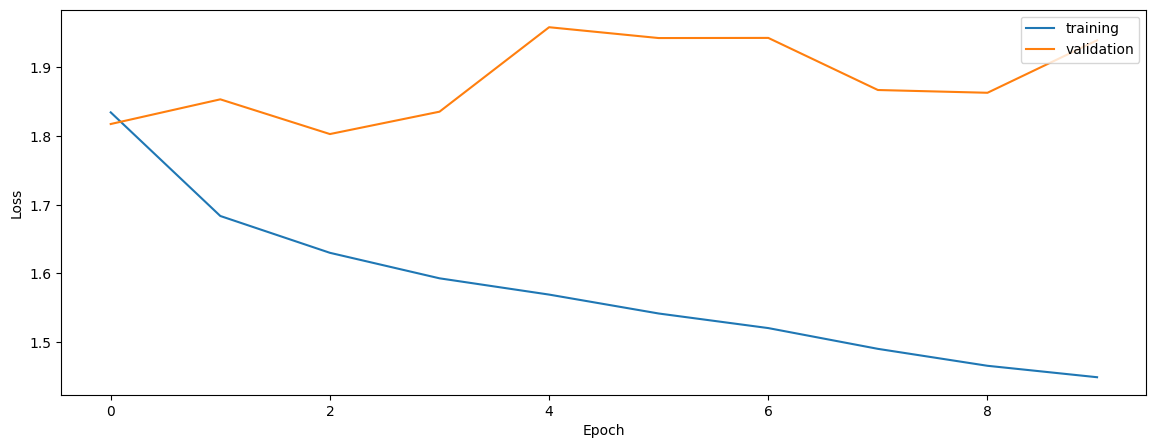

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.36065104963134603
0.27950619589859854
0.31022845109008745


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.37807479984671316
0.35608604614412137
0.2936958983900979


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.3801051118082987
0.36131347325660124
0.29856182810579807


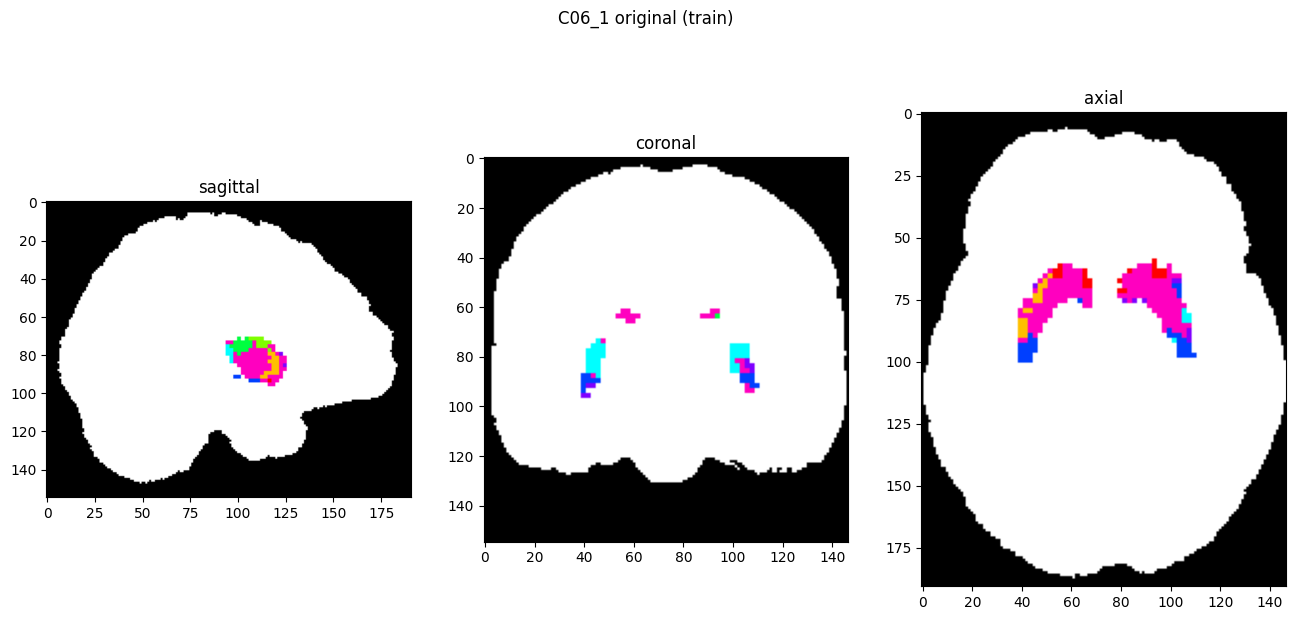

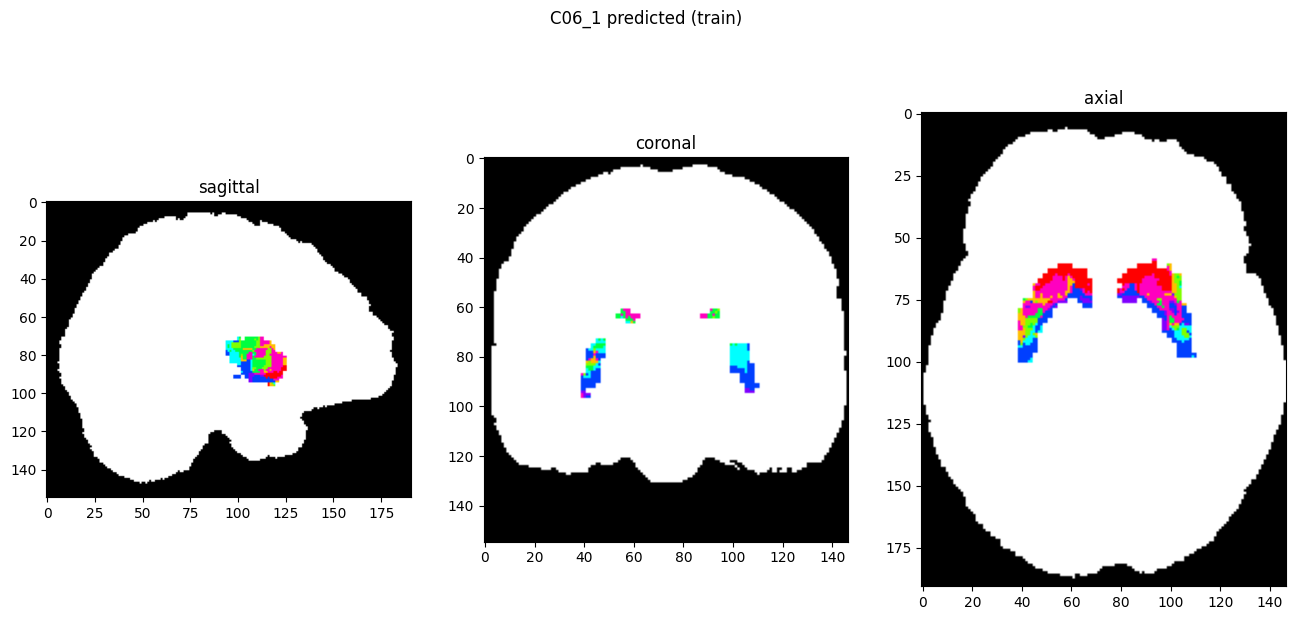

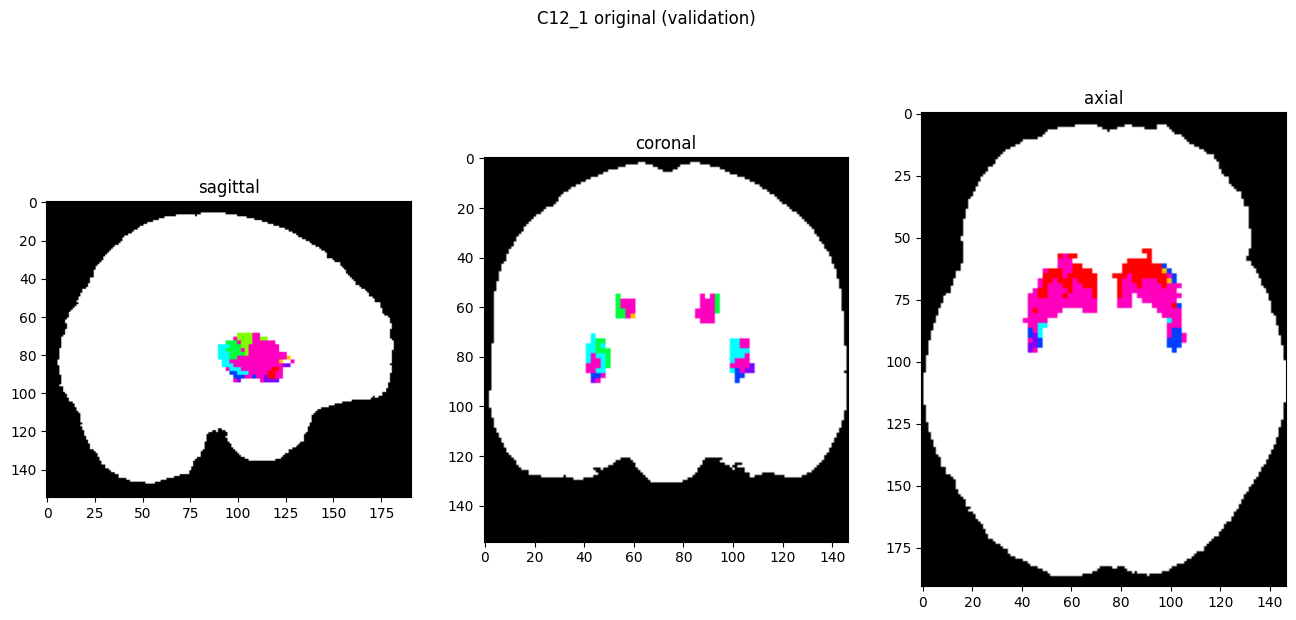

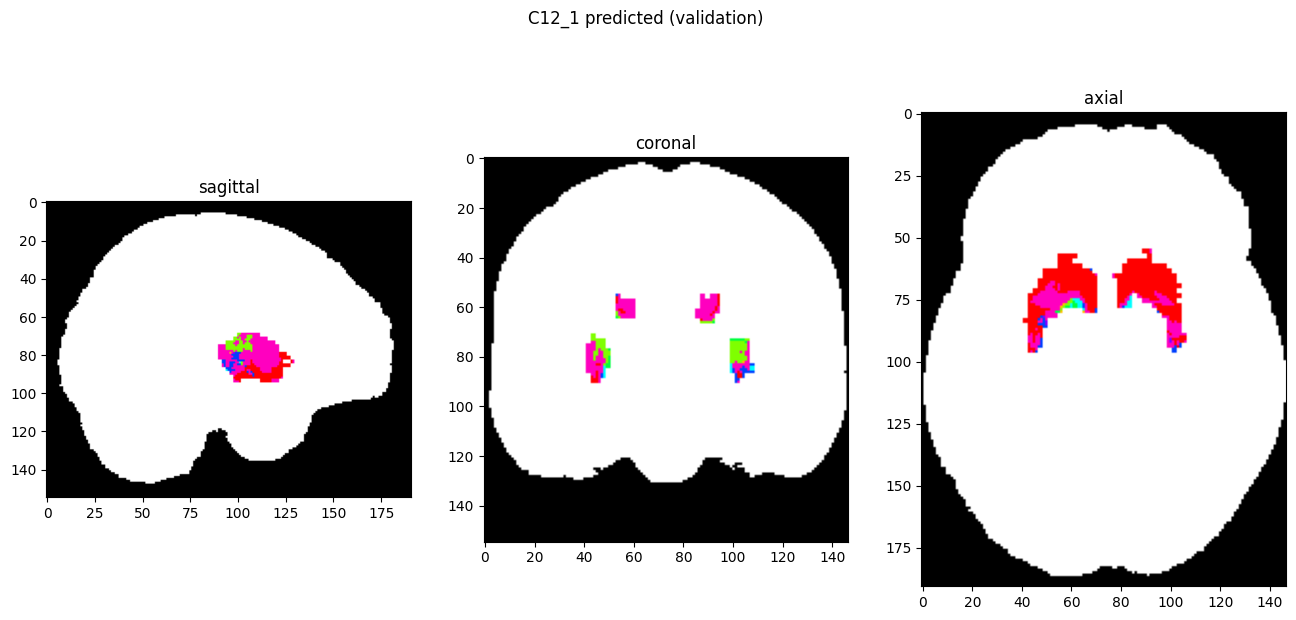

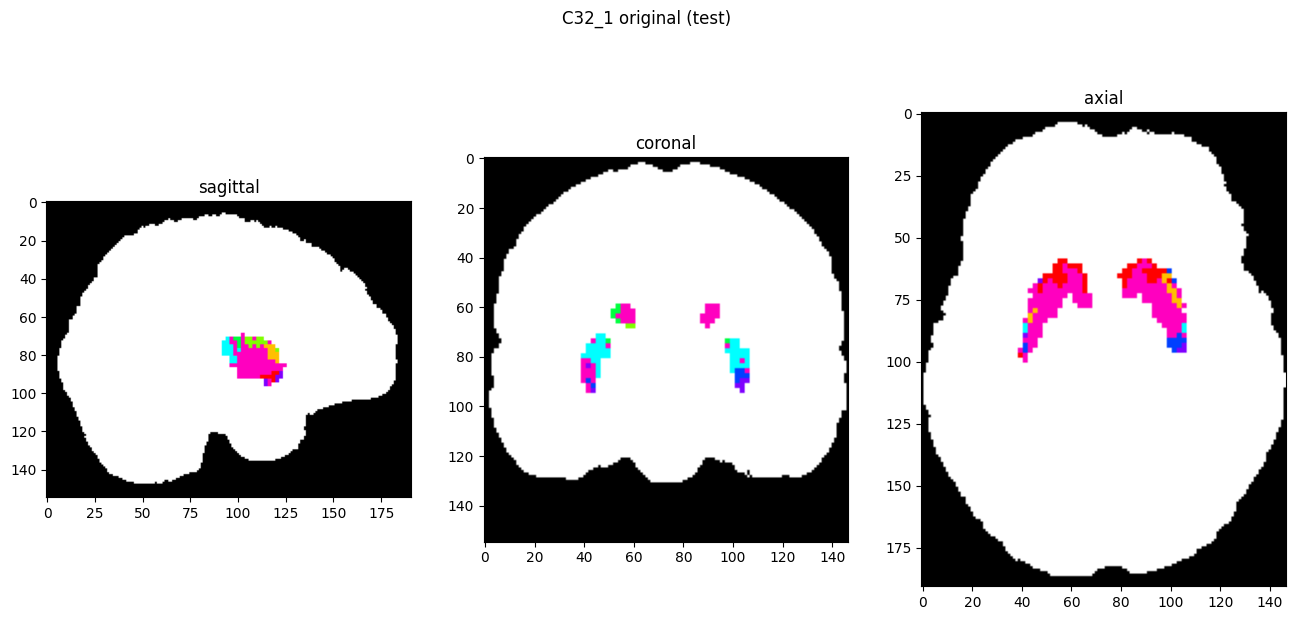

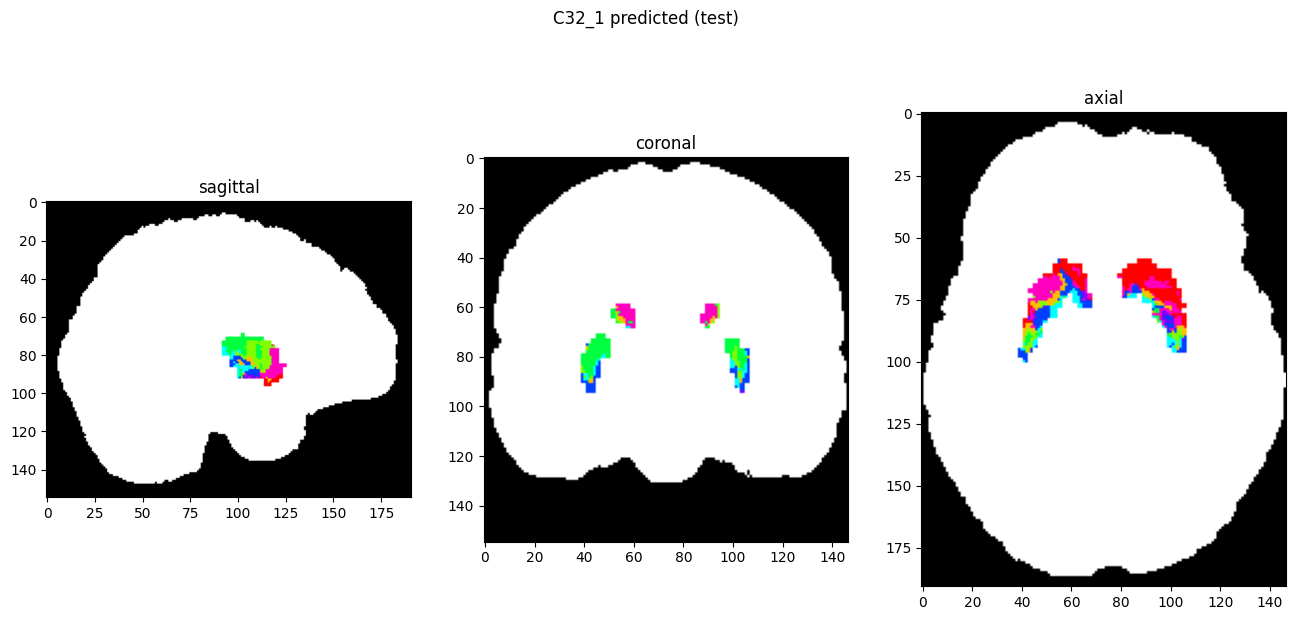

In [10]:
showResults(model, gen, threshold=0)